# Testing conditional valid metrics for locart

In [1]:
import numpy as np
import pandas as pd
import os
import scipy.stats as st

from nonconformist.cp import IcpRegressor
from nonconformist.nc import NcFactory
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

from lcv.locart import LocalRegressionSplit, LocartSplit, MondrianRegressionSplit, QuantileSplit
from lcv.locluster import KmeansSplit
from lcv.models import QuantileGradientBoosting, QuantileForest
from lcv.scores import RegressionScore, QuantileScore
import time


from lcv.locart import LocartSplit, MondrianRegressionSplit
from lcv.scores import RegressionScore
from lcv.simulation import simulation
from lcv.utils import compute_interval_length, HSIC_correlation, pearson_correlation, ILS_coverage, split, real_coverage, wsd, clustering_coverage, clustering_CI_coverage
from lcv.utils import wsc_coverage
from lcv.valid_pred_sets import Valid_pred_sets

original_path = os.getcwd()

# figure path
images_dir = "figures"

## Testing metrics for simulated data:

We will now compare the real conditional coverage of simulated data to these state of art metrics:

In [17]:
def obtain_main_metrics_sim(
    kind = "homoscedastic", 
    n = 25000,
    calib_size = 0.5,
    d = 20, 
    coef = 2,
    hetero_value = 1,
    asym_value = 0.6,
    t_degree = 4,
    random_seed_X = 850,
    random_seed = 1250,
    sig = 0.05,
    alpha = 0.5,
    B_x = 5000,
    B_y = 1000,
    type_score = "regression",
    base_model = RandomForestRegressor,
    figname_tree = "locart_tree_real_data.pdf",
    test_size = 0.2,
    split_calib = True,
    plot_tree = True,
    n_estimators = 200,
    quantiles = [0.8, 0.85, 0.9, 0.95],
    random_states = [750, 85, 666, 69],
    prop_k = np.arange(2, 11),
    tune_k = True,
    nbins = 20,
    criterion = "squared_error",
    max_depth = None,
    max_leaf_nodes = None,
    min_samples_leaf = 300,
    prune = True,
    **kwargs):

    # generating X's features from uniform
    # testing first if our kind of dataset is the latent one or not
    np.random.seed(random_seed_X)
    if(kind != "heteroscedastic_latent"):
        X_test = np.random.uniform(low = -1.5, high = 1.5, size = (B_x, d))
    else:
        X_test = np.column_stack(
            (np.random.binomial(1,p = 0.2, size = B_x),
            np.random.uniform(low = -5, high = 5, size=(B_x, d + 1))))

    # simulating data and then splitting into train, calibration and test set
    sim_obj = simulation(dim = d, coef = coef, hetero_value = hetero_value, asym_value = asym_value, t_degree = t_degree)
    sim_kind = getattr(sim_obj, kind)
    sim_kind(n, random_seed = random_seed)
    data = split(sim_obj.X, sim_obj.y, test_size = test_size, calib_size = calib_size, calibrate = True, random_seed = random_seed)

     # simulating several y from same X
    r_kind = getattr(sim_obj, kind + "_r")
    # testing again if kind is heteroscedastic latent
    if(kind != "heteroscedastic_latent"):
        y_mat = r_kind(X_test[:, 0], B = B_y)
    else:
        y_mat = r_kind(X_test, B = B_y)
        # updating X_test to not use latent variable
        X_test = X_test[:, 1:]

    if type_score == "regression":
        # fitting mondrian regression split
        print("Fitting mondrian regression split")
        start_mondrian_split = time.time()
        micp = MondrianRegressionSplit(base_model, alpha = sig, k = nbins, **kwargs)
        micp.fit(data["X_train"], data["y_train"])
        micp.calibrate(data["X_calib"], data["y_calib"])

        end_mondrian_split = time.time() - start_mondrian_split
        print("Time Elapsed to fit mondrian regression split: ", end_mondrian_split)

        print("Computing metrics")
        start_mondrian_split = time.time()
        # predictions for empirical metrics
        micp_pred = micp.predict(data["X_test"])

        # predictions for real coverage
        micp_pred_cov = micp.predict(X_test)
        cond_micp_real = real_coverage(micp_pred_cov, y_mat)

        # average, median and max distance
        dif = np.abs(cond_micp_real - (1 - sig))
        micp_ave_dist, micp_med_dist, micp_max_dist = np.mean(dif), np.median(dif), np.max(dif)

        # mondrian icp correlations 
        micp_pcor = pearson_correlation(micp_pred, data["y_test"])
        micp_hsic = HSIC_correlation(micp_pred, data["y_test"])

        # mondrian wsc
        micp_wsc = wsc_coverage(data["X_test"], data["y_test"], micp_pred)

        # mean interval length
        micp_interval_len = np.mean(compute_interval_length(micp_pred))


        # marginal coverage
        marg_cover = np.logical_and(data["y_test"] >= micp_pred[:, 0], 
            data["y_test"] <= micp_pred[:, 1]) + 0
        micp_ave_marginal_cov = np.mean(
            marg_cover
        )

        # interval length | coveraqe
        cover_idx = np.where(marg_cover == 1)
        micp_interval_len_cover = np.mean(compute_interval_length(micp_pred[cover_idx]))


        end_mondrian_split = time.time() - start_mondrian_split
        print("Time Elapsed to compute statistics for mondrian regression split: ", end_mondrian_split)

        print("Fitting locluster")
        start_locluster = time.time()
        locluster_obj = KmeansSplit(nc_score = RegressionScore, base_model = base_model, alpha = sig, **kwargs)
        locluster_obj.fit(data["X_train"], data["y_train"])
        locluster_obj.calib(data["X_calib"], data["y_calib"], tune_k = tune_k, 
        prop_k = prop_k, n_estimators = n_estimators, quantiles = quantiles, random_states = random_states)

        end_locluster = time.time() - start_locluster
        print("Time Elapsed to fit locluster: ", end_locluster)


        print("Computing metrics")
        start_locluster = time.time()
        # predictions
        locluster_pred = np.array(locluster_obj.predict(data["X_test"], length = 2000))

        # predictions for real coverage
        locluster_pred_cov = np.array(locluster_obj.predict(X_test, length = 2000))
        cond_locluster_real = real_coverage(locluster_pred_cov, y_mat)
        
        # average, median and max distance
        dif = np.abs(cond_locluster_real - (1 - sig))
        locluster_ave_dist, locluster_med_dist, locluster_max_dist = np.mean(dif), np.median(dif), np.max(dif)


        # mondrian icp correlations 
        locluster_pcor = pearson_correlation(locluster_pred, data["y_test"])
        locluster_hsic = HSIC_correlation(locluster_pred, data["y_test"])

        # mondrian wsc
        locluster_wsc = wsc_coverage(data["X_test"], data["y_test"], locluster_pred)

        # mean interval length
        locluster_interval_len = np.mean(compute_interval_length(locluster_pred))

        # marginal coverage
        marg_cover = np.logical_and(data["y_test"] >= locluster_pred[:, 0], 
            data["y_test"] <= locluster_pred[:, 1]) + 0
        locluster_ave_marginal_cov = np.mean(
            marg_cover
        )

        # interval length | coveraqe
        cover_idx = np.where(marg_cover == 1)
        locluster_interval_len_cover = np.mean(compute_interval_length(locluster_pred[cover_idx]))

        end_locluster = time.time() - start_locluster
        print("Time Elapsed to compute metrics for Locluster: ", end_locluster)


        print("Fitting locart")
        start_loc = time.time()
        # fitting locart
        locart_obj = LocartSplit(nc_score = RegressionScore, base_model = base_model, alpha = sig, split_calib = split_calib, **kwargs)
        locart_obj.fit(data["X_train"], data["y_train"])
        locart_obj.calib(data["X_calib"], data["y_calib"], max_depth = max_depth, 
        max_leaf_nodes = max_leaf_nodes, min_samples_leaf = min_samples_leaf, criterion = criterion, prune_tree = prune)
        
        end_loc = time.time() - start_loc
        print("Time Elapsed to fit Locart: ", end_loc)

        print("Computing metrics")
        start_loc = time.time()
       # predictions
        locart_pred = np.array(locart_obj.predict(data["X_test"], length = 2000))

        # predictions for real coverage
        locart_pred_cov = np.array(locart_obj.predict(X_test, length = 2000))
        cond_locart_real = real_coverage(locart_pred_cov, y_mat)

        # average, median and max distance
        dif = np.abs(cond_locart_real - (1 - sig))
        locart_ave_dist, locart_med_dist, locart_max_dist = np.mean(dif), np.median(dif), np.max(dif)


        # mondrian icp correlations 
        locart_pcor = pearson_correlation(locart_pred, data["y_test"])
        locart_hsic = HSIC_correlation(locart_pred, data["y_test"])

        # mondrian wsc
        locart_wsc = wsc_coverage(data["X_test"], data["y_test"], locart_pred)

        # mean interval length
        locart_interval_len = np.mean(compute_interval_length(locart_pred))

        # marginal coverage
        marg_cover = np.logical_and(data["y_test"] >= locart_pred[:, 0], 
            data["y_test"] <= locart_pred[:, 1]) + 0
        locart_ave_marginal_cov = np.mean(
            marg_cover
        )

        # interval length | coveraqe
        cover_idx = np.where(marg_cover == 1)
        locart_interval_len_cover = np.mean(compute_interval_length(locart_pred[cover_idx]))
        end_loc = time.time() - start_loc
        print("Time Elapsed to compute metrics for Locart: ", end_loc)

        # fitting default regression split
        print("Fitting regression split")
        start_split = time.time()
        model = base_model(**kwargs)
        nc = NcFactory.create_nc(model)
        icp = IcpRegressor(nc)
        icp.fit(data["X_train"], data["y_train"])
        icp.calibrate(data["X_calib"], data["y_calib"])

        end_split = time.time() - start_split
        print("Time Elapsed to fit regression split: ", end_split)

        print("Computing metrics")
        start_split = time.time()
        # predictions
        icp_pred = icp.predict(data["X_test"], significance = sig)

        # predictions for real coverage
        icp_pred_cov = icp.predict(X_test, significance = sig)
        cond_icp_real = real_coverage(icp_pred_cov, y_mat)
        
        # average, median and max distance
        dif = np.abs(cond_icp_real - (1 - sig))
        icp_ave_dist, icp_med_dist, icp_max_dist = np.mean(dif), np.median(dif), np.max(dif)

        # ICP icp correlations 
        icp_pcor = pearson_correlation(icp_pred, data["y_test"])
        icp_hsic = HSIC_correlation(icp_pred, data["y_test"])

        # ICP wsc
        icp_wsc = wsc_coverage(data["X_test"], data["y_test"], icp_pred)

        # ICP interval length
        icp_interval_len = np.mean(compute_interval_length(icp_pred))

       # marginal coverage
        marg_cover = np.logical_and(data["y_test"] >= icp_pred[:, 0], 
            data["y_test"] <= icp_pred[:, 1]) + 0
        icp_ave_marginal_cov = np.mean(
            marg_cover
        )

        # interval length | coveraqe
        cover_idx = np.where(marg_cover == 1)
        icp_interval_len_cover = np.mean(compute_interval_length(icp_pred[cover_idx]))

        end_split = time.time() - start_split
        print("Time Elapsed to compute statistics for regression split: ", end_split)

        # fitting wighted regression split
        print("Fitting weighted regression split")
        start_weighted_split = time.time()
        wicp = LocalRegressionSplit(base_model, alpha = sig, **kwargs)
        wicp.fit(data["X_train"], data["y_train"])
        wicp.calibrate(data["X_calib"], data["y_calib"])

        end_weighted_split = time.time() - start_weighted_split
        print("Time Elapsed to fit weighted regression split: ", end_weighted_split)

        print("Computing metrics")
        start_weighted_split = time.time()
        # predictions
        wicp_pred = wicp.predict(data["X_test"])

        # predictions for real coverage
        wicp_pred_cov = wicp.predict(X_test)
        cond_wicp_real = real_coverage(wicp_pred_cov, y_mat)
        
        # average, median and max distance
        dif = np.abs(cond_wicp_real - (1 - sig))
        wicp_ave_dist, wicp_med_dist, wicp_max_dist = np.mean(dif), np.median(dif), np.max(dif)

        # ICP icp correlations 
        wicp_pcor = pearson_correlation(wicp_pred, data["y_test"])
        wicp_hsic = HSIC_correlation(wicp_pred, data["y_test"])

        # ICP wsc
        wicp_wsc = wsc_coverage(data["X_test"], data["y_test"], wicp_pred)

        # ICP interval length
        wicp_interval_len = np.mean(compute_interval_length(wicp_pred))

        # marginal coverage
        marg_cover = np.logical_and(data["y_test"] >= wicp_pred[:, 0], 
            data["y_test"] <= wicp_pred[:, 1]) + 0
        wicp_ave_marginal_cov = np.mean(
            marg_cover
        )

        # interval length | coveraqe
        cover_idx = np.where(marg_cover == 1)
        wicp_interval_len_cover = np.mean(compute_interval_length(wicp_pred[cover_idx]))
        print("Time Elapsed to compute statistics for weighted regression split: ", end_weighted_split)

        # computing ils coverage of all methods compared to locart
        ils_locart_micp = ILS_coverage(locart_pred, micp_pred, data["y_test"])
        ils_locart_wicp = ILS_coverage(locart_pred, wicp_pred, data["y_test"])
        ils_locart_icp = ILS_coverage(locart_pred, icp_pred, data["y_test"])
        ils_locart_locluster = ILS_coverage(locart_pred, locluster_pred, data["y_test"])

        
        all_results =  pd.DataFrame(data = {"Methods":["LOCLUSTER", "LOCART", "Regresion split", "Weighted regression split", "Mondrian regression split"],
        "Pearson correlation":[locluster_pcor, locart_pcor,  icp_pcor, wicp_pcor, micp_pcor],
        "HSIC correlation":[locluster_hsic, locart_hsic, icp_hsic, wicp_hsic, micp_hsic],
        "delta wsc":[locluster_wsc, locart_wsc, icp_wsc, wicp_wsc, micp_wsc],
        "delta_ils":[ils_locart_locluster, 0, ils_locart_icp, ils_locart_wicp, ils_locart_micp],
        "Average marginal coverage":[locluster_ave_marginal_cov, locart_ave_marginal_cov, icp_ave_marginal_cov, wicp_ave_marginal_cov, micp_ave_marginal_cov],
        "Average interval length":[locluster_interval_len, locart_interval_len, icp_interval_len, wicp_interval_len, micp_interval_len],
        "Average interval length given coverage":[locluster_interval_len_cover, locart_interval_len_cover, icp_interval_len_cover,
        wicp_interval_len_cover, micp_interval_len_cover],
        "Average distance":[locluster_ave_dist, locart_ave_dist, icp_ave_dist, wicp_ave_dist, micp_ave_dist],
        "Median distance":[locluster_med_dist, locart_med_dist, icp_med_dist, wicp_med_dist, micp_med_dist],
        "Max distance":[locluster_max_dist, locart_max_dist, icp_max_dist, wicp_max_dist, micp_max_dist]})
    
    elif type_score == "quantile":
        # fitting gradient boosting quantile regression
        # first fitting quantile split
        print("Fitting CQR")
        cqr = QuantileSplit(base_model, alpha = sig, **kwargs)
        cqr.fit(data["X_train"], data["y_train"])
        cqr.calibrate(data["X_test"], data["y_test"])
        
        # icp real coverage and interval length
        pred_cqr = cqr.predict(X_test)
        cqr_cond_r_real = real_coverage(pred_cqr, y_mat)
        cqr_interval_len = compute_interval_length(pred_cqr)

        # computing icp measures
        cqr_ave_dist = np.mean(np.abs(cqr_cond_r_real - (1 - sig)))
        cqr_ave_marginal_cov = np.mean(cqr_cond_r_real)
        cqr_med_cover = np.median(cqr_cond_r_real)
        cqr_med_dist = np.median(np.abs(cqr_cond_r_real - (1 - sig)))
        cqr_interval = np.mean(cqr_interval_len)

        # fitting locluster
        print("Fitting Locluster")
        locluster_obj = KmeansSplit(nc_score = QuantileScore, base_model = base_model, alpha = sig, **kwargs)
        locluster_obj.fit(data["X_train"], data["y_train"])
        locluster_obj.calib(data["X_test"], data["y_test"], tune_k = tune_k, 
        prop_k = prop_k, n_estimators = n_estimators, quantiles = quantiles, random_states = random_states)


        # conditional coverage and interval length
        pred_locluster = np.array(locluster_obj.predict(X_test, length = 2000))
        cond_locluster_real =  real_coverage(pred_locluster, y_mat)
        locluster_interval_len = compute_interval_length(pred_locluster)

        # several measures
        locluster_ave_dist = np.mean(np.abs(cond_locluster_real - (1 - sig)))
        locluster_med_cover = np.median(cond_locluster_real)
        locluster_med_dist = np.median(np.abs(cond_locluster_real - (1 - sig)))
        locluster_ave_marginal_cov = np.mean(cond_locluster_real)
        locluster_interval = np.mean(locluster_interval_len)


        # fitting locart
        print("Fitting Locart")
        model = base_model(**kwargs)
        locart_obj = LocartSplit(nc_score = QuantileScore, base_model = base_model,
        base_model_type=True, alpha = sig, split_calib = split_calib, **kwargs)
        locart_obj.fit(data["X_train"], data["y_train"])
        locart_obj.calib(data["X_test"], data["y_test"], max_depth = max_depth, 
        max_leaf_nodes = max_leaf_nodes, min_samples_leaf = min_samples_leaf, criterion = criterion)

        # conditional coverage and interval length
        pred_locart = locart_obj.predict(X_test, length=2000)
        cond_locart_real = real_coverage(pred_locart, y_mat)
        locart_interval_len = compute_interval_length(pred_locart)
        
        # several measures
        locart_ave_dist = np.mean(np.abs(cond_locart_real - (1 - sig)))
        locart_med_cover = np.median(cond_locart_real)
        locart_med_dist = np.median(np.abs(cond_locart_real - (1 - sig)))
        locart_ave_marginal_cov = np.mean(cond_locart_real)
        locart_interval = np.mean(locart_interval_len)

        # fitting euclidean binning
        locart_obj.uniform_binning(data["X_test"], data["y_test"])

        # computing local coverage to uniform binning
        pred_uniform = locart_obj.predict(
            X_test, length=2000, type_model="euclidean"
        )

        uniform_cond_r_real = real_coverage(pred_uniform, y_mat)
        uniform_interval_len = compute_interval_length(pred_uniform)

        # computing euclidean binning measures
        uniform_ave_dist = np.mean(np.abs(uniform_cond_r_real - (1 - sig)))
        uniform_ave_marginal_cov = np.mean(uniform_cond_r_real)
        uniform_med_cover = np.median(uniform_cond_r_real)
        uniform_med_dist = np.median(np.abs(uniform_cond_r_real - (1 - sig)))
        uniform_interval = np.mean(uniform_interval_len)

        # fitting raw quantilic regression
        qgb_obj = model
        qgb_obj.fit(data["X_train"], data["y_train"])

        pred_qgb = qgb_obj.predict(X_test)
        cond_qgb_real = real_coverage(pred_qgb, y_mat)
        qgb_interval_len = compute_interval_length(pred_qgb)

        # computing raw quantilic measures
        qgb_ave_dist = np.mean(np.abs(cond_qgb_real - (1 - sig)))
        qgb_ave_marginal_cov = np.mean(cond_qgb_real)
        qgb_med_cover = np.median(cond_qgb_real)
        qgb_med_dist = np.median(np.abs(cond_qgb_real - (1 - sig)))
        qgb_interval = np.mean(qgb_interval_len)
    
        
        all_results =  pd.DataFrame(data = {"Methods":["LOCLUSTER", "LOCART", "CQR", "Euclidean CQR", "Quantilic Regression"],
        "Average distance":[locluster_ave_dist, locart_ave_dist, cqr_ave_dist, uniform_ave_dist, qgb_ave_dist],
        "Median conditional coverage":[locluster_med_cover, locart_med_cover, cqr_med_cover, uniform_med_cover, qgb_med_cover],
        "Median distance":[locluster_med_dist, locart_med_dist, cqr_med_dist, uniform_med_dist, qgb_med_dist],
        "Average marginal coverage":[locluster_ave_marginal_cov, locart_ave_marginal_cov, cqr_ave_marginal_cov, uniform_ave_marginal_cov, qgb_ave_marginal_cov],
        "Average interval length":[locluster_interval, locart_interval, cqr_interval, uniform_interval, qgb_interval]})

        # plotting boxplots
        # gathering all data into a data frame
        boxplot_data = pd.melt(pd.DataFrame(data = {"Methods":list(np.repeat(["LOCLUSTER", "LOCART", "CQR", 
        "Euclidean CQR", "Quantilic Regression"],
        locart_interval_len.shape[0])),
        "Interval length": list(np.concatenate((locluster_interval_len, locart_interval_len, cqr_interval_len, uniform_interval_len, qgb_interval_len))),
        "Coverage": list(np.concatenate((cond_locluster_real, cond_locart_real, cqr_cond_r_real, uniform_cond_r_real, cond_qgb_real)))
        }), id_vars = ['Methods'], value_vars = ['Interval length', 'Coverage'])

        plt.figure(figsize=(10, 6))
        sns.catplot(data = boxplot_data,
        y = 'Methods', x = 'value', col = 'variable', kind = 'box', sharex= False)
        plt.tight_layout()
        plt.show()
        
    # plotting tree to visualize partitions
    if plot_tree:
        plt.figure(figsize=(25, 20))
        locart_obj.plot_locart()
        plt.savefig(f"{images_dir}/{figname_tree}")
        plt.show()
    
    return [all_results, locart_obj]

### Homoscedastic data

Fitting mondrian regression split
Time Elapsed to fit mondrian regression split:  27.776260137557983
Computing metrics
Time Elapsed to compute statistics for mondrian regression split:  152.2944791316986
Fitting locluster
Time Elapsed to fit locluster:  62.37281584739685
Computing metrics
Time Elapsed to compute metrics for Locluster:  295.4131534099579
Fitting locart
Time Elapsed to fit Locart:  26.042553663253784
Computing metrics
Time Elapsed to compute metrics for Locart:  286.40580892562866
Fitting regression split
Time Elapsed to fit regression split:  25.77607011795044
Computing metrics
Time Elapsed to compute statistics for regression split:  149.25707387924194
Fitting weighted regression split
Time Elapsed to fit weighted regression split:  41.778005838394165
Computing metrics
Time Elapsed to compute statistics for weighted regression split:  41.778005838394165


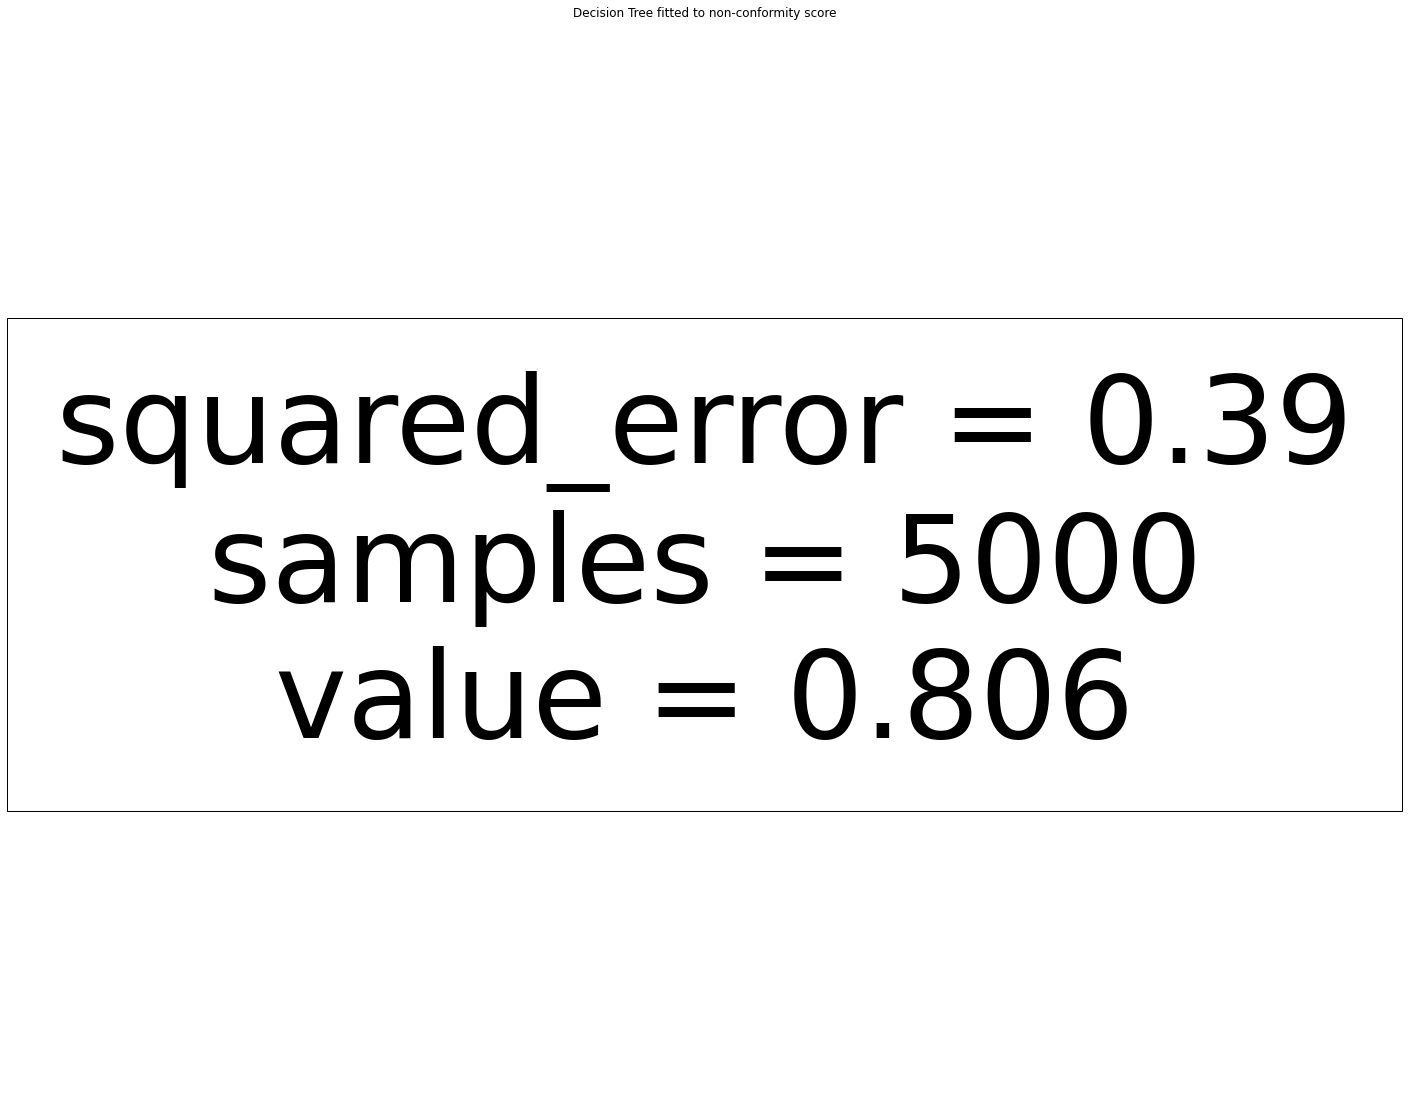

<Figure size 432x288 with 0 Axes>

In [18]:
homoc_values = obtain_main_metrics_sim(figname_tree = "test.pdf",
split_calib = True, sig  = 0.1, random_state = 650)

In [19]:
homoc_values[0]

Methods  Pearson correlation  HSIC correlation  \
0                  LOCLUSTER             0.024320      9.463289e-08   
1                     LOCART            -0.009991      1.079703e-10   
2            Regresion split             0.004930     -3.707287e-19   
3  Weighted regression split             0.136138      1.652460e-04   
4  Mondrian regression split             0.060298      6.916299e-06   

   delta wsc  delta_ils  Average marginal coverage  Average interval length  \
0   0.008160  -0.002924                     0.8910                 3.257968   
1   0.010161   0.000000                     0.8918                 3.260012   
2   0.003561  -0.001452                     0.8984                 3.351777   
3   0.001312  -0.086800                     0.8930                 3.384233   
4   0.005846  -0.023962                     0.8910                 3.260196   

   Average interval length given coverage  Average distance  Median distance  \
0                                3.258358          0.014174            0.011   
1                                3.259999          0.013391            0.010   
2                                3.351777          0.010539            0.008   
3                                3.405239          0.035703            0.030   
4                                3.263654          0.020227            0.016   

   Max distance  
0         0.159  
1         0.155  
2         0.144  
3         0.244  
4         0.166

### Heteroscedastic data

Fitting mondrian regression split
Time Elapsed to fit mondrian regression split:  26.383342504501343
Computing metrics
Time Elapsed to compute statistics for mondrian regression split:  149.52674555778503
Fitting locluster
Time Elapsed to fit locluster:  58.627174377441406
Computing metrics
Time Elapsed to compute metrics for Locluster:  285.66033029556274
Fitting locart
Time Elapsed to fit Locart:  26.247658014297485
Computing metrics
Time Elapsed to compute metrics for Locart:  282.6681787967682
Fitting regression split
Time Elapsed to fit regression split:  25.954337120056152
Computing metrics


/home/kuben/anaconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/kuben/anaconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Time Elapsed to compute statistics for regression split:  148.27358603477478
Fitting weighted regression split
Time Elapsed to fit weighted regression split:  38.79689621925354
Computing metrics
Time Elapsed to compute statistics for weighted regression split:  38.79689621925354


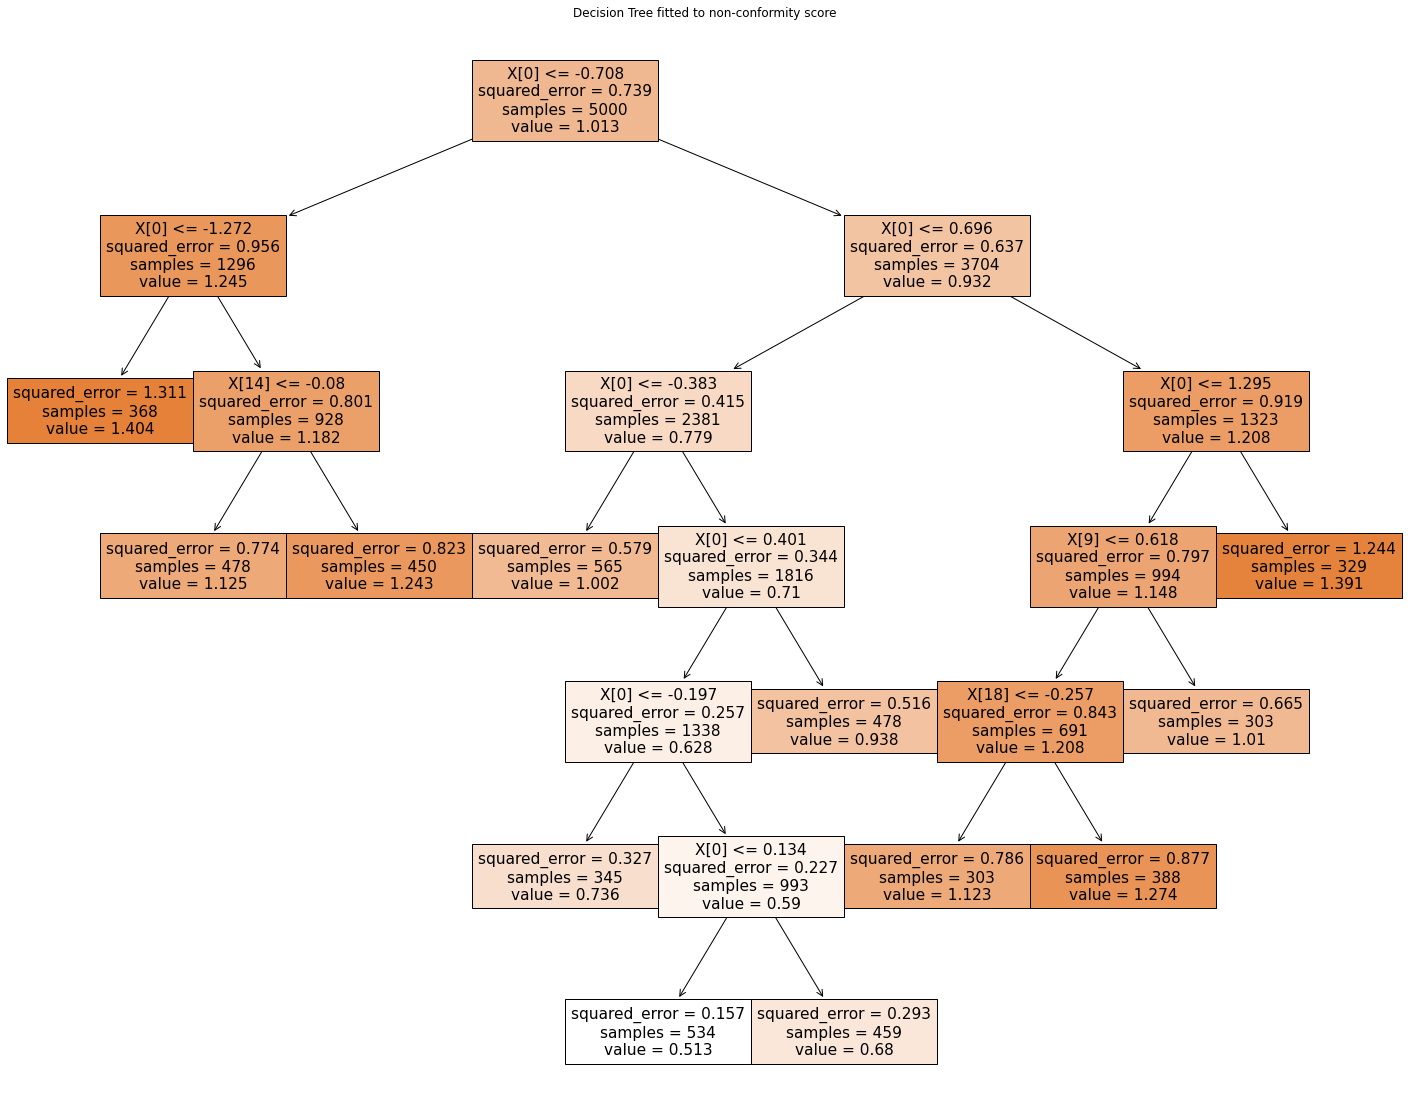

<Figure size 432x288 with 0 Axes>

In [20]:
hetero_values = obtain_main_metrics_sim(kind = "heteroscedastic", figname_tree = "test.pdf",
split_calib = True, hetero_value = 0.25, sig  = 0.1, random_state = 650)

In [21]:
hetero_values[0]

Methods  Pearson correlation  HSIC correlation  \
0                  LOCLUSTER             0.046701      6.902946e-05   
1                     LOCART             0.051403      5.961592e-05   
2            Regresion split                  NaN     -3.151358e-19   
3  Weighted regression split             0.114785      1.766519e-04   
4  Mondrian regression split             0.050742      4.052735e-05   

   delta wsc  delta_ils  Average marginal coverage  Average interval length  \
0   0.018089  -0.117425                     0.8964                 4.287666   
1   0.012804   0.000000                     0.8936                 4.189379   
2   0.003362  -0.115000                     0.9014                 4.438737   
3   0.009650  -0.081400                     0.9038                 4.432269   
4   0.000024  -0.013149                     0.8940                 4.231434   

   Average interval length given coverage  Average distance  Median distance  \
0                                4.304716          0.046568            0.040   
1                                4.210774          0.027774            0.022   
2                                4.438737          0.066321            0.070   
3                                4.488322          0.046040            0.039   
4                                4.252774          0.035228            0.029   

   Max distance  
0         0.333  
1         0.164  
2         0.238  
3         0.313  
4         0.213

### Asymmetric data

Fitting mondrian regression split
Time Elapsed to fit mondrian regression split:  33.34148979187012
Computing metrics
Time Elapsed to compute statistics for mondrian regression split:  152.1600317955017
Fitting locluster
Time Elapsed to fit locluster:  63.94956660270691
Computing metrics
Time Elapsed to compute metrics for Locluster:  282.91259765625
Fitting locart
Time Elapsed to fit Locart:  31.53838062286377
Computing metrics
Time Elapsed to compute metrics for Locart:  280.11436128616333
Fitting regression split
Time Elapsed to fit regression split:  31.388688802719116
Computing metrics
Time Elapsed to compute statistics for regression split:  148.4121515750885
Fitting weighted regression split
Time Elapsed to fit weighted regression split:  46.10574769973755
Computing metrics
Time Elapsed to compute statistics for weighted regression split:  46.10574769973755


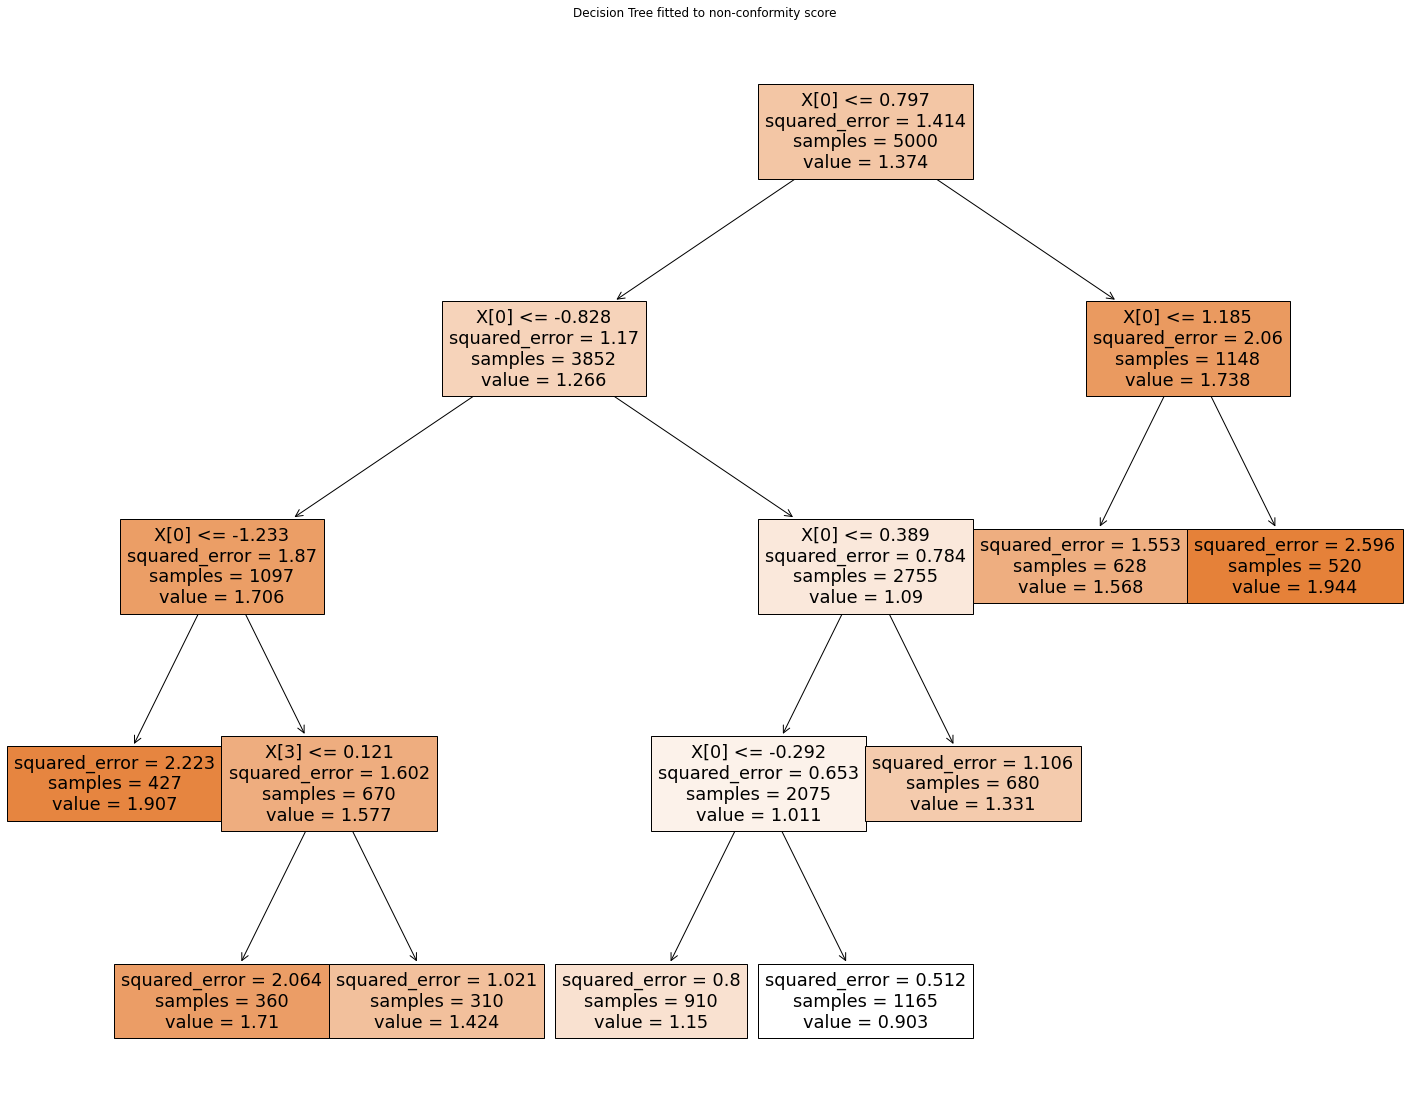

<Figure size 432x288 with 0 Axes>

In [22]:
asym_values = obtain_main_metrics_sim(kind = "asymmetric", figname_tree = "test.pdf",
split_calib = True, asym_value = 0.6, sig  = 0.1, random_state = 650)

In [23]:
asym_values[0]

Methods  Pearson correlation  HSIC correlation  \
0                  LOCLUSTER             0.033800      3.863243e-05   
1                     LOCART             0.019814      7.385520e-06   
2            Regresion split            -0.004932      6.635834e-19   
3  Weighted regression split             0.077578      7.130160e-05   
4  Mondrian regression split             0.025593      1.028147e-05   

   delta wsc  delta_ils  Average marginal coverage  Average interval length  \
0   0.007308  -0.041492                     0.8992                 5.378903   
1   0.006050   0.000000                     0.8990                 5.227800   
2   0.013378  -0.122496                     0.9006                 5.478020   
3   0.006541  -0.014600                     0.9036                 5.377476   
4   0.000822  -0.094801                     0.8964                 5.053614   

   Average interval length given coverage  Average distance  Median distance  \
0                                5.392745          0.039132            0.031   
1                                5.237320          0.031810            0.022   
2                                5.478020          0.060555            0.054   
3                                5.424627          0.041405            0.032   
4                                5.064604          0.045411            0.037   

   Max distance  
0         0.580  
1         0.625  
2         0.634  
3         0.676  
4         0.495

### More asymmetric

Fitting mondrian regression split
Time Elapsed to fit mondrian regression split:  31.83252739906311
Computing metrics
Time Elapsed to compute statistics for mondrian regression split:  144.0021047592163
Fitting locluster
Time Elapsed to fit locluster:  62.59557008743286
Computing metrics
Time Elapsed to compute metrics for Locluster:  218.41320061683655
Fitting locart
Time Elapsed to fit Locart:  30.510307788848877
Computing metrics
Time Elapsed to compute metrics for Locart:  215.61509251594543
Fitting regression split
Time Elapsed to fit regression split:  30.333038568496704
Computing metrics
Time Elapsed to compute statistics for regression split:  148.55631399154663
Fitting weighted regression split
Time Elapsed to fit weighted regression split:  44.16480803489685
Computing metrics
Time Elapsed to compute statistics for weighted regression split:  44.16480803489685


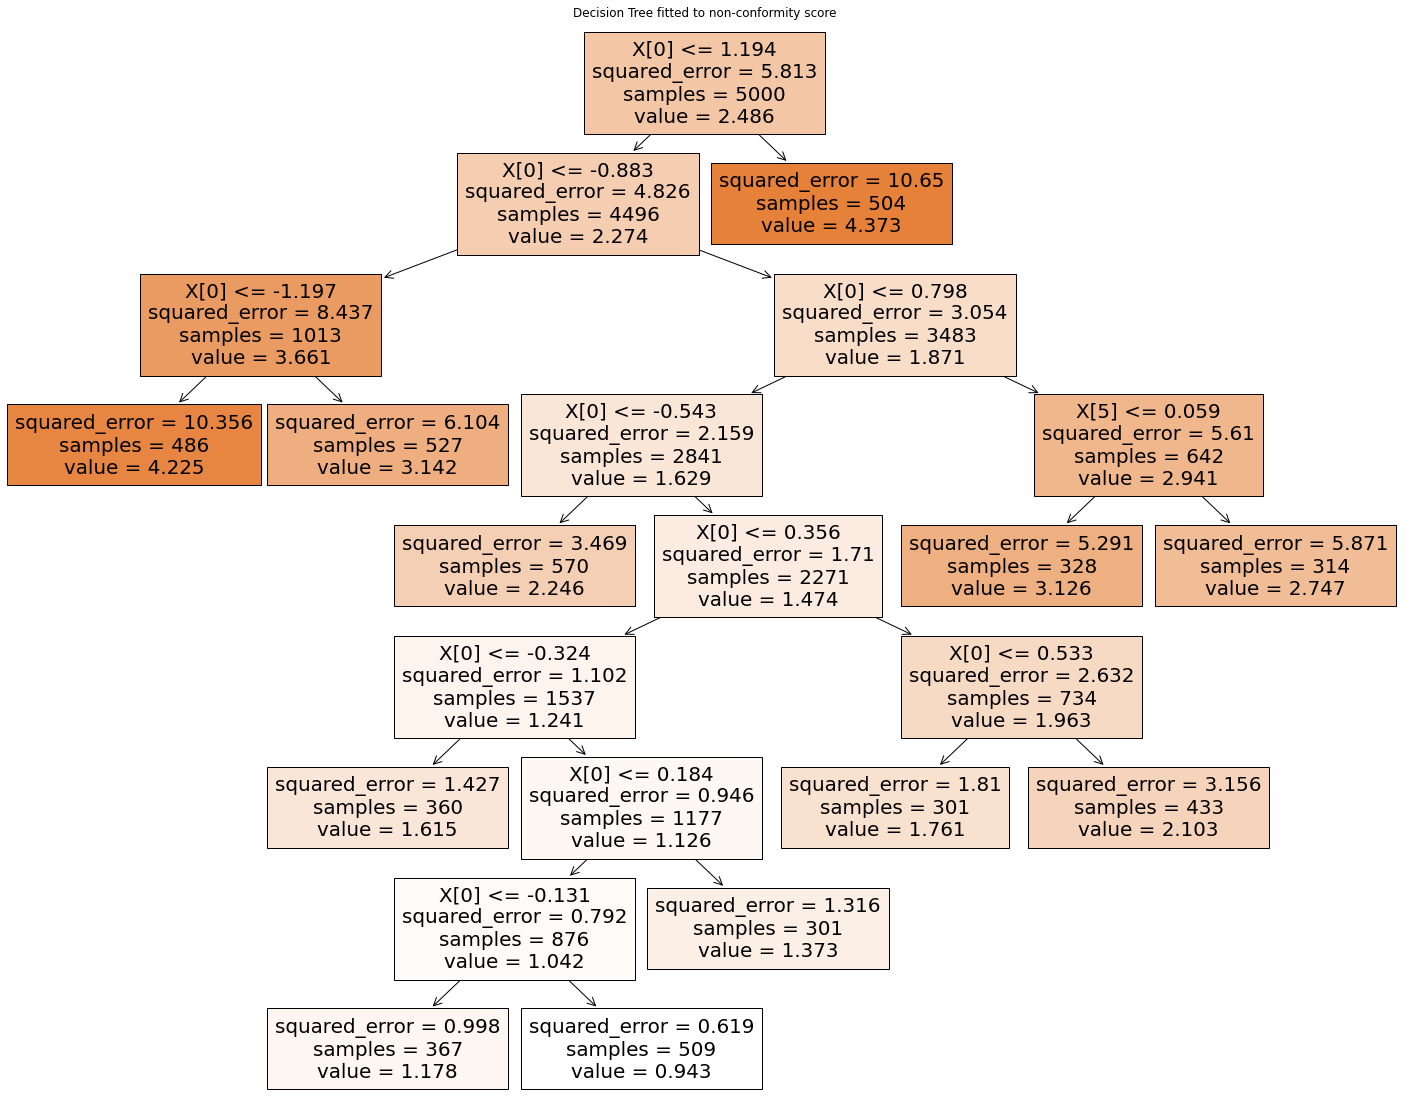

<Figure size 432x288 with 0 Axes>

In [10]:
asym_values = obtain_main_metrics_sim(kind = "asymmetric", figname_tree = "test.pdf",
split_calib = True, asym_value = 1.5, sig  = 0.1, random_state = 650)

In [11]:
asym_values[0]

Methods  Pearson correlation  HSIC correlation  \
0                  LOCLUSTER             0.026082      1.281986e-05   
1                     LOCART             0.027582      2.574757e-05   
2            Regresion split             0.005144      4.420680e-18   
3  Weighted regression split             0.076324      3.524907e-05   
4  Mondrian regression split             0.033832      2.312411e-05   

   delta wsc  delta_ils  Average marginal coverage  Average interval length  \
0   0.004742   0.020299                     0.9018                 9.916385   
1   0.022074   0.000000                     0.9022                 9.953089   
2   0.021980  -0.156694                     0.9030                10.967513   
3   0.008499  -0.041000                     0.8928                10.074346   
4   0.005589  -0.005001                     0.9032                 9.813669   

   Average interval length given coverage  
0                                9.953759  
1                                9.993509  
2                               10.967513  
3                               10.210924  
4                                9.860005

### Non-corr heteroscedastic

Fitting mondrian regression split
Time Elapsed to fit mondrian regression split:  42.11993908882141
Computing metrics
Time Elapsed to compute statistics for mondrian regression split:  147.34063529968262
Fitting locluster
Time Elapsed to fit locluster:  74.39536786079407
Computing metrics
Time Elapsed to compute metrics for Locluster:  288.87245178222656
Fitting locart
Time Elapsed to fit Locart:  41.892303228378296
Computing metrics
Time Elapsed to compute metrics for Locart:  280.66051197052
Fitting regression split
Time Elapsed to fit regression split:  41.876296043395996
Computing metrics


/home/kuben/anaconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/kuben/anaconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Time Elapsed to compute statistics for regression split:  147.44991779327393
Fitting weighted regression split
Time Elapsed to fit weighted regression split:  54.96128797531128
Computing metrics
Time Elapsed to compute statistics for weighted regression split:  54.96128797531128


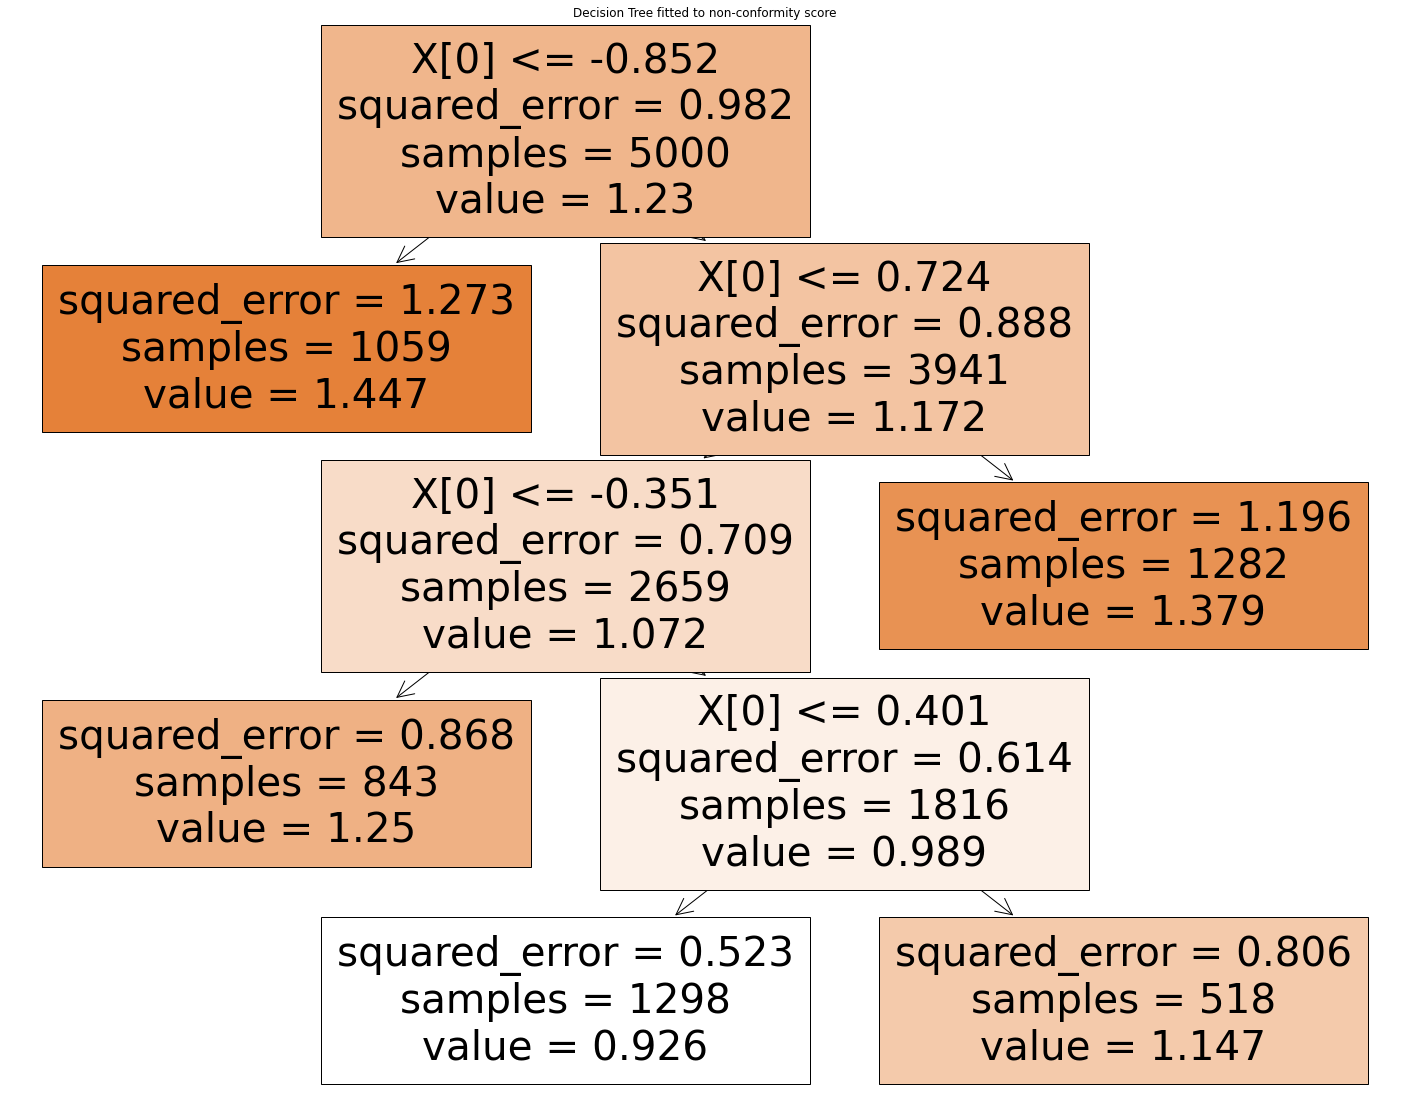

<Figure size 432x288 with 0 Axes>

In [24]:
non_cor_values = obtain_main_metrics_sim(kind = "non_cor_heteroscedastic", figname_tree = "test.pdf",
split_calib = True, asym_value = 1.5, sig  = 0.1, random_state = 650)

In [25]:
non_cor_values[0]

Methods  Pearson correlation  HSIC correlation  \
0                  LOCLUSTER             0.047922      6.016259e-05   
1                     LOCART             0.053034      6.448957e-05   
2            Regresion split                  NaN     -3.217785e-19   
3  Weighted regression split             0.117518      1.745198e-04   
4  Mondrian regression split             0.056817      4.665882e-05   

   delta wsc  delta_ils  Average marginal coverage  Average interval length  \
0   0.016793  -0.062822                     0.8972                 5.136318   
1   0.003243   0.000000                     0.8970                 5.122614   
2   0.002716  -0.025468                     0.8986                 5.210361   
3   0.017047  -0.082400                     0.8994                 5.316854   
4   0.005733  -0.051267                     0.8876                 5.074266   

   Average interval length given coverage  Average distance  Median distance  \
0                                5.149652          0.032428            0.029   
1                                5.140334          0.022716            0.020   
2                                5.210361          0.050381            0.051   
3                                5.369327          0.041845            0.035   
4                                5.088431          0.045617            0.040   

   Max distance  
0         0.218  
1         0.139  
2         0.142  
3         0.291  
4         0.206

## Comparing real data metrics to the real coverage in each setting:

In [26]:
# joining all data into one and melting
data_lists = [homoc_values[0].assign(type = "homoscedastic"), hetero_values[0].assign(type = "heteroscedastic"),
asym_values[0].assign(type = "assymetric"), non_cor_values[0].assign(type = "non-correlated")]

In [35]:
all_metrics_data = (pd.
melt(pd.
concat(data_lists), id_vars = ["Methods", "type", "Average distance", "Max distance"] ,value_vars = ['delta wsc', 'HSIC correlation', 'Pearson correlation'])
)
all_metrics_data.head(6)

Methods             type  Average distance  Max distance  \
0                  LOCLUSTER    homoscedastic          0.014174         0.159   
1                     LOCART    homoscedastic          0.013391         0.155   
2            Regresion split    homoscedastic          0.010539         0.144   
3  Weighted regression split    homoscedastic          0.035703         0.244   
4  Mondrian regression split    homoscedastic          0.020227         0.166   
5                  LOCLUSTER  heteroscedastic          0.046568         0.333   

    variable     value  
0  delta wsc  0.008160  
1  delta wsc  0.010161  
2  delta wsc  0.003561  
3  delta wsc  0.001312  
4  delta wsc  0.005846  
5  delta wsc  0.018089

Plotting max distance versus all the other metrics:

<Figure size 1152x576 with 0 Axes>

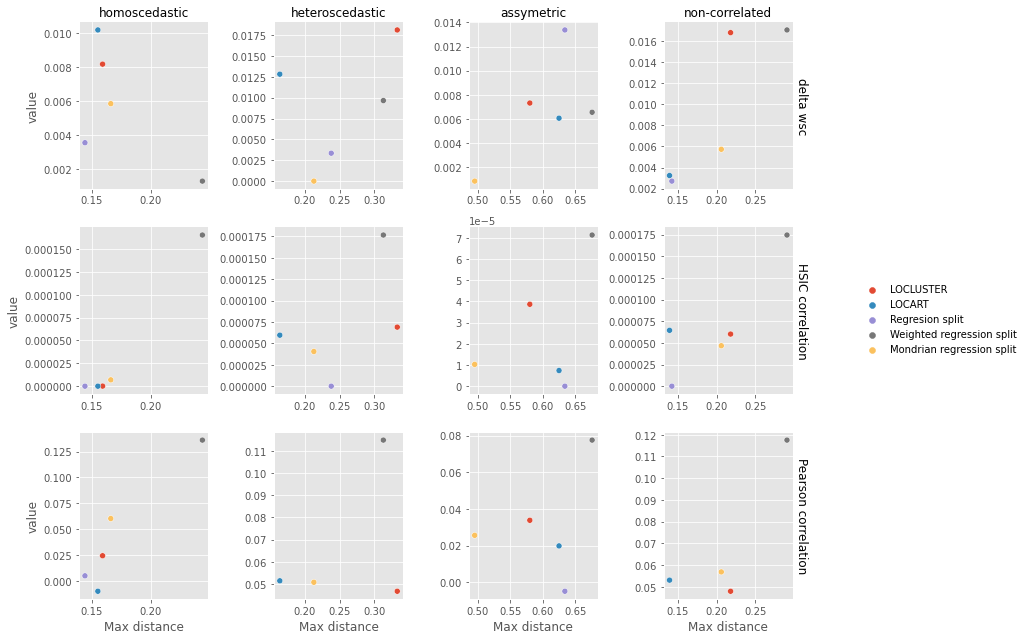

In [50]:
plt.figure(figsize = (16, 8))
g = sns.FacetGrid(data = all_metrics_data, col = 'type', row = "variable", sharex = False, sharey = False, margin_titles=True)
g.map_dataframe(
        sns.scatterplot, y = 'value', x = 'Max distance', hue = "Methods")
g.add_legend()
g.set_titles(row_template = '{row_name}', col_template = '{col_name}')
g.tight_layout()
plt.show()

Plotting mean distance versus all the other metrics:

<Figure size 1152x576 with 0 Axes>

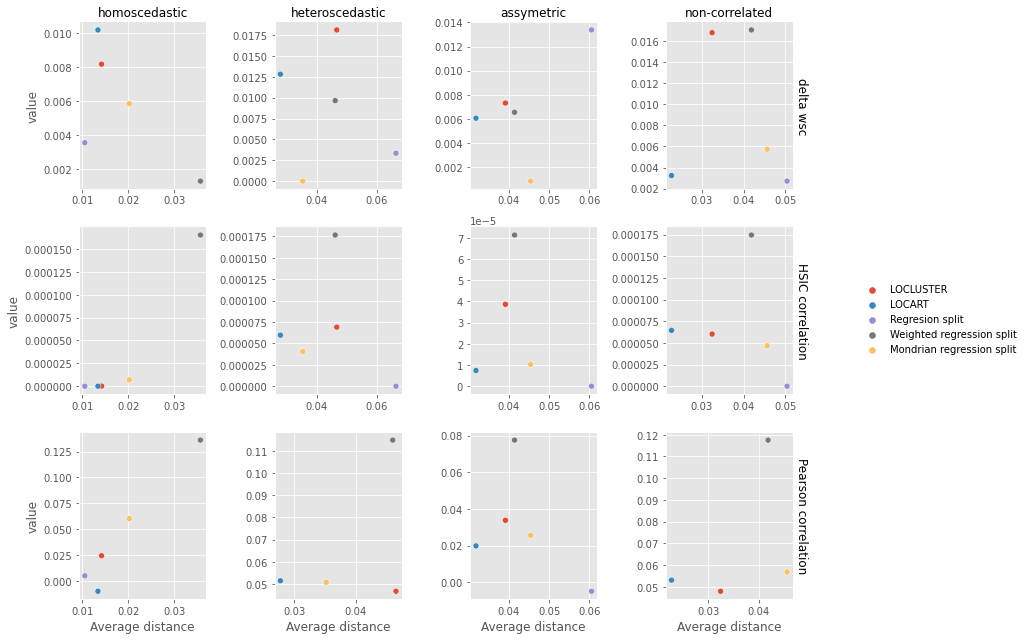

In [51]:
plt.figure(figsize = (16, 8))
g = sns.FacetGrid(data = all_metrics_data, col = 'type', row = "variable", sharex = False, sharey = False, margin_titles=True)
g.map_dataframe(
        sns.scatterplot, y = 'value', x = 'Average distance', hue = "Methods")
g.add_legend()
g.set_titles(row_template = '{row_name}', col_template = '{col_name}')
g.tight_layout()
plt.show()

## Toy example showing lack of quality of real data metrics

In [3]:
def simulate_toy(n = 25000, test_size = 0.2, calib_size = 0.5, coef = 2, sigma_1 = 1, sigma_2 = 10, random_seed = 1250):
    np.random.seed(random_seed)
    X = np.random.uniform(low = 0, high = 1, size=(n, 1))
    y = np.random.normal(coef * X[:, 0], (sigma_1 * (X[:, 0] > 1/2)) + (sigma_2 * (X[:,0] <= 1/2)), size = n) 
    data = split(X, y, test_size = test_size, calib_size = calib_size)
    return data

def r_toy(X_grid, coef = 2, sigma_1 = 1, sigma_2 = 10, B = 1000):
    y_mat = np.zeros((X_grid.shape[0], B))
    for i in range(X_grid.shape[0]):
        y_mat[i, :] = np.random.normal(coef * X_grid[i],
        scale = (sigma_1 * (X_grid[i, 0] > 1/2)) + (sigma_2 * (X_grid[i, 0] <= 1/2)), size=B)
    return y_mat

def run_toy_example(
    n = 25000,
    toy = True,
    kind = "homoscedastic",
    d = 20, 
    hetero_value = 1,
    asym_value = 0.6,
    t_degree = 4,
    base_model = RandomForestRegressor, 
    sig = 0.1, 
    test_size = 0.2,
    valid_test_size = 0.2,
    calib_size = 0.5, 
    coef = 2, 
    sigma_1 = 1, 
    sigma_2 = 10, 
    B_x = 5000,
    B_y = 1000, 
    random_seed_X = 850,
    random_seed = 1250,
    split_calib = True,
    plot_tree = True,
    nbins = 10,
    criterion = "squared_error",
    wsd_yes = False,
    max_depth = None,
    max_leaf_nodes = None,
    min_samples_leaf = 500,
    prune = True,
    tune_k = False,
    prop_k = 8,
    **kwargs):
    # generating X_test
    np.random.seed(random_seed_X)

    # simulating toy data
    if toy:
        X_test = np.random.uniform(low = 0, high = 1, size = (B_x, 1))
        data = simulate_toy(n, test_size, calib_size, coef, sigma_1, sigma_2, random_seed)
        y_mat = r_toy(X_test, B = B_y)

        X_grid = np.linspace(0, 1, 200)
        y_grid = r_toy(X_grid.reshape(-1,1), B = B_y)
    else:
        X_test = np.random.uniform(low = -1.5, high = 1.5, size = (B_x, d))
        sim_obj = simulation(dim = d, coef = coef, hetero_value = hetero_value, asym_value = asym_value, t_degree = t_degree)
        sim_kind = getattr(sim_obj, kind)
        sim_kind(n, random_seed = random_seed)
        data = split(sim_obj.X, sim_obj.y, test_size = test_size, calib_size = calib_size, calibrate = True, random_seed = random_seed)
        r_kind = getattr(sim_obj, kind + "_r")
        y_mat = r_kind(X_test[:, 0], B = B_y)
        

    # fitting locart
    print("Fitting locart to toy example:")
    start_loc = time.time()
    locart_obj = LocartSplit(nc_score = RegressionScore, base_model = base_model, alpha = sig, split_calib = split_calib, **kwargs)
    locart_obj.fit(data["X_train"], data["y_train"])
    locart_obj.calib(data["X_calib"], data["y_calib"], max_depth = max_depth, 
    max_leaf_nodes = max_leaf_nodes, min_samples_leaf = min_samples_leaf, criterion = criterion, prune_tree = prune)
    
    end_loc = time.time() - start_loc
    print("Time Elapsed to fit Locart: ", end_loc)

    print("Computing metrics")
    start_loc = time.time()
    # predictions
    locart_pred = np.array(locart_obj.predict(data["X_test"], length = 2000))
    locart_pred_cond = np.array(locart_obj.predict(X_test, length = 2000))
    cond_locart_real = real_coverage(locart_pred_cond, y_mat)

    # average, median and max distance
    dif_locart = np.abs(cond_locart_real - (1 - sig))
    locart_ave_dist, locart_med_dist, locart_max_dist = np.mean(dif_locart), np.median(dif_locart), np.max(dif_locart)


    # mondrian icp correlations 
    locart_pcor = pearson_correlation(locart_pred, data["y_test"])
    locart_hsic = HSIC_correlation(locart_pred, data["y_test"])

    locart_clust_cov = clustering_CI_coverage(data["X_test"], data["y_test"], locart_pred, alpha = sig, prop_k = prop_k, tune_k = tune_k)


    # valid pred sets
    locart_valid = Valid_pred_sets(conf = locart_obj, alpha = sig, coverage_evaluator = "CART")
    locart_valid.fit(data["X_test"], data["y_test"], test_size = valid_test_size)
    pred_set_dif_loc = locart_valid.compute_dif()

    # mean interval length
    locart_interval_len = np.mean(compute_interval_length(locart_pred))

    # marginal coverage
    marg_cover = np.logical_and(data["y_test"] >= locart_pred[:, 0], 
        data["y_test"] <= locart_pred[:, 1]) + 0
    locart_ave_marginal_cov = np.mean(
        marg_cover
    )

    # interval length | coveraqe
    cover_idx = np.where(marg_cover == 1)
    locart_interval_len_cover = np.mean(compute_interval_length(locart_pred[cover_idx]))
    end_loc = time.time() - start_loc
    print("Time Elapsed to compute metrics for Locart: ", end_loc)

    # fitting default regression split
    print("Fitting regression split")
    start_split = time.time()
    model = base_model(**kwargs)
    nc = NcFactory.create_nc(model)
    icp = IcpRegressor(nc)
    icp.fit(data["X_train"], data["y_train"])
    icp.calibrate(data["X_calib"], data["y_calib"])

    end_split = time.time() - start_split
    print("Time Elapsed to fit regression split: ", end_split)

    print("Computing metrics")
    start_split = time.time()
    # predictions
    icp_pred = icp.predict(data["X_test"], significance = sig)
    icp_pred_cond = icp.predict(X_test, significance = sig)
    cond_icp_real = real_coverage(icp_pred_cond, y_mat)
    
    # average, median and max distance
    dif_icp = np.abs(cond_icp_real - (1 - sig))
    icp_ave_dist, icp_med_dist, icp_max_dist = np.mean(dif_icp), np.median(dif_icp), np.max(dif_icp)

    # ICP icp correlations 
    icp_pcor = pearson_correlation(icp_pred, data["y_test"])
    icp_hsic = HSIC_correlation(icp_pred, data["y_test"])


    icp_clust_cov = clustering_CI_coverage(data["X_test"], data["y_test"], icp_pred, alpha = sig, tune_k = tune_k, prop_k = prop_k)

    # valid pred sets
    icp_valid = Valid_pred_sets(conf = icp, alpha = sig, isnc = True, coverage_evaluator = "CART")
    icp_valid.fit(data["X_test"], data["y_test"], test_size = valid_test_size)
    pred_set_dif_icp = icp_valid.compute_dif()

    # ICP interval length
    icp_interval_len = np.mean(compute_interval_length(icp_pred))

    # marginal coverage
    marg_cover = np.logical_and(data["y_test"] >= icp_pred[:, 0], 
        data["y_test"] <= icp_pred[:, 1]) + 0
    icp_ave_marginal_cov = np.mean(
        marg_cover
    )

    # interval length | coveraqe
    cover_idx = np.where(marg_cover == 1)
    icp_interval_len_cover = np.mean(compute_interval_length(icp_pred[cover_idx]))

    end_split = time.time() - start_split
    print("Time Elapsed to compute statistics for regression split: ", end_split)

    # fitting wighted regression split
    print("Fitting weighted regression split")
    start_weighted_split = time.time()
    wicp = LocalRegressionSplit(base_model, alpha = sig, **kwargs)
    wicp.fit(data["X_train"], data["y_train"])
    wicp.calibrate(data["X_calib"], data["y_calib"])

    end_weighted_split = time.time() - start_weighted_split
    print("Time Elapsed to fit weighted regression split: ", end_weighted_split)

    print("Computing metrics")
    start_weighted_split = time.time()
    # predictions
    wicp_pred = wicp.predict(data["X_test"])
    wicp_pred_cond = wicp.predict(X_test)
    cond_wicp_real = real_coverage(wicp_pred_cond, y_mat)
    
    
    wicp_dif = np.abs(cond_wicp_real - (1 - sig))
    wicp_ave_dist, wicp_med_dist, wicp_max_dist = np.mean(wicp_dif), np.median(wicp_dif), np.max(wicp_dif)

    # ICP icp correlations 
    wicp_pcor = pearson_correlation(wicp_pred, data["y_test"])
    wicp_hsic = HSIC_correlation(wicp_pred, data["y_test"])

    wicp_clust_cov = clustering_CI_coverage(data["X_test"], data["y_test"], wicp_pred, alpha = sig, tune_k = tune_k, prop_k = prop_k)

    # valid pred sets
    wicp_valid = Valid_pred_sets(conf = wicp, alpha = sig, coverage_evaluator = "CART")
    wicp_valid.fit(data["X_test"], data["y_test"], test_size = valid_test_size)
    pred_set_dif_wicp = wicp_valid.compute_dif()

    # ICP interval length
    wicp_interval_len = np.mean(compute_interval_length(wicp_pred))

    # marginal coverage
    marg_cover = np.logical_and(data["y_test"] >= wicp_pred[:, 0], 
        data["y_test"] <= wicp_pred[:, 1]) + 0
    wicp_ave_marginal_cov = np.mean(
        marg_cover
    )

    # interval length | coveraqe
    cover_idx = np.where(marg_cover == 1)
    wicp_interval_len_cover = np.mean(compute_interval_length(wicp_pred[cover_idx]))
    print("Time Elapsed to compute statistics for weighted regression split: ", end_weighted_split)

    # mondrian split
    print("Fitting mondrian regression split")
    start_weighted_split = time.time()
    micp = MondrianRegressionSplit(base_model, alpha = sig, k = nbins, **kwargs)
    micp.fit(data["X_train"], data["y_train"])
    micp.calibrate(data["X_calib"], data["y_calib"])

    end_weighted_split = time.time() - start_weighted_split
    print("Time Elapsed to fit mondrian regression split: ", end_weighted_split)

    print("Computing metrics")
    start_weighted_split = time.time()
    # predictions
    micp_pred = micp.predict(data["X_test"])
    micp_pred_cond = micp.predict(X_test)
    cond_micp_real = real_coverage(micp_pred_cond, y_mat)
    
    
    micp_dif = np.abs(cond_micp_real - (1 - sig))
    micp_ave_dist, micp_med_dist, micp_max_dist = np.mean(micp_dif), np.median(micp_dif), np.max(micp_dif)

    # ICP icp correlations 
    micp_pcor = pearson_correlation(micp_pred, data["y_test"])
    micp_hsic = HSIC_correlation(micp_pred, data["y_test"])

    micp_clust_cov = clustering_CI_coverage(data["X_test"], data["y_test"], micp_pred, alpha = sig, tune_k = tune_k, prop_k = prop_k)

    # valid pred sets
    micp_valid = Valid_pred_sets(conf = micp, alpha = sig, coverage_evaluator = "CART")
    micp_valid.fit(data["X_test"], data["y_test"], test_size = valid_test_size)
    pred_set_dif_micp = micp_valid.compute_dif()

    # ICP interval length
    micp_interval_len = np.mean(compute_interval_length(micp_pred))

    # marginal coverage
    marg_cover = np.logical_and(data["y_test"] >= micp_pred[:, 0], 
        data["y_test"] <= micp_pred[:, 1]) + 0
    micp_ave_marginal_cov = np.mean(
        marg_cover
    )

    # interval length | coveraqe
    cover_idx = np.where(marg_cover == 1)
    micp_interval_len_cover = np.mean(compute_interval_length(micp_pred[cover_idx]))



    all_results =  pd.DataFrame(data = {"Methods":["LOCART", "Regresion split", "Weighted regression split", "Mondrian regression split"],
        "Pearson correlation":[locart_pcor,  icp_pcor, wicp_pcor, micp_pcor],
        "HSIC correlation":[locart_hsic, icp_hsic, wicp_hsic, micp_hsic],
        "clustering coverage":[locart_clust_cov, icp_clust_cov, wicp_clust_cov, micp_clust_cov],
        "valid pred set":[pred_set_dif_loc, pred_set_dif_icp, pred_set_dif_wicp, pred_set_dif_micp],
        "Average marginal coverage":[locart_ave_marginal_cov, icp_ave_marginal_cov, wicp_ave_marginal_cov, micp_ave_marginal_cov],
        "Average interval length":[locart_interval_len, icp_interval_len, wicp_interval_len, micp_interval_len],
        "Average interval length given coverage":[locart_interval_len_cover, icp_interval_len_cover,
        wicp_interval_len_cover, micp_interval_len_cover],
        "Average distance":[locart_ave_dist, icp_ave_dist, wicp_ave_dist, micp_ave_dist],
        "Median distance":[locart_med_dist, icp_med_dist, wicp_med_dist, micp_med_dist],
        "Max distance":[locart_max_dist, icp_max_dist, wicp_max_dist, micp_max_dist]})

    # plotting tree to visualize partitions
    if plot_tree:
        plt.figure(figsize=(25, 20))
        locart_obj.plot_locart()
        plt.show()
    
    if toy:
        # plotting conditional coverage against X
        # predicting for graph
        locart_pred_grid = np.array(locart_obj.predict(X_grid.reshape(-1,1), length = 2000))
        cond_locart_pred = real_coverage(locart_pred_grid, y_grid)

        icp_pred_grid = icp.predict(X_grid.reshape(-1,1), significance = sig)
        cond_icp_pred = real_coverage(icp_pred_grid, y_grid)

        wicp_pred_grid = wicp.predict(X_grid.reshape(-1,1))
        cond_wicp_pred = real_coverage(wicp_pred_grid, y_grid)

        micp_pred_grid = micp.predict(X_grid.reshape(-1,1))
        cond_micp_pred = real_coverage(micp_pred_grid, y_grid)


        fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize = (16, 8))
        plt.setp((ax1, ax2, ax3), xticks = np.arange(0, 1.25, 0.05))
        
        ax1.plot(X_grid, cond_locart_pred, "-r", label = "locart")
        ax1.plot(X_grid, cond_icp_pred, "-b", label = "icp")
        ax1.plot(X_grid, cond_wicp_pred, "green", label = "wicp")
        ax1.plot(X_grid, cond_micp_pred, "yellow", label = "micp")
        ax1.set_title("Real coverage versus X")
        ax1.set_xlabel("X")
        ax1.set_ylabel("Real Coverage")
        ax1.legend(loc = "lower left")

        # plotting boxplots
        bplot = ax2.boxplot([np.abs(cond_locart_pred - (1 - sig)), np.abs(cond_icp_pred - (1 - sig)), np.abs(cond_wicp_pred - (1- sig)), 
        np.abs(np.abs(cond_micp_pred - (1- sig)))], vert = False,
        labels = ["locart", "icp", "wicp", "micp"], patch_artist = True)
        colors = ['red', 'blue', 'green', "yellow"]
        for patch, color in zip(bplot['boxes'], colors):
            patch.set_facecolor(color)

        for median in bplot['medians']:
            median.set_color('black')

        ax2.set_title("Real coverage difference boxplots")
        ax2.set_xlabel("Real coverage")
        ax2.set_ylabel("Methods")

        # plotting histograms
        ax3.hist(np.abs(cond_locart_pred - (1 - sig)), color = "red", alpha = 0.4, label = "locart", density = True, bins = 30)
        ax3.hist(np.abs(cond_icp_pred - (1 - sig)), color = "blue", alpha = 0.4, label = "icp", density = True, bins = 30)
        ax3.hist(np.abs(cond_wicp_pred - (1- sig)), color = "green", alpha = 0.4,  label = "wicp", density = True, bins = 30)
        ax3.hist(np.abs(cond_micp_pred - (1- sig)), color = "yellow", alpha = 0.4,  label = "micp", density = True, bins = 30)
        ax3.legend()
        ax3.set_title("Real coverage difference histograms")
        ax3.set_xlabel("Real coverage")

        plt.tight_layout()
        plt.show()

    return(all_results)

Fitting locart to toy example:
Time Elapsed to fit Locart:  3.7075326442718506
Computing metrics
Time Elapsed to compute metrics for Locart:  226.8019106388092
Fitting regression split
Time Elapsed to fit regression split:  3.5358965396881104
Computing metrics
Time Elapsed to compute statistics for regression split:  15.171897649765015
Fitting weighted regression split
Time Elapsed to fit weighted regression split:  4.988921642303467
Computing metrics
Time Elapsed to compute statistics for weighted regression split:  4.988921642303467
Fitting mondrian regression split
Time Elapsed to fit mondrian regression split:  3.9859306812286377
Computing metrics


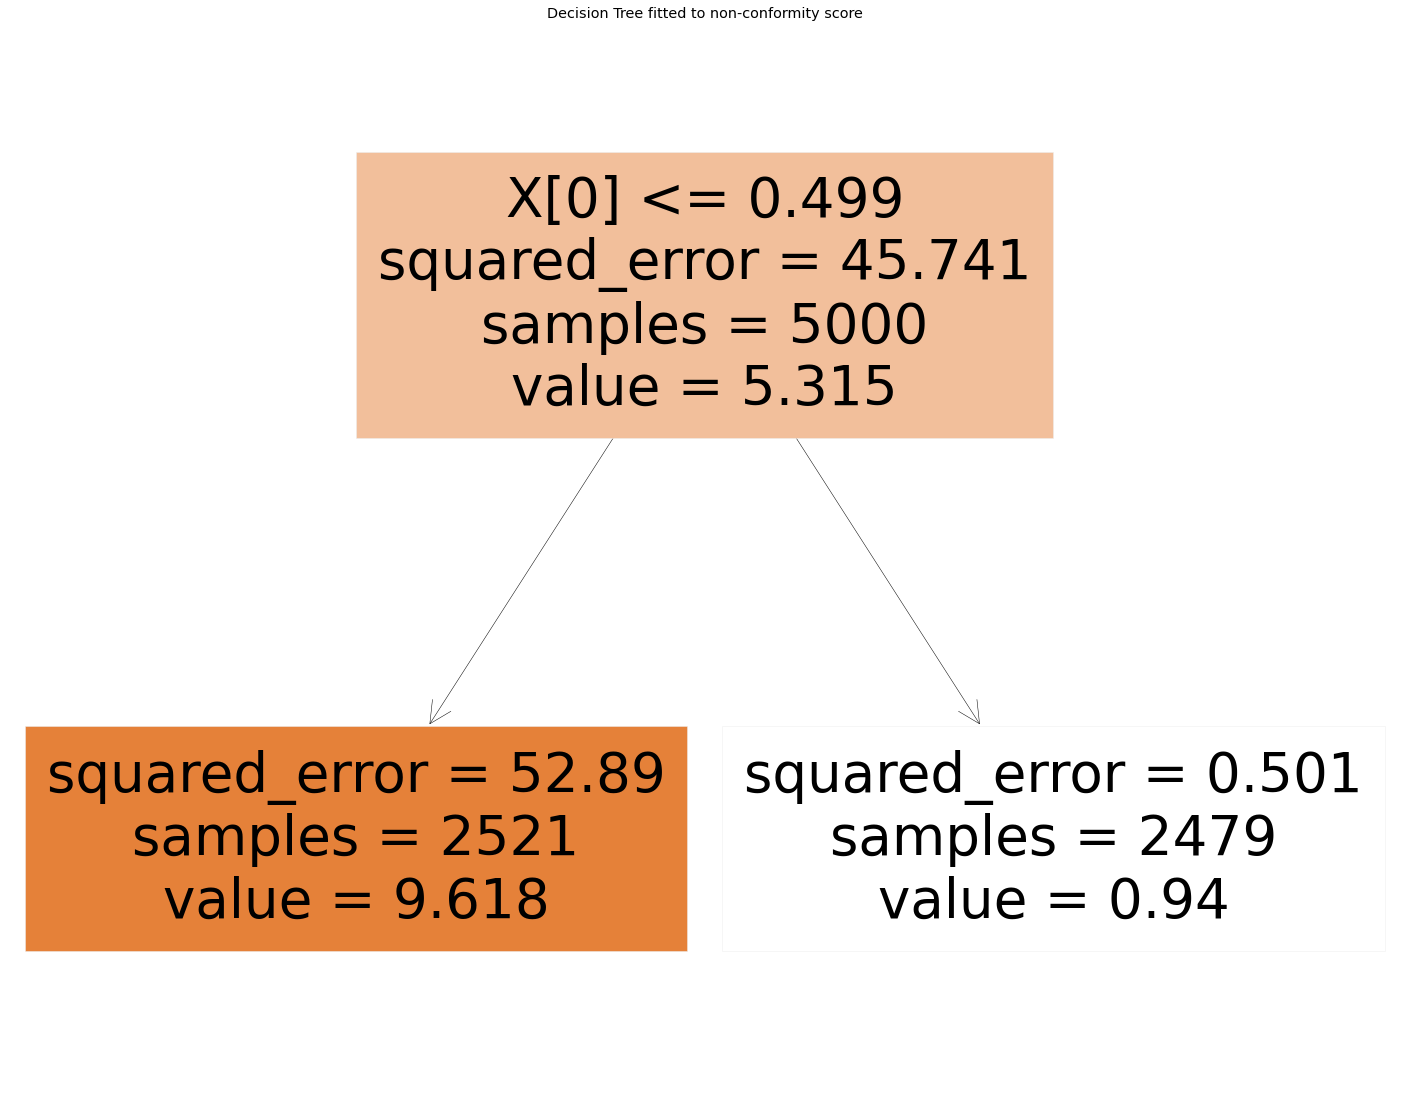

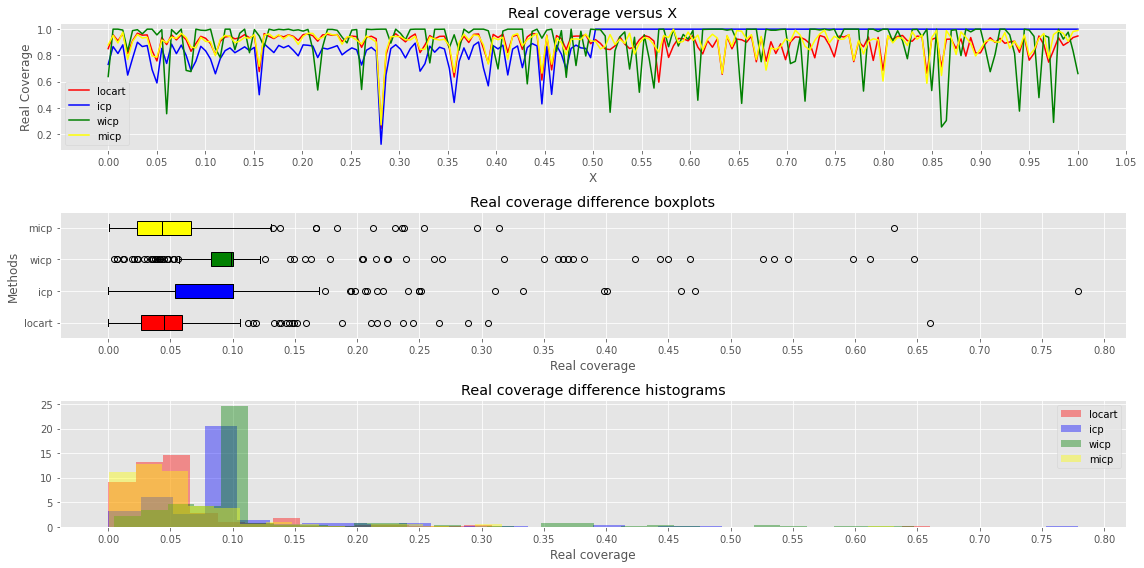

In [8]:
toy = run_toy_example(random_seed = 950, random_state = 650, prop_k = 100, nbins = 10, valid_test_size=0.5)

In [9]:
toy

Methods  Pearson correlation  HSIC correlation  \
0                     LOCART             0.033284      5.264211e-05   
1            Regresion split             0.034835      4.821033e-19   
2  Weighted regression split             0.188381      7.890396e-04   
3  Mondrian regression split             0.004420      2.111458e-05   

  clustering coverage  valid pred set  Average marginal coverage  \
0         (0.83, 100)        0.035664                     0.8972   
1         (0.26, 100)        0.096305                     0.9010   
2         (0.71, 100)        0.040559                     0.8938   
3         (0.86, 100)        0.039946                     0.8926   

   Average interval length  Average interval length given coverage  \
0                22.347856                               22.554544   
1                30.873359                               30.873359   
2                31.732902                               33.898497   
3                22.039432                               22.067184   

   Average distance  Median distance  Max distance  
0          0.053085            0.043         0.774  
1          0.100757            0.100         0.720  
2          0.118065            0.098         0.804  
3          0.054617            0.040         0.761

Increasing $\sigma_2$:

Fitting locart to toy example:
Time Elapsed to fit Locart:  6.191126346588135
Computing metrics
Time Elapsed to compute metrics for Locart:  252.85352635383606
Fitting regression split
Time Elapsed to fit regression split:  6.0604565143585205
Computing metrics
Time Elapsed to compute statistics for regression split:  20.794936895370483
Fitting weighted regression split
Time Elapsed to fit weighted regression split:  7.886545419692993
Computing metrics
Time Elapsed to compute statistics for weighted regression split:  7.886545419692993
Fitting mondrian regression split
Time Elapsed to fit mondrian regression split:  6.401115655899048
Computing metrics


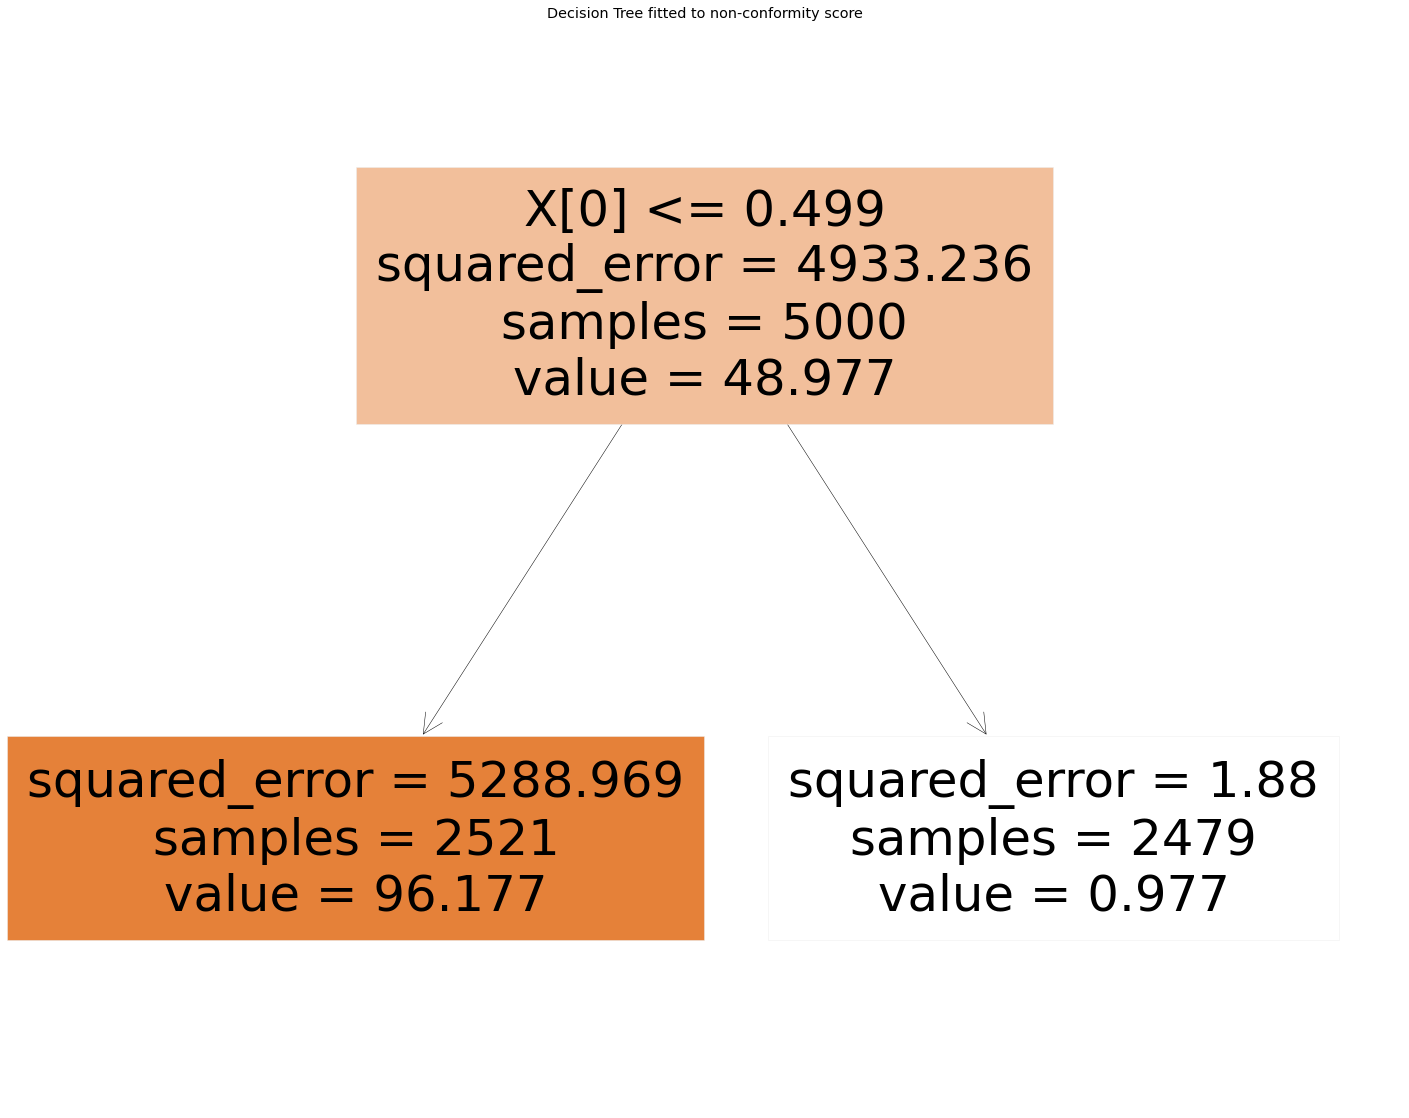

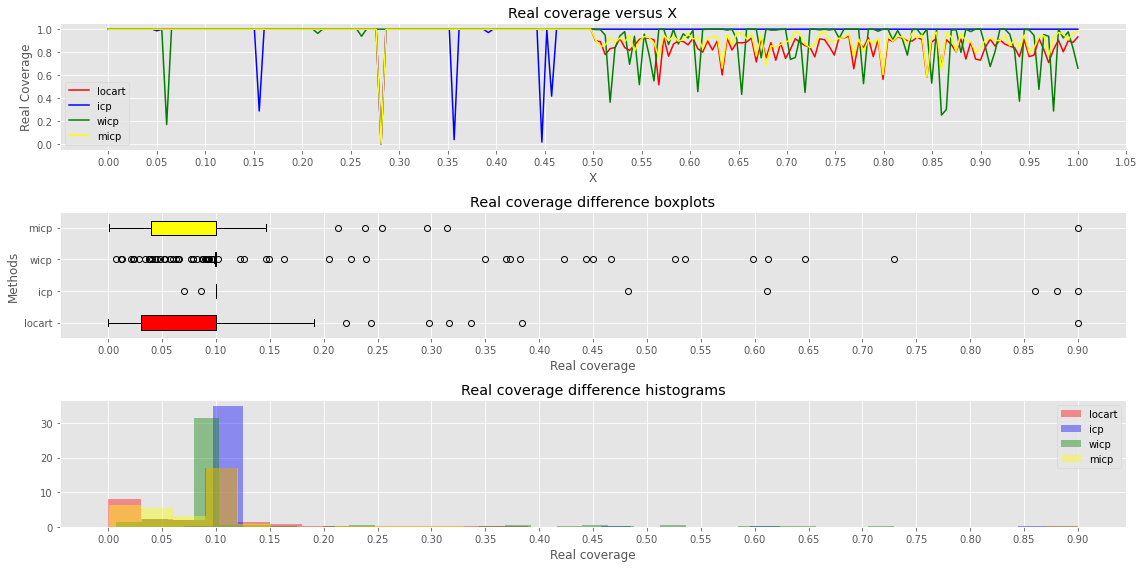

In [43]:
toy = run_toy_example(sigma_2 = 100, random_seed = 950, random_state = 650, prop_k = 100)

In [44]:
toy

Methods  Pearson correlation  HSIC correlation  \
0                     LOCART             0.077684      3.013294e-04   
1            Regresion split            -0.001574      4.391138e-16   
2  Weighted regression split             0.166207      7.442518e-04   
3  Mondrian regression split             0.013237      1.797316e-05   

  clustering coverage  valid pred set  Average marginal coverage  \
0          (0.8, 100)        0.044105                     0.8826   
1         (0.26, 100)        0.099694                     0.9010   
2         (0.71, 100)        0.051428                     0.8938   
3         (0.83, 100)        0.043992                     0.8894   

   Average interval length  Average interval length given coverage  \
0               205.748164                              211.442447   
1               308.731296                              308.731296   
2               292.906393                              313.103300   
3               201.839665                              202.770714   

   Average distance  Median distance  Max distance  
0          0.079260              0.1           0.9  
1          0.109890              0.1           0.9  
2          0.117150              0.1           0.9  
3          0.077482              0.1           0.9

Testing for homoscedastic, heteroscedastic and asymmetric:

Fitting locart to toy example:
Time Elapsed to fit Locart:  27.49153161048889
Computing metrics
Time Elapsed to compute metrics for Locart:  294.58465051651
Fitting regression split
Time Elapsed to fit regression split:  29.786333560943604
Computing metrics
Time Elapsed to compute statistics for regression split:  76.87898421287537
Fitting weighted regression split
Time Elapsed to fit weighted regression split:  44.21379733085632
Computing metrics
Time Elapsed to compute statistics for weighted regression split:  44.21379733085632
Fitting mondrian regression split
Time Elapsed to fit mondrian regression split:  27.61420440673828
Computing metrics


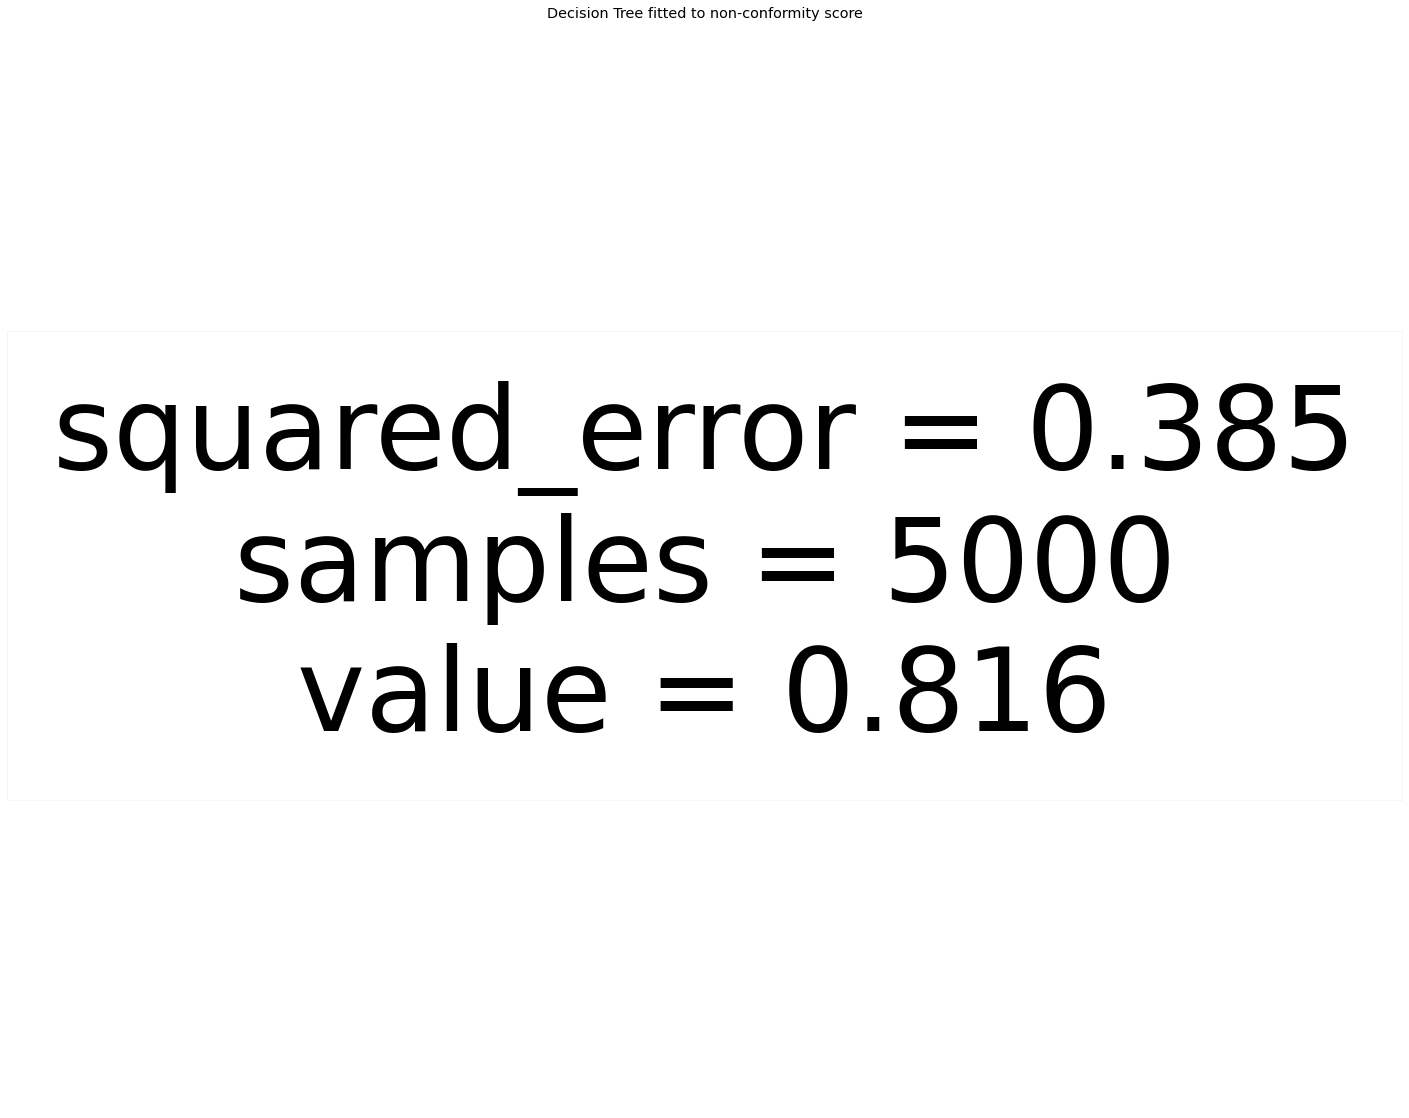

In [45]:
homoscedastic_toy = run_toy_example(toy = False, random_seed = 950, random_state = 650, prop_k = 100, valid_test_size=0.5)

In [46]:
homoscedastic_toy

Methods  Pearson correlation  HSIC correlation  \
0                     LOCART             0.006364      1.374372e-11   
1            Regresion split             0.000098     -3.010577e-19   
2  Weighted regression split             0.155261      2.220931e-04   
3  Mondrian regression split             0.018609      1.229002e-07   

  clustering coverage  valid pred set  Average marginal coverage  \
0         (0.87, 100)        0.057985                     0.9040   
1         (0.86, 100)        0.057197                     0.9068   
2         (0.79, 100)        0.063958                     0.9052   
3         (0.84, 100)        0.060599                     0.9050   

   Average interval length  Average interval length given coverage  \
0                 3.354427                                3.354431   
1                 3.383897                                3.383897   
2                 3.460100                                3.484747   
3                 3.357731                                3.358168   

   Average distance  Median distance  Max distance  
0          0.010325            0.008         0.182  
1          0.010688            0.009         0.171  
2          0.038447            0.033         0.213  
3          0.011947            0.010         0.174

Fitting locart to toy example:
Time Elapsed to fit Locart:  27.643733978271484
Computing metrics
Time Elapsed to compute metrics for Locart:  292.12983202934265
Fitting regression split
Time Elapsed to fit regression split:  27.82439637184143
Computing metrics
Time Elapsed to compute statistics for regression split:  64.76077318191528
Fitting weighted regression split
Time Elapsed to fit weighted regression split:  39.83830690383911
Computing metrics
Time Elapsed to compute statistics for weighted regression split:  39.83830690383911
Fitting mondrian regression split
Time Elapsed to fit mondrian regression split:  27.70376229286194
Computing metrics


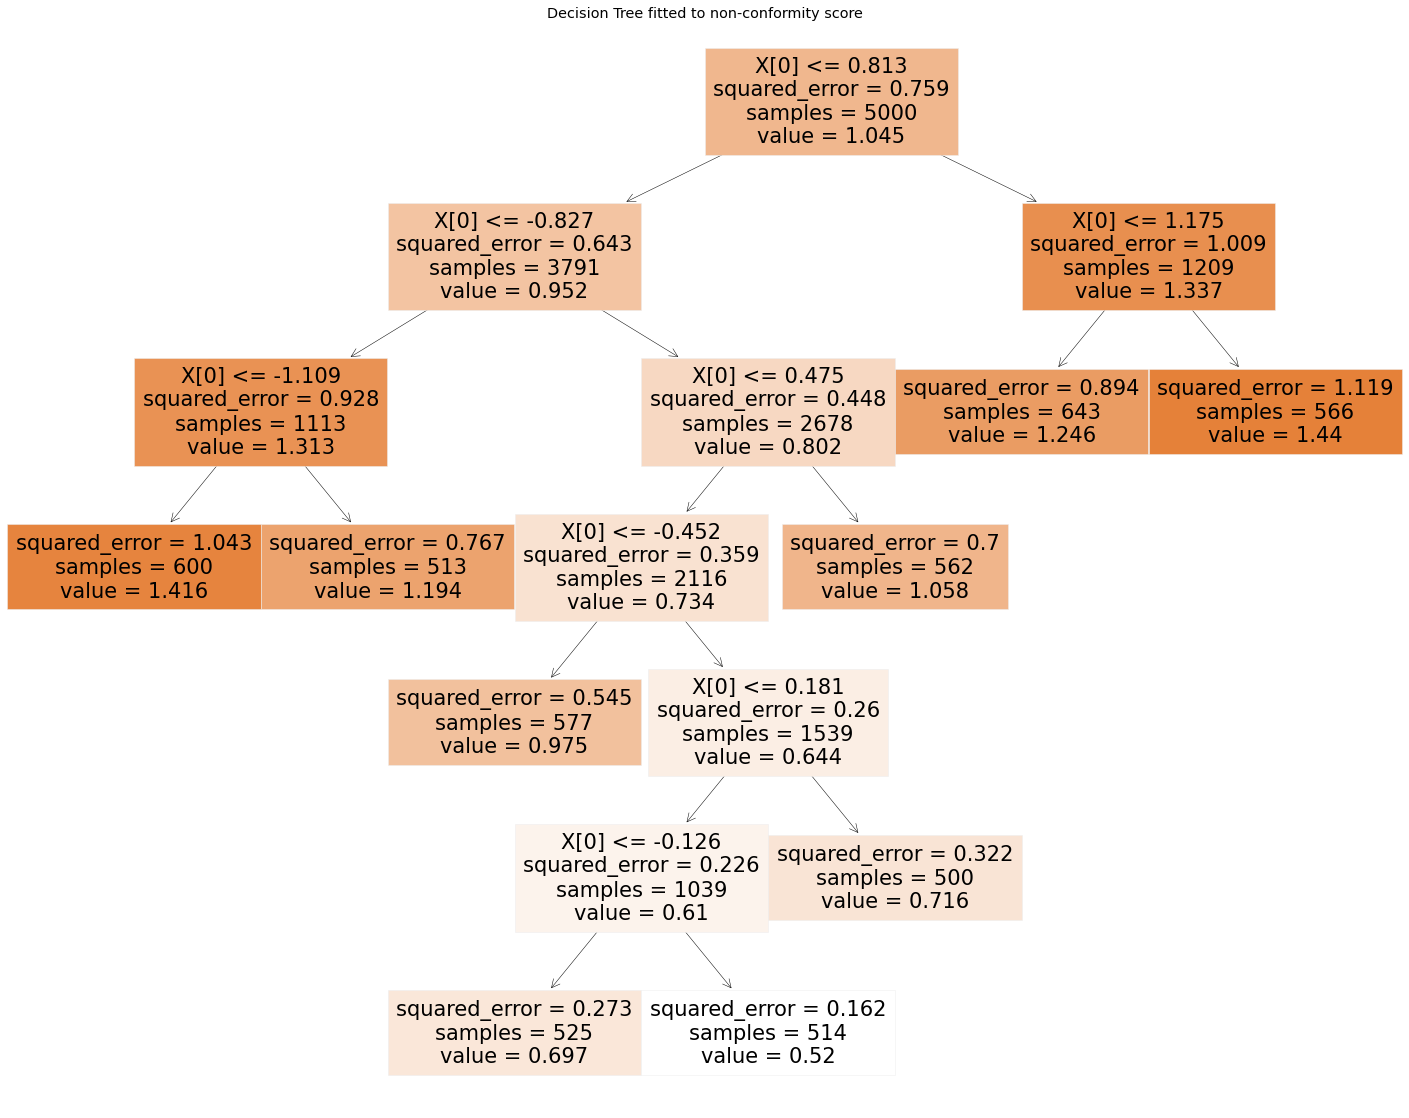

In [47]:
heteroscedastic_toy = run_toy_example(toy = False, kind = "heteroscedastic", hetero_value = 0.25, random_seed = 950, random_state = 650, prop_k = 100, 
valid_test_size = 0.5)

In [48]:
heteroscedastic_toy

Methods  Pearson correlation  HSIC correlation  \
0                     LOCART         1.505584e-02      1.456721e-05   
1            Regresion split        -1.852887e-16     -2.952912e-19   
2  Weighted regression split         1.010871e-01      1.299018e-04   
3  Mondrian regression split         3.243637e-02      3.933087e-05   

  clustering coverage  valid pred set  Average marginal coverage  \
0         (0.87, 100)        0.053519                     0.8996   
1          (0.8, 100)        0.074359                     0.9090   
2         (0.84, 100)        0.065004                     0.9018   
3         (0.88, 100)        0.054257                     0.9042   

   Average interval length  Average interval length given coverage  \
0                 4.298498                                4.304312   
1                 4.525842                                4.525842   
2                 4.458923                                4.509242   
3                 4.296545                                4.308787   

   Average distance  Median distance  Max distance  
0          0.024191           0.0190         0.153  
1          0.063964           0.0680         0.240  
2          0.047827           0.0415         0.308  
3          0.033272           0.0280         0.229

Fitting locart to toy example:
Time Elapsed to fit Locart:  32.806400775909424
Computing metrics
Time Elapsed to compute metrics for Locart:  280.32233715057373
Fitting regression split
Time Elapsed to fit regression split:  32.72472167015076
Computing metrics
Time Elapsed to compute statistics for regression split:  67.90699291229248
Fitting weighted regression split
Time Elapsed to fit weighted regression split:  48.4504177570343
Computing metrics
Time Elapsed to compute statistics for weighted regression split:  48.4504177570343
Fitting mondrian regression split
Time Elapsed to fit mondrian regression split:  33.346131801605225
Computing metrics


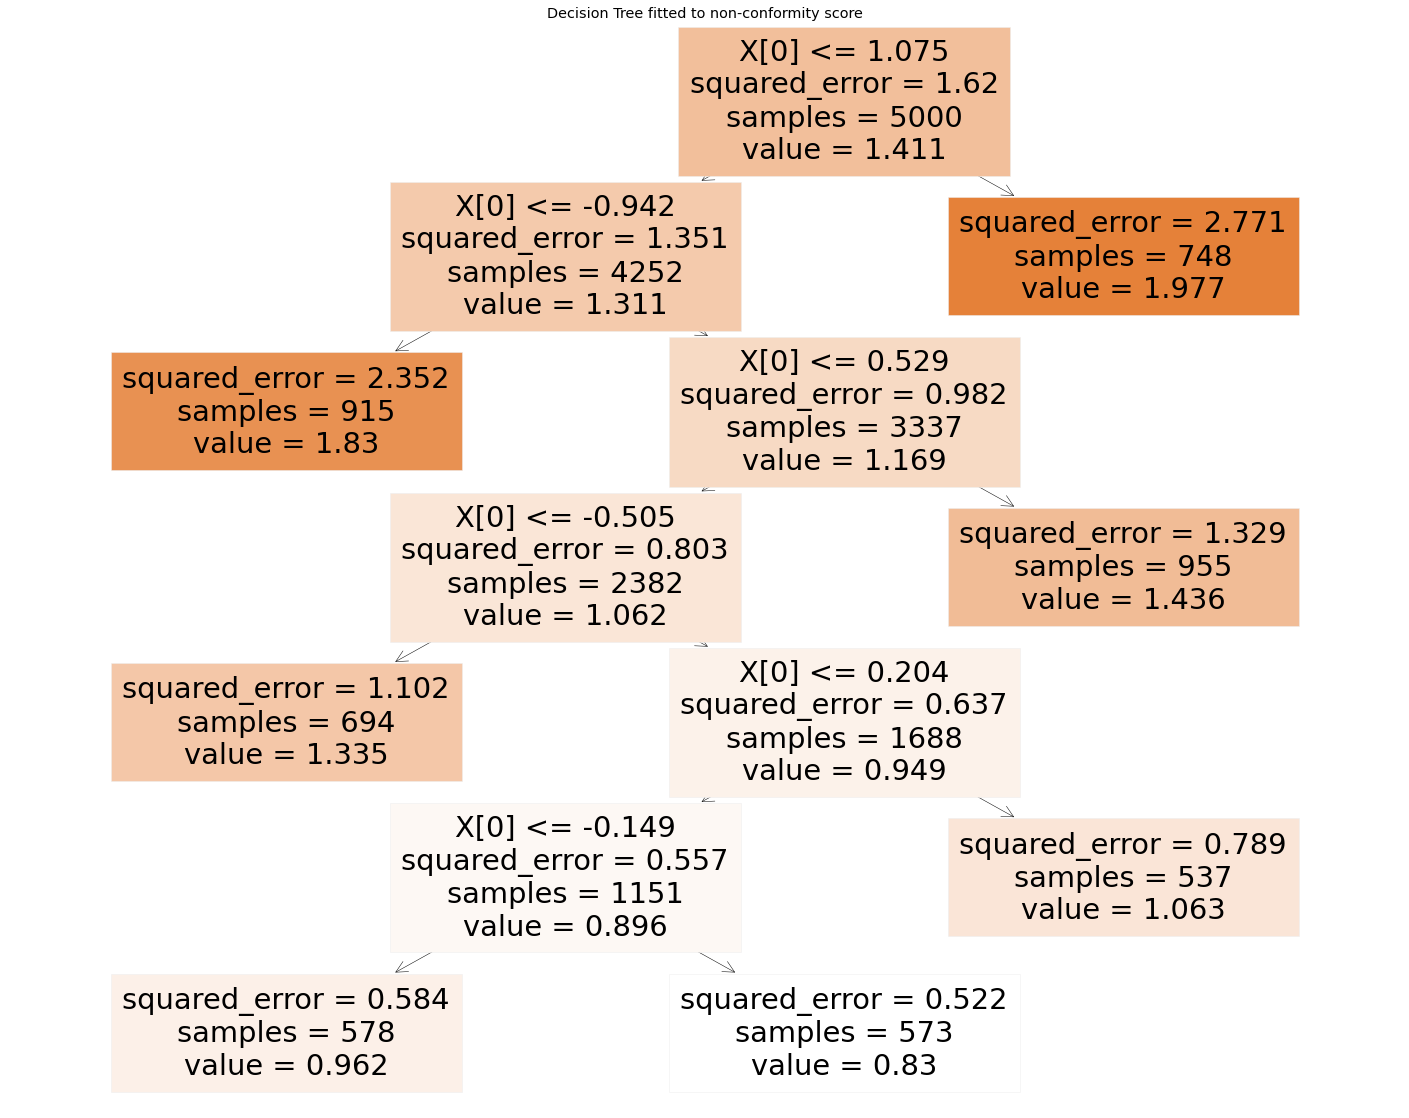

In [49]:
asym_toy = run_toy_example(toy = False, kind = "asymmetric", asym_value = 0.6, random_seed = 950, random_state = 650, prop_k = 100, 
valid_test_size = 0.5)

In [50]:
asym_toy

Methods  Pearson correlation  HSIC correlation  \
0                     LOCART            -0.010723      4.931826e-06   
1            Regresion split            -0.011489      7.809419e-20   
2  Weighted regression split             0.073083      5.684264e-05   
3  Mondrian regression split            -0.006851      1.614728e-05   

  clustering coverage  valid pred set  Average marginal coverage  \
0         (0.86, 100)        0.056865                     0.8986   
1         (0.84, 100)        0.069346                     0.8996   
2         (0.91, 100)        0.055490                     0.8988   
3         (0.87, 100)        0.053986                     0.9046   

   Average interval length  Average interval length given coverage  \
0                 5.139204                                5.134657   
1                 5.525249                                5.525249   
2                 5.327311                                5.370690   
3                 5.089584                                5.087222   

   Average distance  Median distance  Max distance  
0          0.030609            0.021         0.738  
1          0.059722            0.052         0.769  
2          0.044377            0.034         0.658  
3          0.040338            0.033         0.730

Fitting locart to toy example:
Time Elapsed to fit Locart:  30.631530284881592
Computing metrics
Time Elapsed to compute metrics for Locart:  276.17530488967896
Fitting regression split
Time Elapsed to fit regression split:  31.406673192977905
Computing metrics
Time Elapsed to compute statistics for regression split:  70.40939140319824
Fitting weighted regression split
Time Elapsed to fit weighted regression split:  46.93135976791382
Computing metrics
Time Elapsed to compute statistics for weighted regression split:  46.93135976791382
Fitting mondrian regression split
Time Elapsed to fit mondrian regression split:  31.71004343032837
Computing metrics


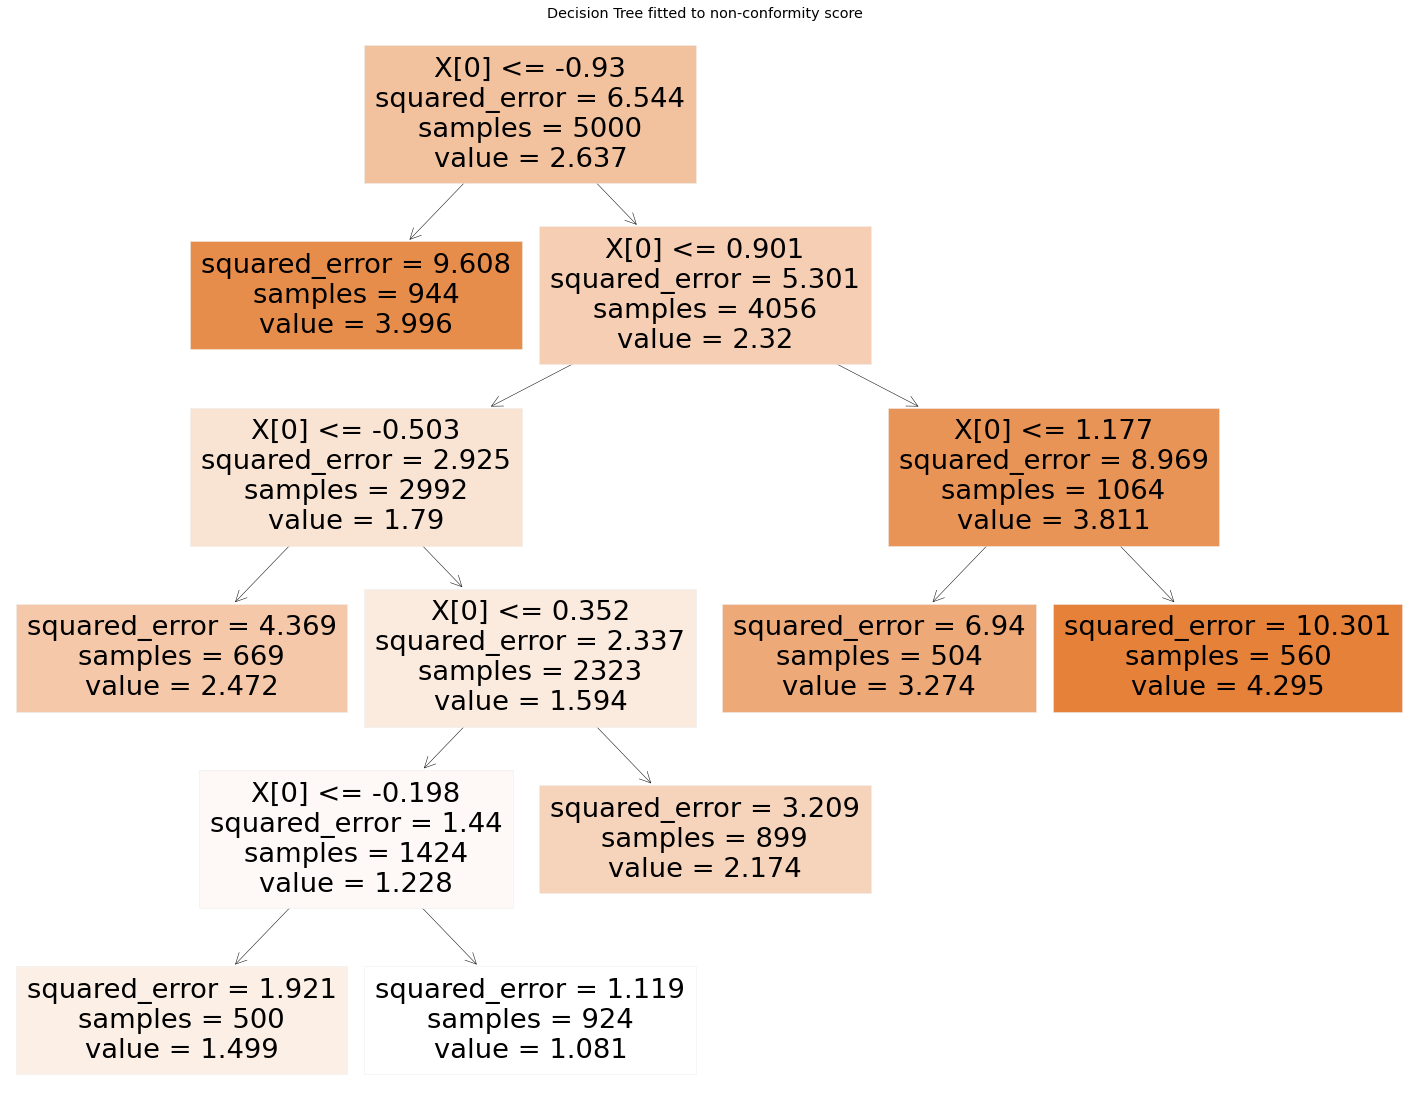

In [51]:
asym_toy_v2 = run_toy_example(toy = False, kind = "asymmetric", asym_value = 1.5, random_seed = 950, random_state = 650, prop_k = 100, 
valid_test_size = 0.5)

In [52]:
asym_toy_v2

Methods  Pearson correlation  HSIC correlation  \
0                     LOCART             0.005495      6.065342e-06   
1            Regresion split            -0.009095      1.394633e-17   
2  Weighted regression split             0.058172      3.436553e-05   
3  Mondrian regression split             0.018718      1.417300e-05   

  clustering coverage  valid pred set  Average marginal coverage  \
0         (0.89, 100)        0.054956                     0.9004   
1         (0.86, 100)        0.093490                     0.9038   
2         (0.87, 100)        0.058253                     0.8972   
3         (0.88, 100)        0.059357                     0.9008   

   Average interval length  Average interval length given coverage  \
0                 9.918289                                9.926398   
1                11.556882                               11.556882   
2                10.132961                               10.236018   
3                 9.660899                                9.688023   

   Average distance  Median distance  Max distance  
0          0.042217            0.033         0.496  
1          0.088958            0.084         0.653  
2          0.047347            0.036         0.485  
3          0.041247            0.033         0.476

Fitting locart to toy example:
Time Elapsed to fit Locart:  42.93640470504761
Computing metrics
Time Elapsed to compute metrics for Locart:  278.24619364738464
Fitting regression split
Time Elapsed to fit regression split:  42.818095207214355
Computing metrics
Time Elapsed to compute statistics for regression split:  65.45397233963013
Fitting weighted regression split
Time Elapsed to fit weighted regression split:  55.754947662353516
Computing metrics
Time Elapsed to compute statistics for weighted regression split:  55.754947662353516
Fitting mondrian regression split
Time Elapsed to fit mondrian regression split:  42.95164728164673
Computing metrics


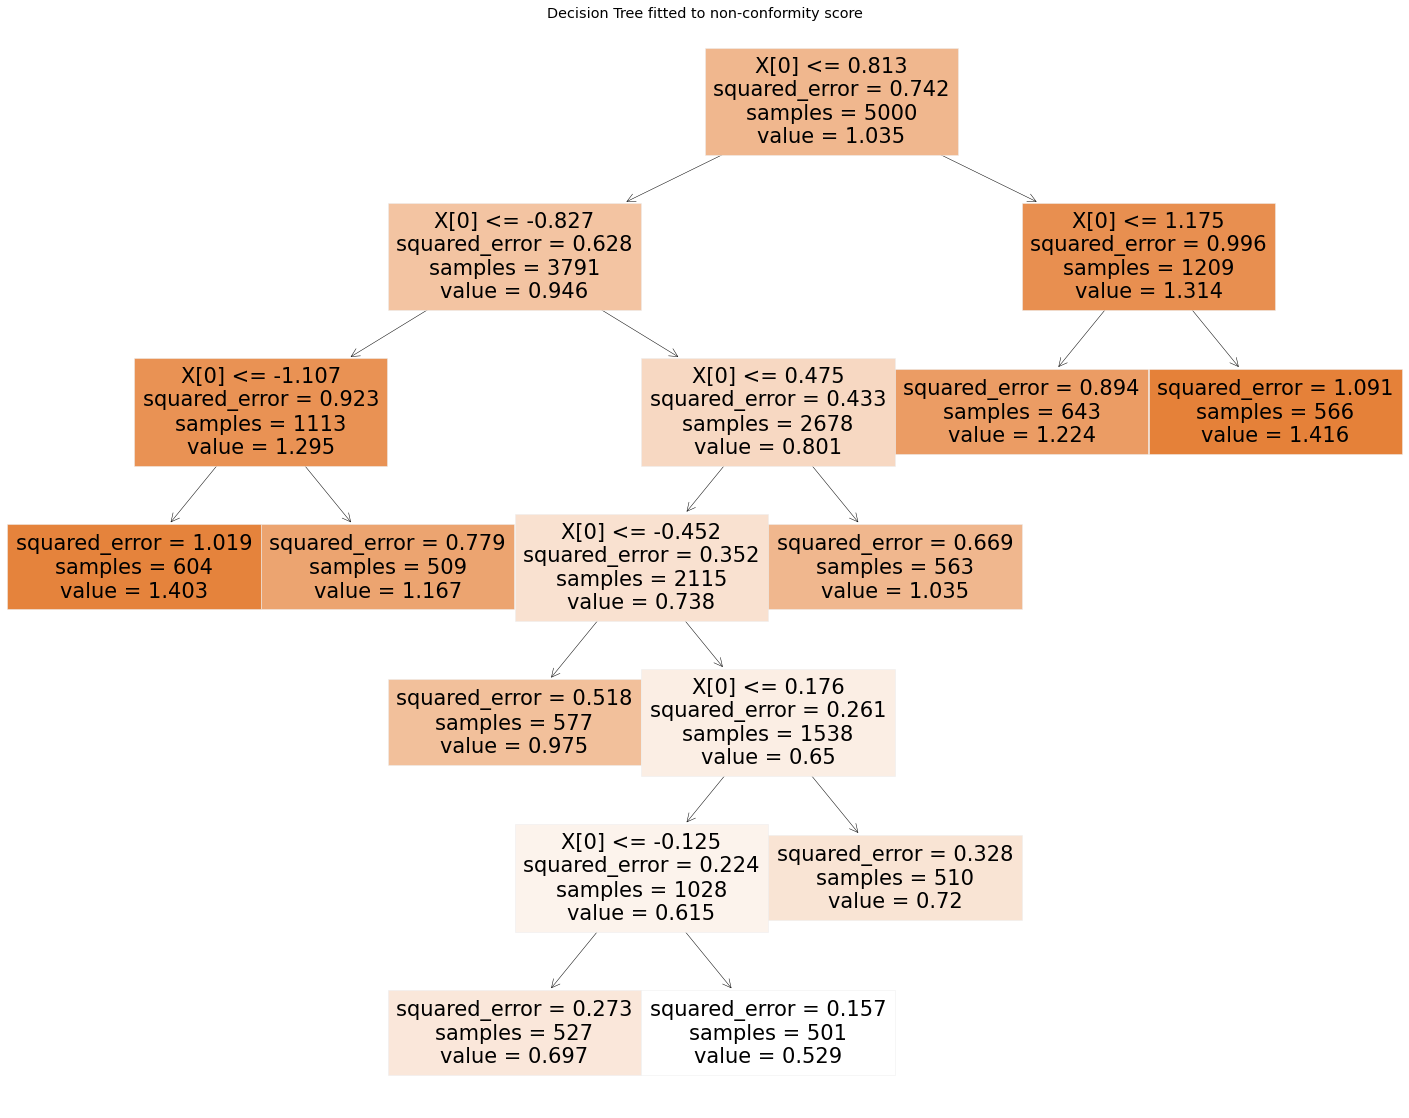

In [53]:
hetero_non_corr_toy = run_toy_example(toy = False, kind = "non_cor_heteroscedastic", hetero_value = 0.25, random_seed = 950, random_state = 650, prop_k = 100, 
valid_test_size = 0.5)

In [54]:
hetero_non_corr_toy

Methods  Pearson correlation  HSIC correlation  \
0                     LOCART             0.021591      2.158938e-05   
1            Regresion split             0.006282     -2.923542e-19   
2  Weighted regression split             0.100427      1.338895e-04   
3  Mondrian regression split             0.005083      4.008057e-06   

  clustering coverage  valid pred set  Average marginal coverage  \
0         (0.89, 100)        0.061868                     0.9012   
1         (0.82, 100)        0.074577                     0.9102   
2         (0.88, 100)        0.061888                     0.9008   
3         (0.86, 100)        0.069507                     0.9066   

   Average interval length  Average interval length given coverage  \
0                 4.265659                                4.273794   
1                 4.509857                                4.509857   
2                 4.411510                                4.460746   
3                 4.291870                                4.293253   

   Average distance  Median distance  Max distance  
0          0.024064            0.019         0.136  
1          0.063117            0.068         0.207  
2          0.048219            0.041         0.286  
3          0.047235            0.039         0.250

We see that even our proposed metric is having problem to converge to the real distance from conditional coverage. We can do some tests and see how our metric behaves when we increase $k$:

In [55]:
def test_k_means(
    ks = np.array([10, 25, 50, 75, 100, 150, 175, 200, 225, 250]),
    n = 25000,
    base_model = RandomForestRegressor, 
    sig = 0.1, 
    test_size = 0.2, 
    calib_size = 0.5, 
    coef = 2, 
    sigma_1 = 1, 
    sigma_2 = 10, 
    random_seed = 1250,
    split_calib = True,
    plot_tree = True,
    criterion = "squared_error",
    max_depth = None,
    max_leaf_nodes = None,
    min_samples_leaf = 500,
    prune = True,
    **kwargs):

    # simulating toy data
    data = simulate_toy(n, test_size, calib_size, coef, sigma_1, sigma_2, random_seed)
    data_list = []
    # fitting locart
    locart_obj = LocartSplit(nc_score = RegressionScore, base_model = base_model, alpha = sig, split_calib = split_calib, **kwargs)
    locart_obj.fit(data["X_train"], data["y_train"])
    locart_obj.calib(data["X_calib"], data["y_calib"], max_depth = max_depth, 
    max_leaf_nodes = max_leaf_nodes, min_samples_leaf = min_samples_leaf, criterion = criterion, prune_tree = prune)

    # predictions
    locart_pred = np.array(locart_obj.predict(data["X_test"], length = 2000))

    model = base_model(**kwargs)
    nc = NcFactory.create_nc(model)
    icp = IcpRegressor(nc)
    icp.fit(data["X_train"], data["y_train"])
    icp.calibrate(data["X_calib"], data["y_calib"])

    # predictions
    icp_pred = icp.predict(data["X_test"], significance = sig)

    # fitting wighted regression split
    wicp = LocalRegressionSplit(base_model, alpha = sig, **kwargs)
    wicp.fit(data["X_train"], data["y_train"])
    wicp.calibrate(data["X_calib"], data["y_calib"])

    # predictions
    wicp_pred = wicp.predict(data["X_test"])


    for k in ks:
        print("Running experiment for k = {}".format(k))
        locart_clust_cov, locart_clust_array = clustering_coverage(data["X_test"], data["y_test"], locart_pred, alpha = sig, prop_k = k, tune_k = False)

        icp_clust_cov, icp_clust_array = clustering_coverage(data["X_test"], data["y_test"], icp_pred, alpha = sig, prop_k = k, tune_k = False)
        
        wicp_clust_cov, wicp_clust_array = clustering_coverage(data["X_test"], data["y_test"], wicp_pred, alpha = sig, prop_k = k, tune_k = False)

        temp_data = pd.DataFrame(data = {"Methods": np.tile(["Locart", "ICP", "WICP"], k),
        "diff": np.concatenate((locart_clust_array, icp_clust_array, wicp_clust_array)),
        }).assign(num_k = str(k))
        data_list.append(temp_data)
    
    # transforming everything in a data frame
    all_data = pd.concat(data_list, axis = 0)

    # plotting using seaborn
    plt.figure(figsize=(25,20))
    p = sns.swarmplot(data = all_data, y = "diff", x = "num_k", hue = "Methods", dodge=True, size = 3)
    sns.boxplot(showmeans=True,
            meanline=True,
            meanprops={'color': 'k', 'ls': '-', 'lw': 2},
            medianprops={'visible': False},
            whiskerprops={'visible': False},
            zorder=10,
            y= "diff",
            x= "num_k",
            hue = "Methods",
            data = all_data,
            showfliers=False,
            showbox=False,
            showcaps=False,
            ax=p)
    plt.xlabel("Absolute difference from coverage")
    plt.ylabel("Chosen K")
    plt.show()

    return(all_data)

Running experiment for k = 10
Running experiment for k = 25
Running experiment for k = 50
Running experiment for k = 75
Running experiment for k = 100
Running experiment for k = 150
Running experiment for k = 175
Running experiment for k = 200
Running experiment for k = 225
Running experiment for k = 250


/home/kuben/anaconda3/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 8.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/kuben/anaconda3/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 11.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/kuben/anaconda3/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 15.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/kuben/anaconda3/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 14.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/kuben/anaconda3/lib/python3.9/site-packages/seaborn/categorical.py:1296

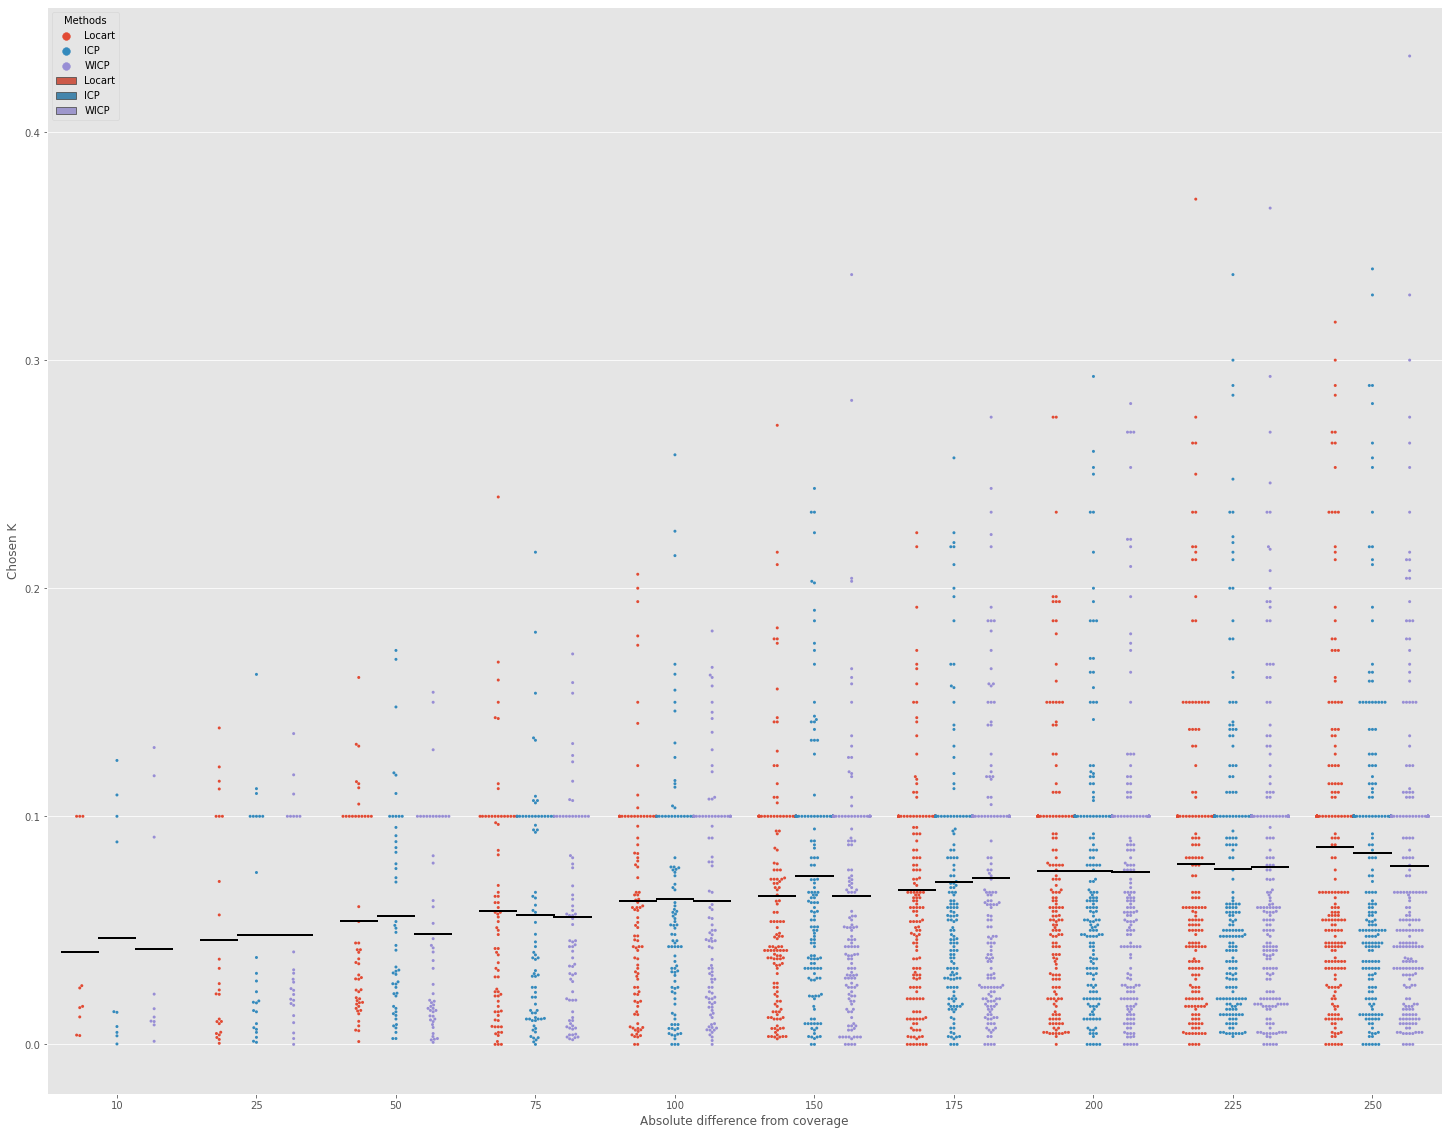

In [56]:
test = test_k_means()

Testing K-means CI coverage metric for different values of $k$ and for $\sigma_2 = 100$

In [57]:
def test_k_means_CI(
    ks = np.array([5, 6, 7, 8, 9, 10, 15, 20, 25, 30, 50, 60, 65, 70, 75, 90, 100, 110, 115, 125, 150, 175, 190, 200, 225, 
    250, 275, 300]),
    n = 25000,
    toy = True,
    kind = "homoscedastic",
    d = 20, 
    hetero_value = 1,
    asym_value = 0.6,
    t_degree = 4,
    base_model = RandomForestRegressor, 
    sig = 0.1, 
    test_size = 0.2, 
    calib_size = 0.5, 
    coef = 2, 
    sigma_1 = 1, 
    sigma_2 = 10, 
    random_seed = 1250,
    split_calib = True,
    plot_tree = True,
    criterion = "squared_error",
    max_depth = None,
    max_leaf_nodes = None,
    min_samples_leaf = 500,
    prune = True,
    min_sample = 100,
    **kwargs):

    # simulating toy data
    if toy:
        data = simulate_toy(n, test_size, calib_size, coef, sigma_1, sigma_2, random_seed)
    else:
        sim_obj = simulation(dim = d, coef = coef, hetero_value = hetero_value, asym_value = asym_value, t_degree = t_degree)
        sim_kind = getattr(sim_obj, kind)
        sim_kind(n, random_seed = random_seed)
        data = split(sim_obj.X, sim_obj.y, test_size = test_size, calib_size = calib_size, calibrate = True, random_seed = random_seed)

    print("Running models")
    # fitting locart
    locart_obj = LocartSplit(nc_score = RegressionScore, base_model = base_model, alpha = sig, split_calib = split_calib, **kwargs)
    locart_obj.fit(data["X_train"], data["y_train"])
    locart_obj.calib(data["X_calib"], data["y_calib"], max_depth = max_depth, 
    max_leaf_nodes = max_leaf_nodes, min_samples_leaf = min_samples_leaf, criterion = criterion, prune_tree = prune)

    # predictions
    locart_pred = np.array(locart_obj.predict(data["X_test"], length = 2000))

    model = base_model(**kwargs)
    nc = NcFactory.create_nc(model)
    icp = IcpRegressor(nc)
    icp.fit(data["X_train"], data["y_train"])
    icp.calibrate(data["X_calib"], data["y_calib"])

    # predictions
    icp_pred = icp.predict(data["X_test"], significance = sig)

    # fitting wighted regression split
    wicp = LocalRegressionSplit(base_model, alpha = sig, **kwargs)
    wicp.fit(data["X_train"], data["y_train"])
    wicp.calibrate(data["X_calib"], data["y_calib"])

    # predictions
    wicp_pred = wicp.predict(data["X_test"])

    # obtaining optimal k
    print("Obtaining optimal k")
    _, optim_k = clustering_CI_coverage(data["X_test"], data["y_test"], locart_pred, alpha = sig, prop_k = ks, tune_k = True, min = min_sample)

    print("Optimal k is: {}".format(optim_k))
    
    i = 0
    locart_clust_cov, icp_clust_cov, wicp_clust_cov = np.zeros(ks.shape[0]), np.zeros(ks.shape[0]), np.zeros(ks.shape[0])
    for k in ks:
        print("Running experiment for k = {}".format(k))
        locart_clust_cov[i], _ = clustering_CI_coverage(data["X_test"], data["y_test"], locart_pred, alpha = sig, prop_k = k, tune_k = False, min = min_sample)

        icp_clust_cov[i], _ = clustering_CI_coverage(data["X_test"], data["y_test"], icp_pred, alpha = sig, prop_k = k, tune_k = False, min = min_sample)
        
        wicp_clust_cov[i], _ = clustering_CI_coverage(data["X_test"], data["y_test"], wicp_pred, alpha = sig, prop_k = k, tune_k = False, min = min_sample)

        i += 1

    # plotting using seaborn
    plt.figure(figsize=(12,6))
    plt.plot(ks, locart_clust_cov, "-r", label = "locart")
    plt.plot(ks, icp_clust_cov, "-b", label = "icp")
    plt.plot(ks, wicp_clust_cov, "green", label = "wicp")
    plt.axvline(optim_k, linestyle = "dashed", color = "black", label = "Optimal K")
    plt.title("CI k-means coverage versus k value")
    plt.xlabel("k")
    plt.ylabel("k-means CI coverage")
    plt.legend(loc = "lower left")
    plt.show()

Testing for $\sigma_2 = 10$

Running models
Obtaining optimal k
Optimal k is: 110
Running experiment for k = 5
Running experiment for k = 6
Running experiment for k = 7
Running experiment for k = 8
Running experiment for k = 9
Running experiment for k = 10
Running experiment for k = 15
Running experiment for k = 20
Running experiment for k = 25
Running experiment for k = 30
Running experiment for k = 50
Running experiment for k = 60
Running experiment for k = 65
Running experiment for k = 70
Running experiment for k = 75
Running experiment for k = 90
Running experiment for k = 100
Running experiment for k = 110
Running experiment for k = 115
Running experiment for k = 125
Running experiment for k = 150
Running experiment for k = 175
Running experiment for k = 190
Running experiment for k = 200
Running experiment for k = 225
Running experiment for k = 250
Running experiment for k = 275
Running experiment for k = 300


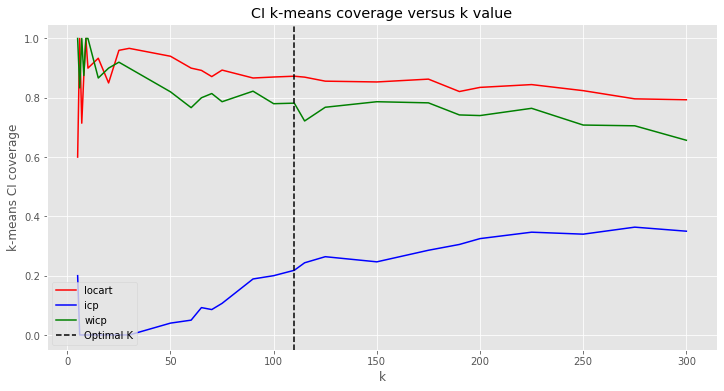

In [58]:
test_k_means_CI(min_sample = 25)

Now for $\sigma_2 = 100$

Running models
Obtaining optimal k
Optimal k is: 110
Running experiment for k = 5
Running experiment for k = 6
Running experiment for k = 7
Running experiment for k = 8
Running experiment for k = 9
Running experiment for k = 10
Running experiment for k = 15
Running experiment for k = 20
Running experiment for k = 25
Running experiment for k = 30
Running experiment for k = 50
Running experiment for k = 60
Running experiment for k = 65
Running experiment for k = 70
Running experiment for k = 75
Running experiment for k = 90
Running experiment for k = 100
Running experiment for k = 110
Running experiment for k = 115
Running experiment for k = 125
Running experiment for k = 150
Running experiment for k = 175
Running experiment for k = 190
Running experiment for k = 200
Running experiment for k = 225
Running experiment for k = 250
Running experiment for k = 275
Running experiment for k = 300


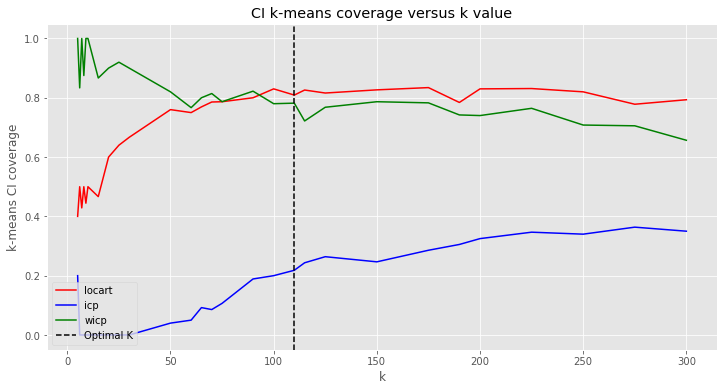

In [59]:
test_k_means_CI(sigma_2 = 100, min_sample = 25)

Testing for homoscedastic data:

Running models
Obtaining optimal k
Optimal k is: 115
Running experiment for k = 5
Running experiment for k = 6
Running experiment for k = 7
Running experiment for k = 8
Running experiment for k = 9
Running experiment for k = 10
Running experiment for k = 15
Running experiment for k = 20
Running experiment for k = 25
Running experiment for k = 30
Running experiment for k = 50
Running experiment for k = 60
Running experiment for k = 65
Running experiment for k = 70
Running experiment for k = 75
Running experiment for k = 90
Running experiment for k = 100
Running experiment for k = 110
Running experiment for k = 115
Running experiment for k = 125
Running experiment for k = 150
Running experiment for k = 175
Running experiment for k = 190
Running experiment for k = 200
Running experiment for k = 225
Running experiment for k = 250
Running experiment for k = 275
Running experiment for k = 300


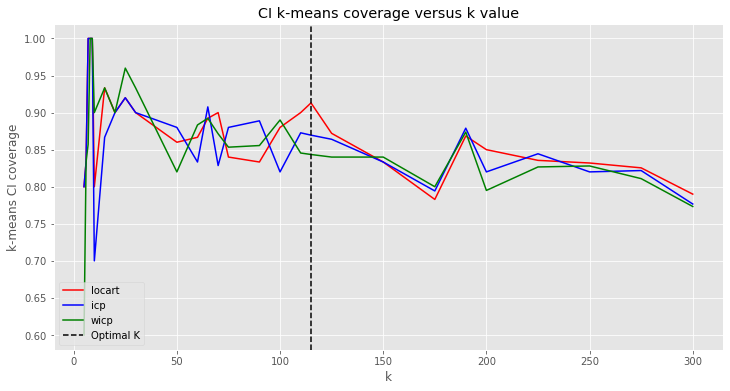

In [60]:
test_k_means_CI(toy = False, kind = "homoscedastic", min_sample = 25)

Heteroscedastic:

Running models
Obtaining optimal k
Optimal k is: 115
Running experiment for k = 5
Running experiment for k = 6
Running experiment for k = 7
Running experiment for k = 8
Running experiment for k = 9
Running experiment for k = 10
Running experiment for k = 15
Running experiment for k = 20
Running experiment for k = 25
Running experiment for k = 30
Running experiment for k = 50
Running experiment for k = 60
Running experiment for k = 65
Running experiment for k = 70
Running experiment for k = 75
Running experiment for k = 90
Running experiment for k = 100
Running experiment for k = 110
Running experiment for k = 115
Running experiment for k = 125
Running experiment for k = 150
Running experiment for k = 175
Running experiment for k = 190
Running experiment for k = 200
Running experiment for k = 225
Running experiment for k = 250
Running experiment for k = 275
Running experiment for k = 300


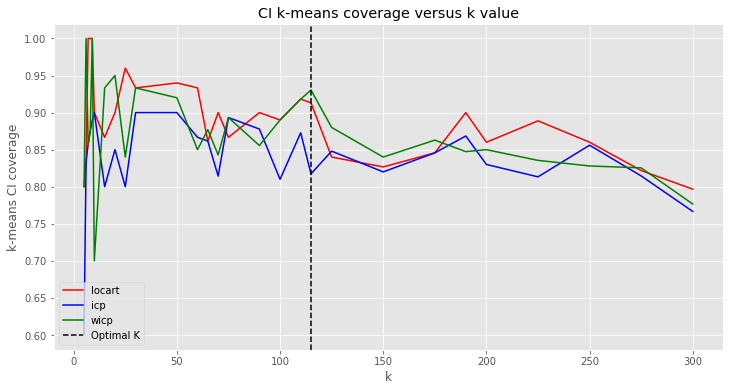

In [61]:
test_k_means_CI(toy = False, kind = "heteroscedastic", hetero_value = 0.25, min_sample = 25)

Assymetric:

In [62]:
test_k_means_CI(toy = False, kind = "asymmetric", asym_value = 0.6, min_sample = 25)

Running models
Obtaining optimal k
Optimal k is: 115
Running experiment for k = 5
Running experiment for k = 6
Running experiment for k = 7
Running experiment for k = 8
Running experiment for k = 9
Running experiment for k = 10
Running experiment for k = 15
Running experiment for k = 20
Running experiment for k = 25
Running experiment for k = 30
Running experiment for k = 50
Running experiment for k = 60
Running experiment for k = 65
Running experiment for k = 70
Running experiment for k = 75
Running experiment for k = 90
Running experiment for k = 100
Running experiment for k = 110
Running experiment for k = 115
Running experiment for k = 125
Running experiment for k = 150
Running experiment for k = 175
Running experiment for k = 190
Running experiment for k = 200
Running experiment for k = 225
Running experiment for k = 250
Running experiment for k = 275
Running experiment for k = 300


Running models
Obtaining optimal k
Optimal k is: 115
Running experiment for k = 5
Running experiment for k = 6
Running experiment for k = 7
Running experiment for k = 8
Running experiment for k = 9
Running experiment for k = 10
Running experiment for k = 15
Running experiment for k = 20
Running experiment for k = 25
Running experiment for k = 30
Running experiment for k = 50
Running experiment for k = 60
Running experiment for k = 65
Running experiment for k = 70
Running experiment for k = 75
Running experiment for k = 90
Running experiment for k = 100
Running experiment for k = 110
Running experiment for k = 115
Running experiment for k = 125
Running experiment for k = 150
Running experiment for k = 175
Running experiment for k = 190
Running experiment for k = 200
Running experiment for k = 225
Running experiment for k = 250
Running experiment for k = 275
Running experiment for k = 300


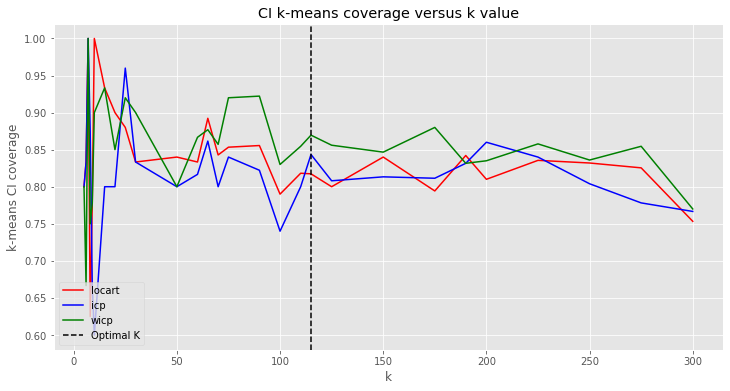

In [ ]:
test_k_means_CI(toy = False, kind = "asymmetric", asym_value = 1.5, min_sample = 25)

## Testing metrics for real data:

Testing main regression splits in some real data:

In [ ]:
def obtain_main_metrics(data_name,
type_score = "regression",
base_model = RandomForestRegressor,
figname_tree = "locart_tree_real_data.pdf",
test_size = 0.4, 
calib_size = 0.5,
random_seed = 1250, 
sig = 0.05,
split_calib = True,
plot_tree = True,
n_estimators = 200,
quantiles = [0.8, 0.85, 0.9, 0.95],
random_states = [750, 85, 666, 69],
prop_k = np.arange(2, 11),
tune_k = True,
nbins = 20,
criterion = "squared_error",
max_depth = None,
max_leaf_nodes = None,
min_samples_leaf = 300,
prune = True,
**kwargs):
    # importing data, selecting some rows and then splitting
    data_path = os.path.normpath(os.getcwd() + os.sep + os.pardir) + "/data/processed/" + data_name + ".csv"

    # reading data using pandas
    data = pd.read_csv(data_path)
    y = data["target"].to_numpy()
    X = (data.
    drop("target", axis = 1).
    to_numpy())

    # splitting data into train, calibration and test
    data = split(X, y, test_size, calib_size, calibrate = True, random_seed = random_seed)
    # setting seed
    np.random.seed(random_seed)

    if type_score == "regression":
        # fitting mondrian regression split
        print("Fitting mondrian regression split")
        start_mondrian_split = time.time()
        micp = MondrianRegressionSplit(base_model, alpha = sig, k = nbins, **kwargs)
        micp.fit(data["X_train"], data["y_train"])
        micp.calibrate(data["X_calib"], data["y_calib"])

        end_mondrian_split = time.time() - start_mondrian_split
        print("Time Elapsed to fit mondrian regression split: ", end_mondrian_split)

        print("Computing metrics")
        start_mondrian_split = time.time()
        # predictions
        micp_pred = micp.predict(data["X_test"])

        # mondrian icp correlations 
        micp_pcor = pearson_correlation(micp_pred, data["y_test"])
        micp_hsic = HSIC_correlation(micp_pred, data["y_test"])

        # mondrian wsc
        micp_wsc = wsc_coverage(data["X_test"], data["y_test"], micp_pred)

        # mean interval length
        micp_interval_len = np.mean(compute_interval_length(micp_pred))


        # marginal coverage
        marg_cover = np.logical_and(data["y_test"] >= micp_pred[:, 0], 
            data["y_test"] <= micp_pred[:, 1]) + 0
        micp_ave_marginal_cov = np.mean(
            marg_cover
        )

        # interval length | coveraqe
        cover_idx = np.where(marg_cover == 1)
        micp_interval_len_cover = np.mean(compute_interval_length(micp_pred[cover_idx]))


        end_mondrian_split = time.time() - start_mondrian_split
        print("Time Elapsed to compute statistics for mondrian regression split: ", end_mondrian_split)

        print("Fitting locluster")
        start_locluster = time.time()
        locluster_obj = KmeansSplit(nc_score = RegressionScore, base_model = base_model, alpha = sig, **kwargs)
        locluster_obj.fit(data["X_train"], data["y_train"])
        locluster_obj.calib(data["X_calib"], data["y_calib"], tune_k = tune_k, 
        prop_k = prop_k, n_estimators = n_estimators, quantiles = quantiles, random_states = random_states)

        end_locluster = time.time() - start_locluster
        print("Time Elapsed to fit locluster: ", end_locluster)


        print("Computing metrics")
        start_locluster = time.time()
        # predictions
        locluster_pred = np.array(locluster_obj.predict(data["X_test"], length = 2000))

        # mondrian icp correlations 
        locluster_pcor = pearson_correlation(locluster_pred, data["y_test"])
        locluster_hsic = HSIC_correlation(locluster_pred, data["y_test"])

        # mondrian wsc
        locluster_wsc = wsc_coverage(data["X_test"], data["y_test"], locluster_pred)

        # mean interval length
        locluster_interval_len = np.mean(compute_interval_length(locluster_pred))

        # marginal coverage
        marg_cover = np.logical_and(data["y_test"] >= locluster_pred[:, 0], 
            data["y_test"] <= locluster_pred[:, 1]) + 0
        locluster_ave_marginal_cov = np.mean(
            marg_cover
        )

        # interval length | coveraqe
        cover_idx = np.where(marg_cover == 1)
        locluster_interval_len_cover = np.mean(compute_interval_length(locluster_pred[cover_idx]))

        end_locluster = time.time() - start_locluster
        print("Time Elapsed to compute metrics for Locluster: ", end_locluster)


        print("Fitting locart")
        start_loc = time.time()
        # fitting locart
        locart_obj = LocartSplit(nc_score = RegressionScore, base_model = base_model, alpha = sig, split_calib = split_calib, **kwargs)
        locart_obj.fit(data["X_train"], data["y_train"])
        locart_obj.calib(data["X_calib"], data["y_calib"], max_depth = max_depth, 
        max_leaf_nodes = max_leaf_nodes, min_samples_leaf = min_samples_leaf, criterion = criterion, prune_tree = prune)
        
        end_loc = time.time() - start_loc
        print("Time Elapsed to fit Locart: ", end_loc)

        print("Computing metrics")
        start_loc = time.time()
       # predictions
        locart_pred = np.array(locart_obj.predict(data["X_test"], length = 2000))

        # mondrian icp correlations 
        locart_pcor = pearson_correlation(locart_pred, data["y_test"])
        locart_hsic = HSIC_correlation(locart_pred, data["y_test"])

        # mondrian wsc
        locart_wsc = wsc_coverage(data["X_test"], data["y_test"], locart_pred)

        # mean interval length
        locart_interval_len = np.mean(compute_interval_length(locart_pred))

        # marginal coverage
        marg_cover = np.logical_and(data["y_test"] >= locart_pred[:, 0], 
            data["y_test"] <= locart_pred[:, 1]) + 0
        locart_ave_marginal_cov = np.mean(
            marg_cover
        )

        # interval length | coveraqe
        cover_idx = np.where(marg_cover == 1)
        locart_interval_len_cover = np.mean(compute_interval_length(locart_pred[cover_idx]))
        end_loc = time.time() - start_loc
        print("Time Elapsed to compute metrics for Locart: ", end_loc)

        # fitting default regression split
        print("Fitting regression split")
        start_split = time.time()
        model = base_model(**kwargs)
        nc = NcFactory.create_nc(model)
        icp = IcpRegressor(nc)
        icp.fit(data["X_train"], data["y_train"])
        icp.calibrate(data["X_calib"], data["y_calib"])

        end_split = time.time() - start_split
        print("Time Elapsed to fit regression split: ", end_split)

        print("Computing metrics")
        start_split = time.time()
        # predictions
        icp_pred = icp.predict(data["X_test"], significance = sig)

        # ICP icp correlations 
        icp_pcor = pearson_correlation(icp_pred, data["y_test"])
        icp_hsic = HSIC_correlation(icp_pred, data["y_test"])

        # ICP wsc
        icp_wsc = wsc_coverage(data["X_test"], data["y_test"], icp_pred)

        # ICP interval length
        icp_interval_len = np.mean(compute_interval_length(icp_pred))

       # marginal coverage
        marg_cover = np.logical_and(data["y_test"] >= icp_pred[:, 0], 
            data["y_test"] <= icp_pred[:, 1]) + 0
        icp_ave_marginal_cov = np.mean(
            marg_cover
        )

        # interval length | coveraqe
        cover_idx = np.where(marg_cover == 1)
        icp_interval_len_cover = np.mean(compute_interval_length(icp_pred[cover_idx]))

        end_split = time.time() - start_split
        print("Time Elapsed to compute statistics for regression split: ", end_split)

        # fitting wighted regression split
        print("Fitting weighted regression split")
        start_weighted_split = time.time()
        wicp = LocalRegressionSplit(base_model, alpha = sig, **kwargs)
        wicp.fit(data["X_train"], data["y_train"])
        wicp.calibrate(data["X_calib"], data["y_calib"])

        end_weighted_split = time.time() - start_weighted_split
        print("Time Elapsed to fit weighted regression split: ", end_weighted_split)

        print("Computing metrics")
        start_weighted_split = time.time()
        # predictions
        wicp_pred = wicp.predict(data["X_test"])

        # ICP icp correlations 
        wicp_pcor = pearson_correlation(wicp_pred, data["y_test"])
        wicp_hsic = HSIC_correlation(wicp_pred, data["y_test"])

        # ICP wsc
        wicp_wsc = wsc_coverage(data["X_test"], data["y_test"], wicp_pred)

        # ICP interval length
        wicp_interval_len = np.mean(compute_interval_length(wicp_pred))

        # marginal coverage
        marg_cover = np.logical_and(data["y_test"] >= wicp_pred[:, 0], 
            data["y_test"] <= wicp_pred[:, 1]) + 0
        wicp_ave_marginal_cov = np.mean(
            marg_cover
        )

        # interval length | coveraqe
        cover_idx = np.where(marg_cover == 1)
        wicp_interval_len_cover = np.mean(compute_interval_length(wicp_pred[cover_idx]))
        print("Time Elapsed to compute statistics for weighted regression split: ", end_weighted_split)

        # computing ils coverage of all methods compared to locart
        ils_locart_micp = ILS_coverage(locart_pred, micp_pred, data["y_test"])
        ils_locart_wicp = ILS_coverage(locart_pred, wicp_pred, data["y_test"])
        ils_locart_icp = ILS_coverage(locart_pred, icp_pred, data["y_test"])
        ils_locart_locluster = ILS_coverage(locart_pred, locluster_pred, data["y_test"])

        
        all_results =  pd.DataFrame(data = {"Methods":["LOCLUSTER", "LOCART", "Regresion split", "Weighted regression split", "Mondrian regression split"],
        "Pearson correlation":[locluster_pcor, locart_pcor,  icp_pcor, wicp_pcor, micp_pcor],
        "HSIC correlation":[locluster_hsic, locart_hsic, icp_hsic, wicp_hsic, micp_hsic],
        "delta wsc":[locluster_wsc, locart_wsc, icp_wsc, wicp_wsc, micp_wsc],
        "delta_ils":[ils_locart_locluster, 0, ils_locart_icp, ils_locart_wicp, ils_locart_micp],
        "Average marginal coverage":[locluster_ave_marginal_cov, locart_ave_marginal_cov, icp_ave_marginal_cov, wicp_ave_marginal_cov, micp_ave_marginal_cov],
        "Average interval length":[locluster_interval_len, locart_interval_len, icp_interval_len, wicp_interval_len, micp_interval_len],
        "Average interval length given coverage":[locluster_interval_len_cover, locart_interval_len_cover, icp_interval_len_cover,
        wicp_interval_len_cover, micp_interval_len_cover]})
    
    elif type_score == "quantile":
        # fitting gradient boosting quantile regression
        # first fitting quantile split
        print("Fitting CQR")
        cqr = QuantileSplit(base_model, alpha = sig, **kwargs)
        cqr.fit(data["X_train"], data["y_train"])
        cqr.calibrate(data["X_test"], data["y_test"])
        
        # icp real coverage and interval length
        pred_cqr = cqr.predict(X_test)
        cqr_cond_r_real = real_coverage(pred_cqr, y_mat)
        cqr_interval_len = compute_interval_length(pred_cqr)

        # computing icp measures
        cqr_ave_dist = np.mean(np.abs(cqr_cond_r_real - (1 - sig)))
        cqr_ave_marginal_cov = np.mean(cqr_cond_r_real)
        cqr_med_cover = np.median(cqr_cond_r_real)
        cqr_med_dist = np.median(np.abs(cqr_cond_r_real - (1 - sig)))
        cqr_interval = np.mean(cqr_interval_len)

        # fitting locluster
        print("Fitting Locluster")
        locluster_obj = KmeansSplit(nc_score = QuantileScore, base_model = base_model, alpha = sig, **kwargs)
        locluster_obj.fit(data["X_train"], data["y_train"])
        locluster_obj.calib(data["X_test"], data["y_test"], tune_k = tune_k, 
        prop_k = prop_k, n_estimators = n_estimators, quantiles = quantiles, random_states = random_states)


        # conditional coverage and interval length
        pred_locluster = np.array(locluster_obj.predict(X_test, length = 2000))
        cond_locluster_real =  real_coverage(pred_locluster, y_mat)
        locluster_interval_len = compute_interval_length(pred_locluster)

        # several measures
        locluster_ave_dist = np.mean(np.abs(cond_locluster_real - (1 - sig)))
        locluster_med_cover = np.median(cond_locluster_real)
        locluster_med_dist = np.median(np.abs(cond_locluster_real - (1 - sig)))
        locluster_ave_marginal_cov = np.mean(cond_locluster_real)
        locluster_interval = np.mean(locluster_interval_len)


        # fitting locart
        print("Fitting Locart")
        model = base_model(**kwargs)
        locart_obj = LocartSplit(nc_score = QuantileScore, base_model = base_model,
        base_model_type=True, alpha = sig, split_calib = split_calib, **kwargs)
        locart_obj.fit(data["X_train"], data["y_train"])
        locart_obj.calib(data["X_test"], data["y_test"], max_depth = max_depth, 
        max_leaf_nodes = max_leaf_nodes, min_samples_leaf = min_samples_leaf, criterion = criterion)

        # conditional coverage and interval length
        pred_locart = locart_obj.predict(X_test, length=2000)
        cond_locart_real = real_coverage(pred_locart, y_mat)
        locart_interval_len = compute_interval_length(pred_locart)
        
        # several measures
        locart_ave_dist = np.mean(np.abs(cond_locart_real - (1 - sig)))
        locart_med_cover = np.median(cond_locart_real)
        locart_med_dist = np.median(np.abs(cond_locart_real - (1 - sig)))
        locart_ave_marginal_cov = np.mean(cond_locart_real)
        locart_interval = np.mean(locart_interval_len)

        # fitting euclidean binning
        locart_obj.uniform_binning(data["X_test"], data["y_test"])

        # computing local coverage to uniform binning
        pred_uniform = locart_obj.predict(
            X_test, length=2000, type_model="euclidean"
        )

        uniform_cond_r_real = real_coverage(pred_uniform, y_mat)
        uniform_interval_len = compute_interval_length(pred_uniform)

        # computing euclidean binning measures
        uniform_ave_dist = np.mean(np.abs(uniform_cond_r_real - (1 - sig)))
        uniform_ave_marginal_cov = np.mean(uniform_cond_r_real)
        uniform_med_cover = np.median(uniform_cond_r_real)
        uniform_med_dist = np.median(np.abs(uniform_cond_r_real - (1 - sig)))
        uniform_interval = np.mean(uniform_interval_len)

        # fitting raw quantilic regression
        qgb_obj = model
        qgb_obj.fit(data["X_train"], data["y_train"])

        pred_qgb = qgb_obj.predict(X_test)
        cond_qgb_real = real_coverage(pred_qgb, y_mat)
        qgb_interval_len = compute_interval_length(pred_qgb)

        # computing raw quantilic measures
        qgb_ave_dist = np.mean(np.abs(cond_qgb_real - (1 - sig)))
        qgb_ave_marginal_cov = np.mean(cond_qgb_real)
        qgb_med_cover = np.median(cond_qgb_real)
        qgb_med_dist = np.median(np.abs(cond_qgb_real - (1 - sig)))
        qgb_interval = np.mean(qgb_interval_len)
    
        
        all_results =  pd.DataFrame(data = {"Methods":["LOCLUSTER", "LOCART", "CQR", "Euclidean CQR", "Quantilic Regression"],
        "Average distance":[locluster_ave_dist, locart_ave_dist, cqr_ave_dist, uniform_ave_dist, qgb_ave_dist],
        "Median conditional coverage":[locluster_med_cover, locart_med_cover, cqr_med_cover, uniform_med_cover, qgb_med_cover],
        "Median distance":[locluster_med_dist, locart_med_dist, cqr_med_dist, uniform_med_dist, qgb_med_dist],
        "Average marginal coverage":[locluster_ave_marginal_cov, locart_ave_marginal_cov, cqr_ave_marginal_cov, uniform_ave_marginal_cov, qgb_ave_marginal_cov],
        "Average interval length":[locluster_interval, locart_interval, cqr_interval, uniform_interval, qgb_interval]})

        # plotting boxplots
        # gathering all data into a data frame
        boxplot_data = pd.melt(pd.DataFrame(data = {"Methods":list(np.repeat(["LOCLUSTER", "LOCART", "CQR", 
        "Euclidean CQR", "Quantilic Regression"],
        locart_interval_len.shape[0])),
        "Interval length": list(np.concatenate((locluster_interval_len, locart_interval_len, cqr_interval_len, uniform_interval_len, qgb_interval_len))),
        "Coverage": list(np.concatenate((cond_locluster_real, cond_locart_real, cqr_cond_r_real, uniform_cond_r_real, cond_qgb_real)))
        }), id_vars = ['Methods'], value_vars = ['Interval length', 'Coverage'])

        plt.figure(figsize=(10, 6))
        sns.catplot(data = boxplot_data,
        y = 'Methods', x = 'value', col = 'variable', kind = 'box', sharex= False)
        plt.tight_layout()
        plt.show()
        
    # plotting tree to visualize partitions
    if plot_tree:
        plt.figure(figsize=(25, 20))
        locart_obj.plot_locart()
        plt.savefig(f"{images_dir}/{figname_tree}")
        plt.show()
    
    return [all_results, locart_obj]

Testing for red wine data with locart splitting calibration:

Fitting mondrian regression split
Time Elapsed to fit mondrian regression split:  0.635188102722168
Computing metrics
Time Elapsed to compute statistics for mondrian regression split:  3.9201321601867676
Fitting locluster
Time Elapsed to fit locluster:  3.9099833965301514
Computing metrics
Time Elapsed to compute metrics for Locluster:  11.460865497589111
Fitting locart
Time Elapsed to fit Locart:  0.5329923629760742
Computing metrics
Time Elapsed to compute metrics for Locart:  10.51336407661438
Fitting regression split
Time Elapsed to fit regression split:  0.5136518478393555
Computing metrics


/home/kuben/anaconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/kuben/anaconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Time Elapsed to compute statistics for regression split:  4.2264204025268555
Fitting weighted regression split
Time Elapsed to fit weighted regression split:  1.0515663623809814
Computing metrics
Time Elapsed to compute statistics for weighted regression split:  1.0515663623809814


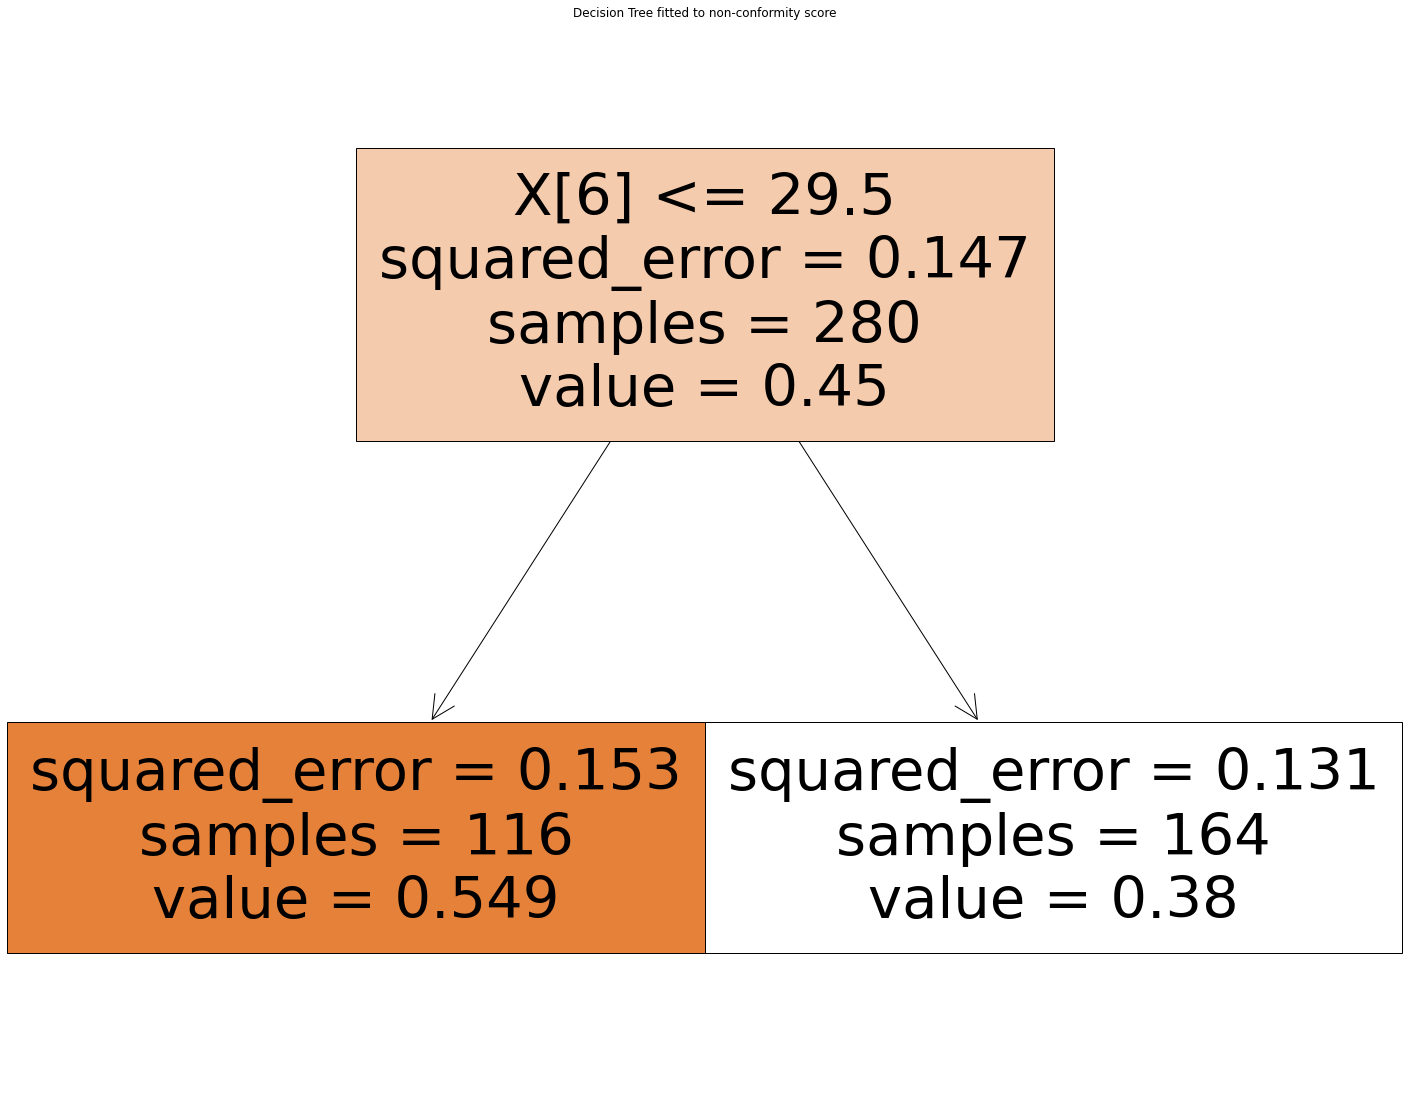

<Figure size 432x288 with 0 Axes>

In [ ]:
values_winered = obtain_main_metrics(data_name = "winered",
test_size = 0.3,
calib_size = 0.5,
split_calib = True,
random_seed = 1250,
sig  = 0.1,
nbins = 10,
min_samples_leaf= 100,
figname_tree = "locart_tree_winered_split.pdf",
random_state = 750)

In [ ]:
values_winered[0]

Methods  Pearson correlation  HSIC correlation  \
0                  LOCLUSTER            -0.045741      3.493714e-06   
1                     LOCART             0.047360      1.421517e-05   
2            Regresion split                  NaN     -1.163372e-30   
3  Weighted regression split             0.090634      1.169672e-04   
4  Mondrian regression split             0.059947      1.429368e-04   

   delta wsc  delta_ils  Average marginal coverage  Average interval length  \
0   0.016026   0.028066                   0.908333                 2.023167   
1   0.055357   0.000000                   0.887500                 2.014569   
2   0.004327   0.003180                   0.881250                 1.840000   
3   0.039583   0.006250                   0.872917                 1.883533   
4   0.034978   0.003533                   0.877083                 1.888550   

   Average interval length given coverage  
0                                2.020696  
1                                2.019574  
2                                1.840000  
3                                1.906363  
4                                1.899055

Testing for red wine without splitting in calibration:

Fitting mondrian regression split
Time Elapsed to fit mondrian regression split:  0.5319936275482178
Computing metrics
Time Elapsed to compute statistics for mondrian regression split:  3.8555030822753906
Fitting locluster
Time Elapsed to fit locluster:  3.5943799018859863
Computing metrics
Time Elapsed to compute metrics for Locluster:  11.526822805404663
Fitting locart
Time Elapsed to fit Locart:  0.497713565826416
Computing metrics
Time Elapsed to compute metrics for Locart:  9.96997356414795
Fitting regression split
Time Elapsed to fit regression split:  0.5243322849273682
Computing metrics


/home/kuben/anaconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/kuben/anaconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Time Elapsed to compute statistics for regression split:  4.0957746505737305
Fitting weighted regression split
Time Elapsed to fit weighted regression split:  0.8664188385009766
Computing metrics
Time Elapsed to compute statistics for weighted regression split:  0.8664188385009766


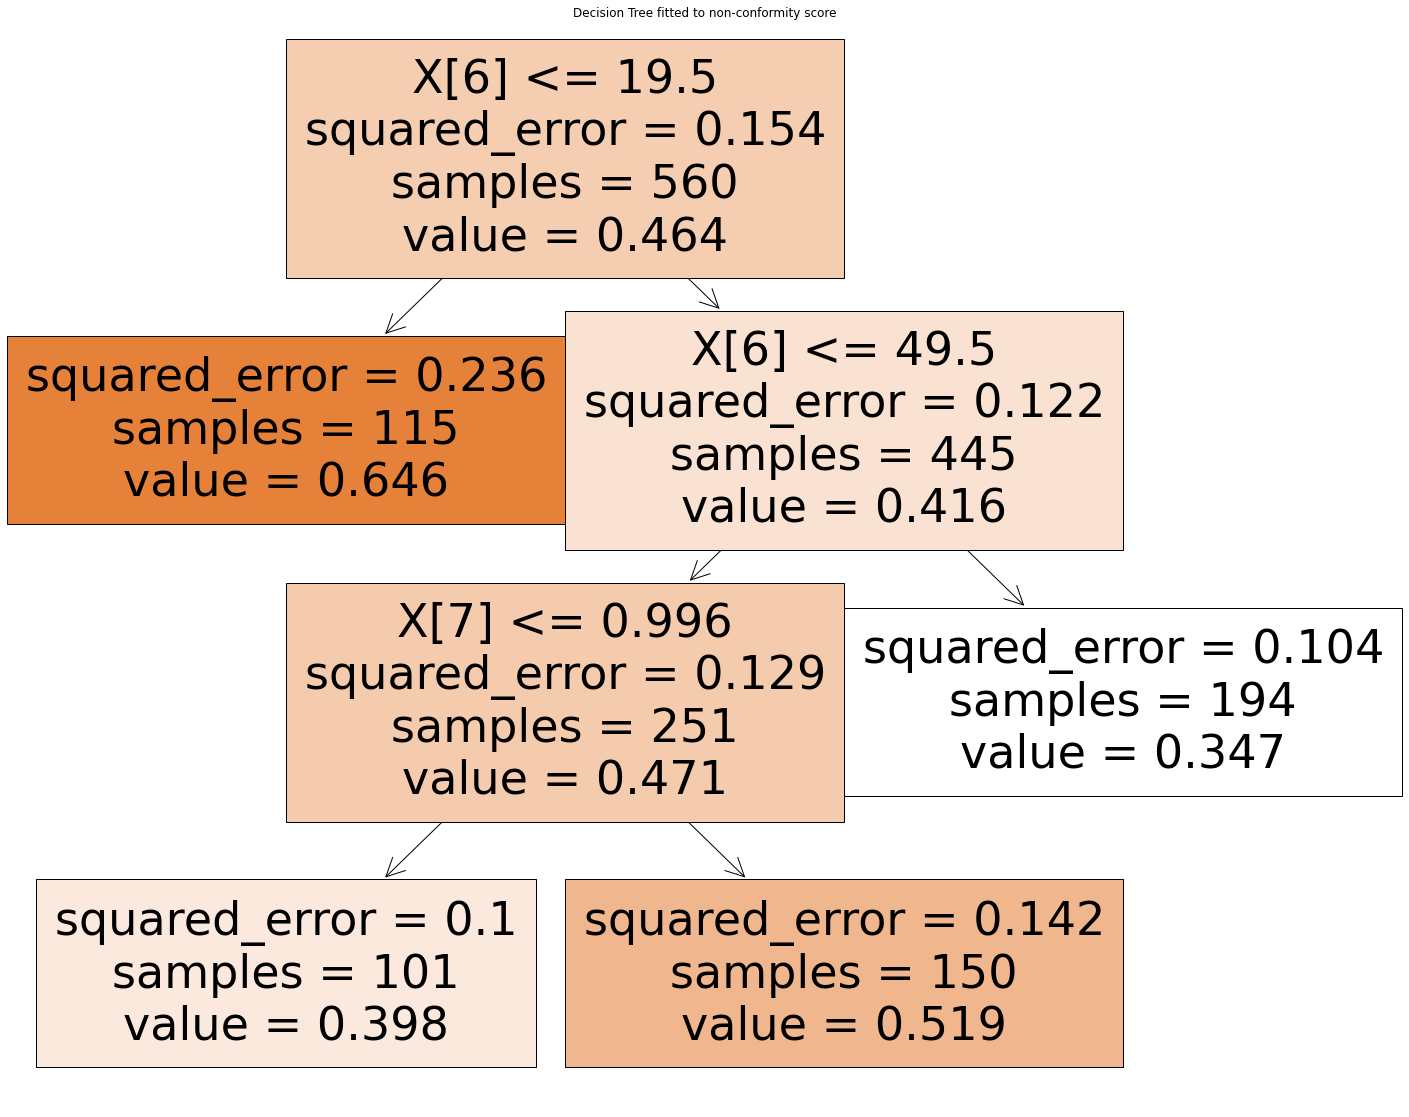

<Figure size 432x288 with 0 Axes>

In [ ]:
values_winered_nocalib = obtain_main_metrics(data_name = "winered",
test_size = 0.3,
calib_size = 0.5,
split_calib = False,
random_seed = 1250,
sig  = 0.1,
nbins = 10,
min_samples_leaf= 100,
figname_tree = "locart_tree_winered_nosplit.pdf",
random_state = 750)

In [ ]:
values_winered_nocalib[0]

Methods  Pearson correlation  HSIC correlation  \
0                  LOCLUSTER            -0.045741      3.493714e-06   
1                     LOCART             0.072082      3.838528e-05   
2            Regresion split                  NaN     -1.163372e-30   
3  Weighted regression split             0.090634      1.169672e-04   
4  Mondrian regression split             0.059947      1.429368e-04   

   delta wsc  delta_ils  Average marginal coverage  Average interval length  \
0   0.016026  -0.014583                   0.908333                 2.023167   
1   0.038374   0.000000                   0.877083                 1.853315   
2   0.004327   0.007900                   0.881250                 1.840000   
3   0.039583   0.016667                   0.872917                 1.883533   
4   0.034978  -0.037186                   0.877083                 1.888550   

   Average interval length given coverage  
0                                2.020696  
1                                1.862152  
2                                1.840000  
3                                1.906363  
4                                1.899055

Testing for white wine data with splitting in calibration for locart:

Fitting mondrian regression split
Time Elapsed to fit mondrian regression split:  1.7883453369140625
Computing metrics
Time Elapsed to compute statistics for mondrian regression split:  9.511267900466919
Fitting locluster
Time Elapsed to fit locluster:  5.536042928695679
Computing metrics
Time Elapsed to compute metrics for Locluster:  22.38115167617798
Fitting locart
Time Elapsed to fit Locart:  1.6817200183868408
Computing metrics
Time Elapsed to compute metrics for Locart:  21.056571006774902
Fitting regression split
Time Elapsed to fit regression split:  1.5773117542266846
Computing metrics
Time Elapsed to compute statistics for regression split:  8.065983057022095
Fitting weighted regression split
Time Elapsed to fit weighted regression split:  2.7795183658599854
Computing metrics
Time Elapsed to compute statistics for weighted regression split:  2.7795183658599854


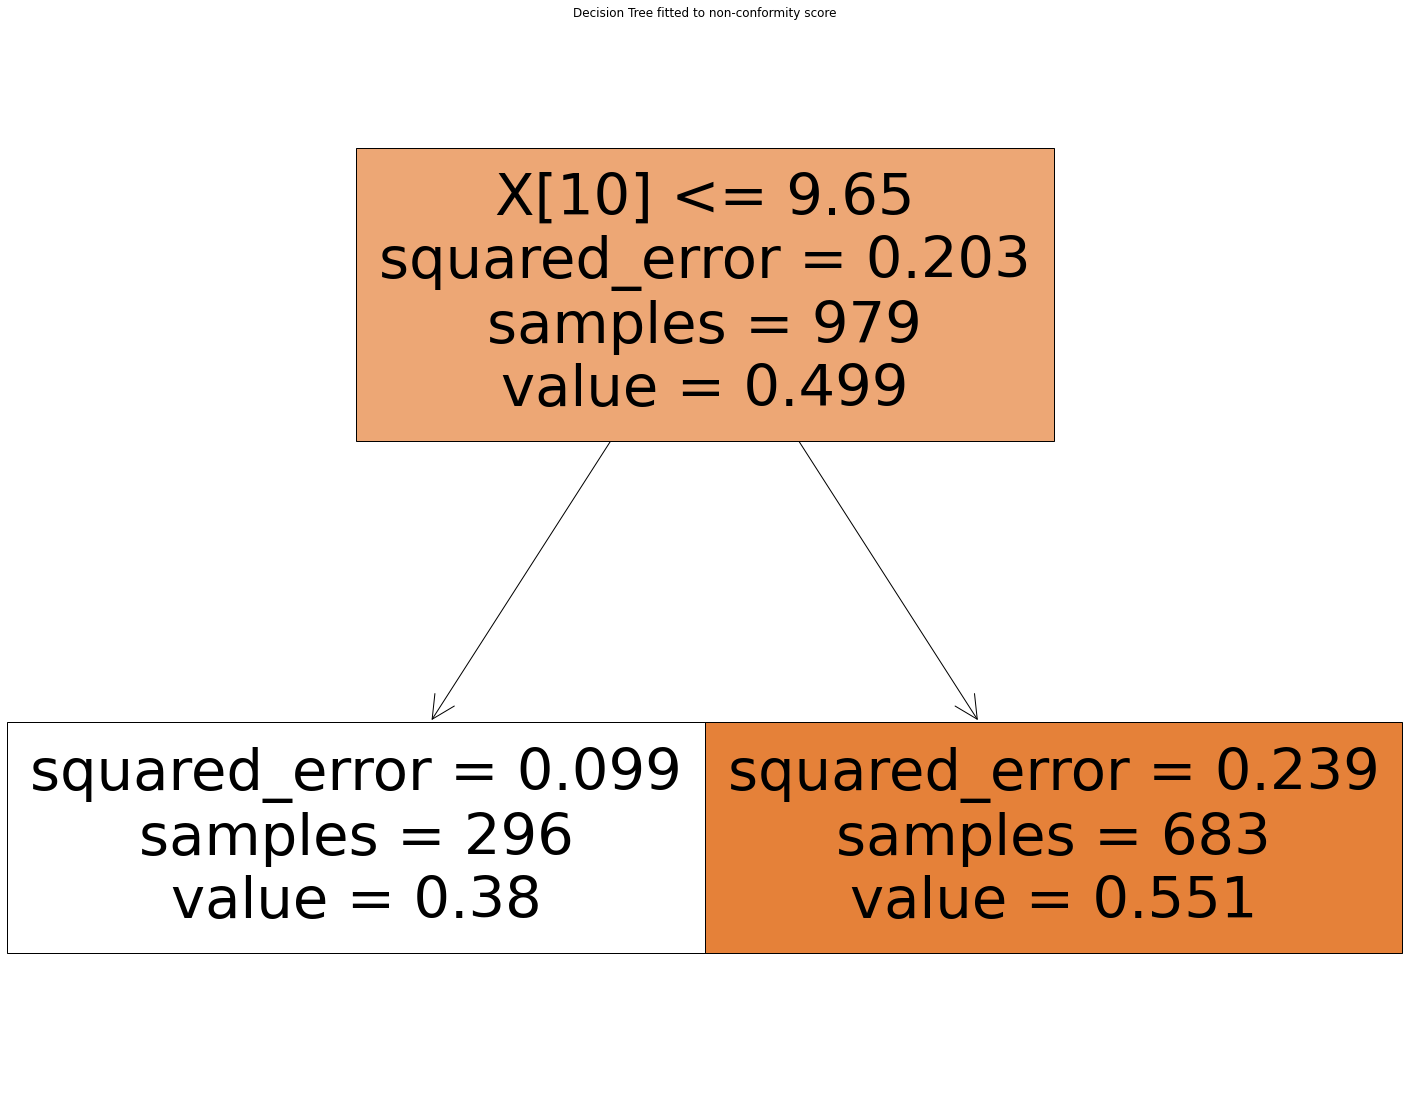

<Figure size 432x288 with 0 Axes>

In [ ]:
values_winewhite = obtain_main_metrics(data_name = "winewhite",
test_size = 0.2,
calib_size = 0.5,
split_calib = True,
random_seed = 1250,
sig  = 0.1,
nbins = 10,
min_samples_leaf= 100,
figname_tree = "locart_tree_winewhite_split.pdf",
random_state = 750)

In [ ]:
values_winewhite[0]

Methods  Pearson correlation  HSIC correlation  \
0                  LOCLUSTER            -0.089575      4.397692e-05   
1                     LOCART            -0.074620      3.303694e-05   
2            Regresion split             0.026871     -1.642104e-18   
3  Weighted regression split             0.083480      9.715967e-05   
4  Mondrian regression split            -0.027843      2.932228e-05   

   delta wsc  delta_ils  Average marginal coverage  Average interval length  \
0   0.022902   0.039885                   0.895918                 2.053020   
1   0.035447   0.000000                   0.898980                 2.065124   
2   0.004762  -0.013572                   0.900000                 2.180000   
3   0.026263  -0.041837                   0.908163                 2.219546   
4   0.037755   0.064390                   0.894898                 2.128857   

   Average interval length given coverage  
0                                2.044330  
1                                2.057544  
2                                2.180000  
3                                2.242125  
4                                2.124107

White wine without splitting:

Fitting mondrian regression split
Time Elapsed to fit mondrian regression split:  1.7174701690673828
Computing metrics
Time Elapsed to compute statistics for mondrian regression split:  8.834594964981079
Fitting locluster
Time Elapsed to fit locluster:  5.423595190048218
Computing metrics
Time Elapsed to compute metrics for Locluster:  22.778149843215942
Fitting locart
Time Elapsed to fit Locart:  1.6894066333770752
Computing metrics
Time Elapsed to compute metrics for Locart:  21.23231315612793
Fitting regression split
Time Elapsed to fit regression split:  1.6057140827178955
Computing metrics
Time Elapsed to compute statistics for regression split:  9.379385232925415
Fitting weighted regression split
Time Elapsed to fit weighted regression split:  2.802103281021118
Computing metrics
Time Elapsed to compute statistics for weighted regression split:  2.802103281021118


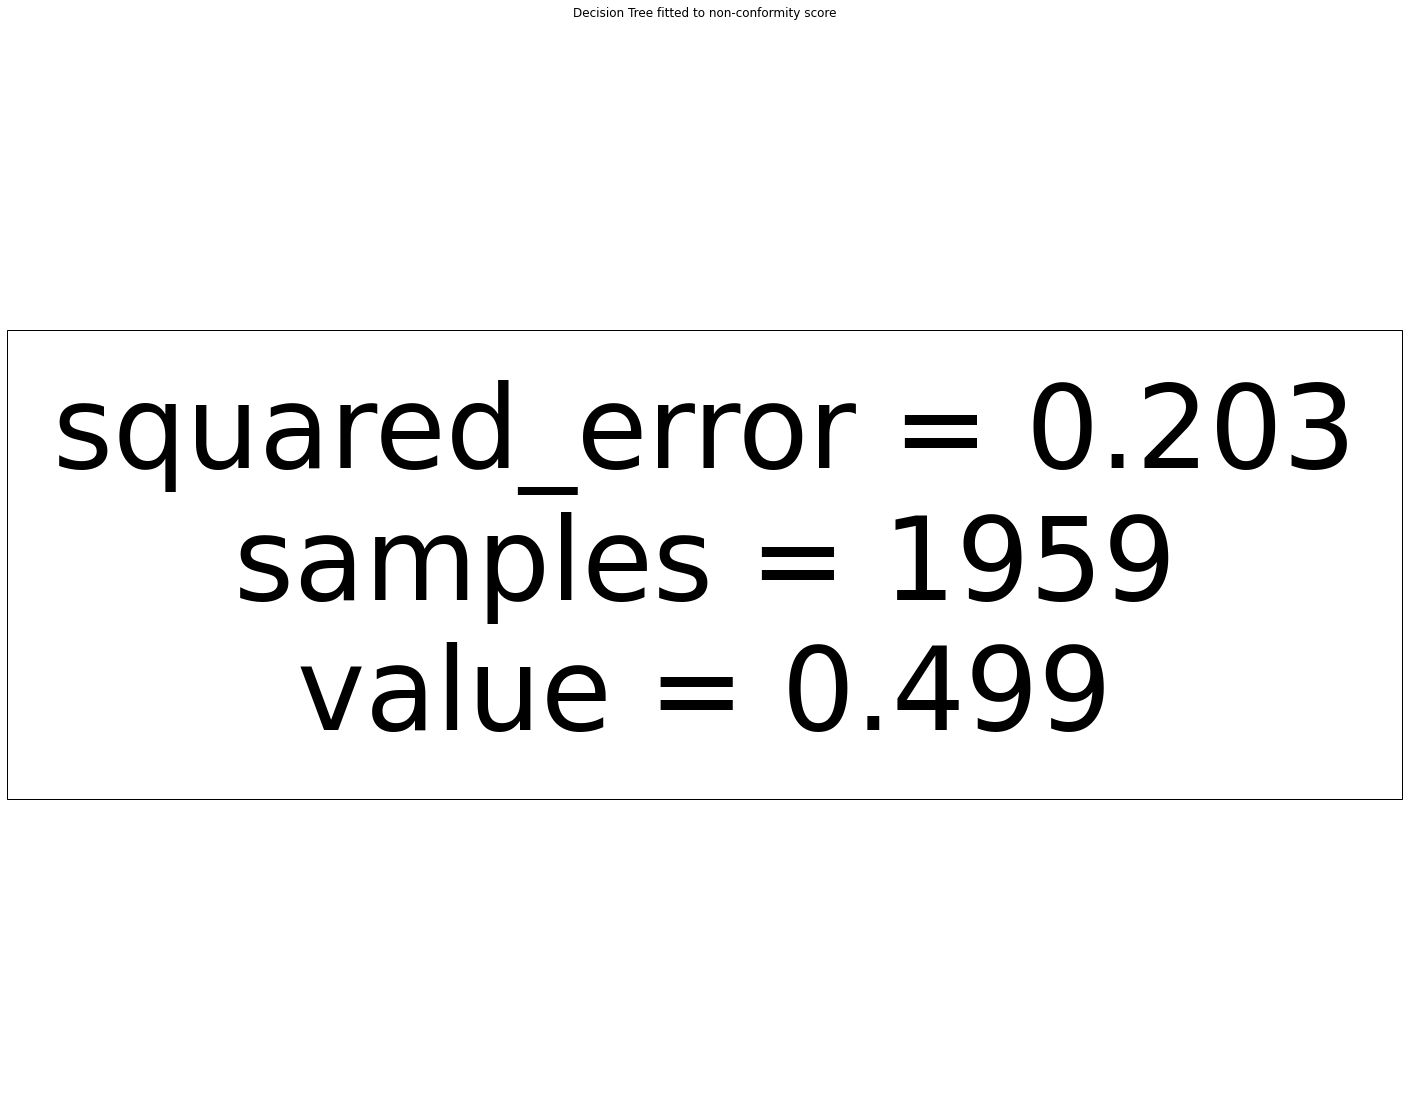

<Figure size 432x288 with 0 Axes>

In [ ]:
values_winewhite_nocalib = obtain_main_metrics(data_name = "winewhite",
test_size = 0.2,
calib_size = 0.5,
split_calib = False,
random_seed = 1250,
sig  = 0.1,
nbins = 10,
min_samples_leaf= 100,
figname_tree = "locart_tree_winewhite_split.pdf",
random_state = 750)

In [ ]:
values_winewhite_nocalib[0]

Methods  Pearson correlation  HSIC correlation  \
0                  LOCLUSTER            -0.089575      4.397692e-05   
1                     LOCART            -0.029980      4.828668e-10   
2            Regresion split             0.026871     -1.642104e-18   
3  Weighted regression split             0.083480      9.715967e-05   
4  Mondrian regression split            -0.027843      2.932228e-05   

   delta wsc  delta_ils  Average marginal coverage  Average interval length  \
0   0.022902   0.006980                   0.895918                 2.053020   
1   0.006287   0.000000                   0.896939                 2.174808   
2   0.004762   0.003061                   0.900000                 2.180000   
3   0.026263   0.031633                   0.908163                 2.219546   
4   0.037755   0.007959                   0.894898                 2.128857   

   Average interval length given coverage  
0                                2.044330  
1                                2.174780  
2                                2.180000  
3                                2.242125  
4                                2.124107

Protein data:

Fitting mondrian regression split
Time Elapsed to fit mondrian regression split:  28.80934762954712
Computing metrics
Time Elapsed to compute statistics for mondrian regression split:  138.981294631958
Fitting locluster
Time Elapsed to fit locluster:  84.75294184684753
Computing metrics
Time Elapsed to compute metrics for Locluster:  206.0672209262848
Fitting locart
Time Elapsed to fit Locart:  27.715007305145264
Computing metrics
Time Elapsed to compute metrics for Locart:  202.4383442401886
Fitting regression split
Time Elapsed to fit regression split:  27.476498126983643
Computing metrics
Time Elapsed to compute statistics for regression split:  139.66069793701172
Fitting weighted regression split
Time Elapsed to fit weighted regression split:  42.19998502731323
Computing metrics
Time Elapsed to compute statistics for weighted regression split:  42.19998502731323


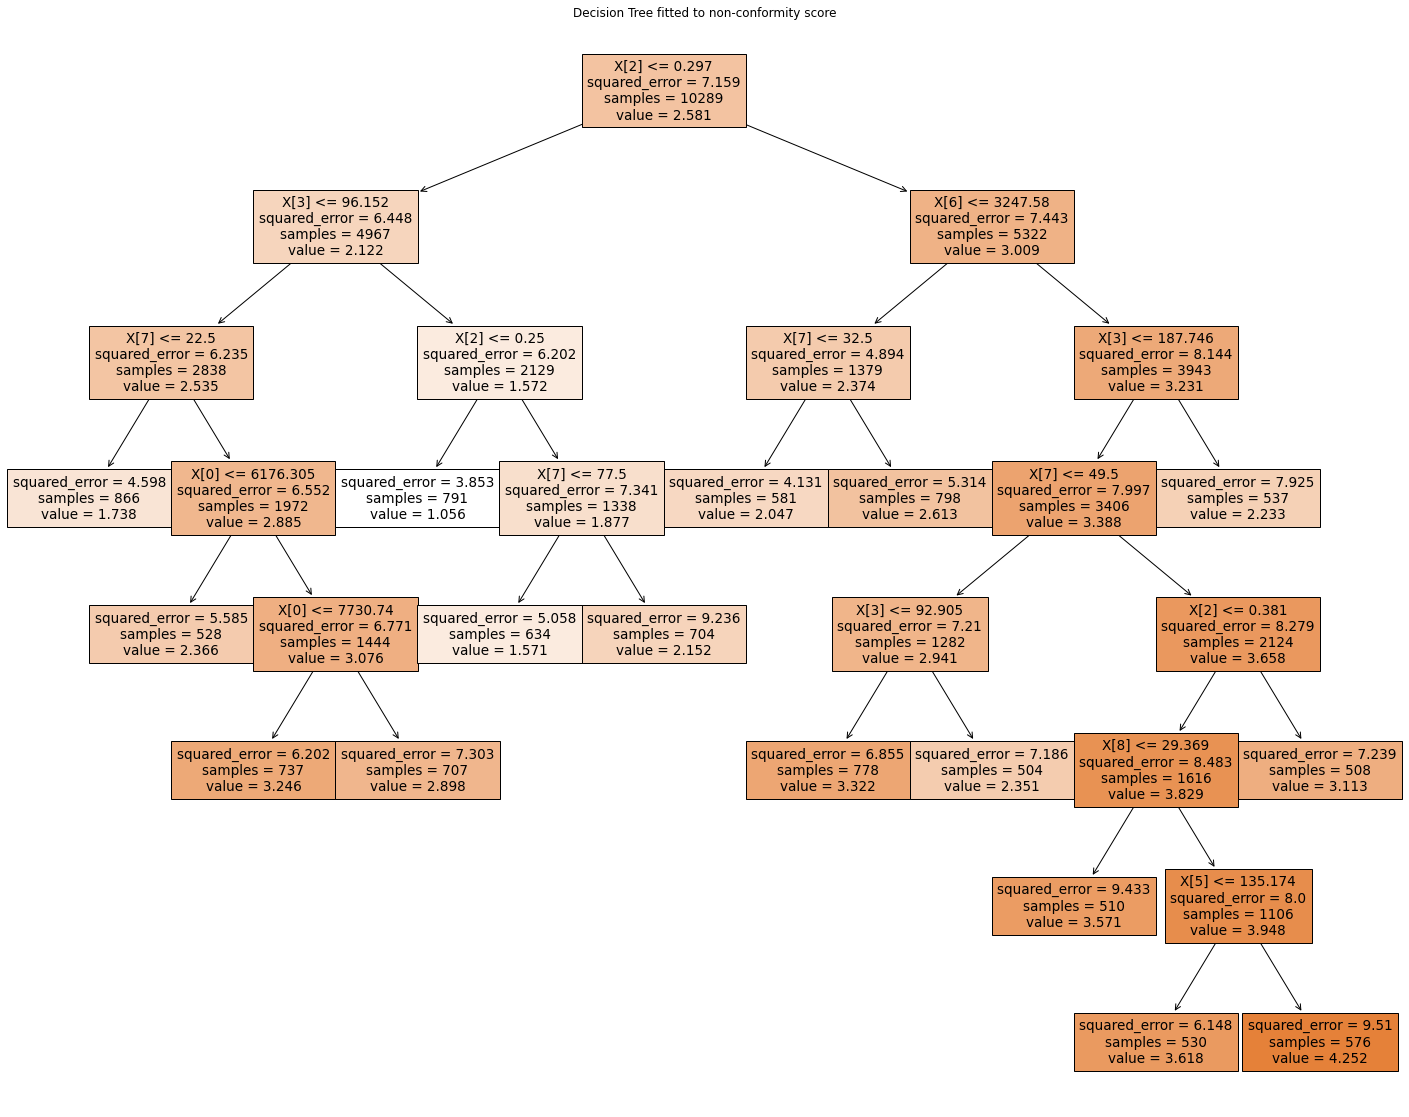

<Figure size 432x288 with 0 Axes>

In [ ]:
values_protein = obtain_main_metrics(data_name = "protein",
test_size = 0.1,
calib_size = 0.5,
split_calib = True,
random_seed = 1250,
sig  = 0.1,
nbins = 20,
min_samples_leaf= 500,
figname_tree = "locart_tree_protein_split.pdf",
random_state = 750)

In [ ]:
values_protein[0]

Methods  Pearson correlation  HSIC correlation  \
0                  LOCLUSTER            -0.013752      3.913989e-05   
1                     LOCART            -0.025764      1.577748e-05   
2            Regresion split            -0.008202      7.446835e-18   
3  Weighted regression split            -0.017468      5.104938e-05   
4  Mondrian regression split             0.008287      1.813497e-05   

   delta wsc  delta_ils  Average marginal coverage  Average interval length  \
0   0.014351   0.039951                   0.900066                11.537890   
1   0.002843   0.000000                   0.903783                12.066551   
2   0.018273  -0.096540                   0.906845                12.700300   
3   0.001868   0.078825                   0.906188                10.141943   
4   0.002648   0.068907                   0.903127                 9.686837   

   Average interval length given coverage  
0                               11.524686  
1                               12.049313  
2                               12.700300  
3                               10.112057  
4                                9.702164

Locart without splitting calibration set for protein data:

Fitting mondrian regression split
Time Elapsed to fit mondrian regression split:  28.15487837791443
Computing metrics
Time Elapsed to compute statistics for mondrian regression split:  139.4538173675537
Fitting locluster
Time Elapsed to fit locluster:  74.21701407432556
Computing metrics
Time Elapsed to compute metrics for Locluster:  198.7228479385376
Fitting locart
Time Elapsed to fit Locart:  27.120704889297485
Computing metrics
Time Elapsed to compute metrics for Locart:  196.46282601356506
Fitting regression split
Time Elapsed to fit regression split:  26.864657163619995
Computing metrics
Time Elapsed to compute statistics for regression split:  136.71073079109192
Fitting weighted regression split
Time Elapsed to fit weighted regression split:  41.18853282928467
Computing metrics
Time Elapsed to compute statistics for weighted regression split:  41.18853282928467


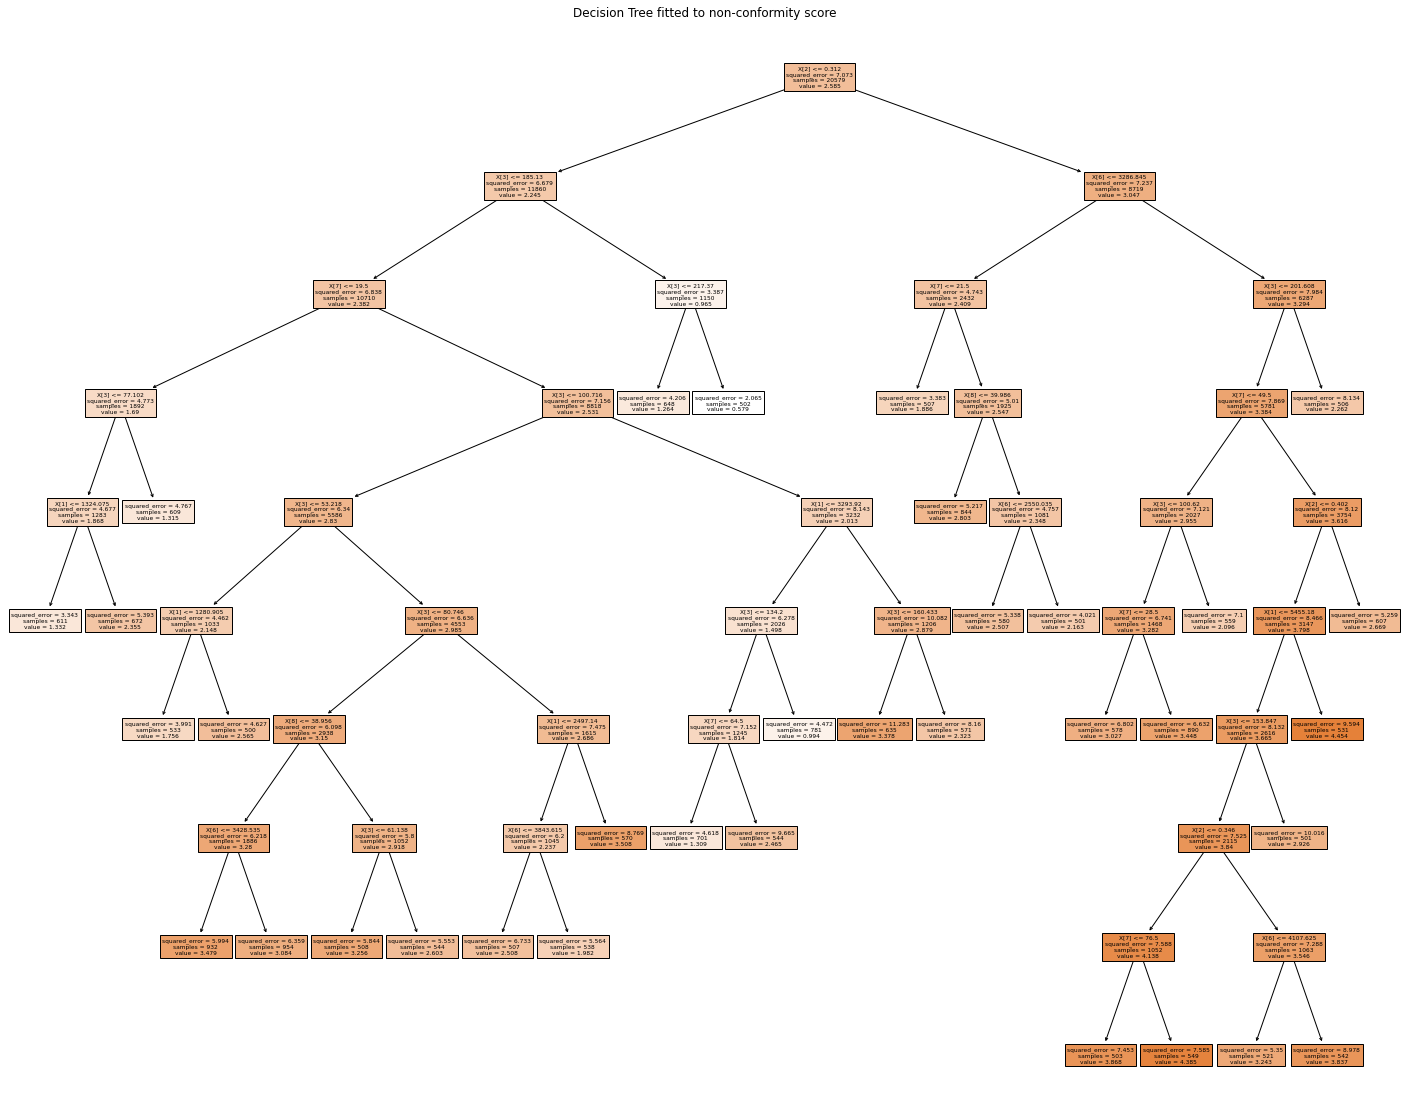

<Figure size 432x288 with 0 Axes>

In [ ]:
values_protein_nocalib = obtain_main_metrics(data_name = "protein",
test_size = 0.1,
calib_size = 0.5,
split_calib = False,
random_seed = 1250,
sig  = 0.1,
nbins = 20,
min_samples_leaf= 500,
figname_tree = "locart_tree_protein_split.pdf",
random_state = 750)

In [ ]:
values_protein_nocalib[0]

Methods  Pearson correlation  HSIC correlation  \
0                  LOCLUSTER            -0.013752      3.913989e-05   
1                     LOCART             0.004146      3.552395e-06   
2            Regresion split            -0.008202      7.446835e-18   
3  Weighted regression split            -0.017468      5.104938e-05   
4  Mondrian regression split             0.008287      1.813497e-05   

   delta wsc  delta_ils  Average marginal coverage  Average interval length  \
0   0.014351  -0.038126                   0.900066                11.537890   
1   0.011328   0.000000                   0.902252                11.599151   
2   0.018273  -0.130107                   0.906845                12.700300   
3   0.001868   0.045421                   0.906188                10.141943   
4   0.002648   0.072350                   0.903127                 9.686837   

   Average interval length given coverage  
0                               11.524686  
1                               11.603989  
2                               12.700300  
3                               10.112057  
4                                9.702164

Cycle data with splitting:

Fitting mondrian regression split
Time Elapsed to fit mondrian regression split:  2.1425981521606445
Computing metrics
Time Elapsed to compute statistics for mondrian regression split:  11.792063474655151
Fitting locluster
Time Elapsed to fit locluster:  6.083859443664551
Computing metrics
Time Elapsed to compute metrics for Locluster:  30.955824375152588
Fitting locart
Time Elapsed to fit Locart:  1.9659945964813232
Computing metrics
Time Elapsed to compute metrics for Locart:  30.33768129348755
Fitting regression split
Time Elapsed to fit regression split:  1.9610612392425537
Computing metrics


/home/kuben/anaconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/kuben/anaconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Time Elapsed to compute statistics for regression split:  11.735809326171875
Fitting weighted regression split
Time Elapsed to fit weighted regression split:  3.1417551040649414
Computing metrics
Time Elapsed to compute statistics for weighted regression split:  3.1417551040649414


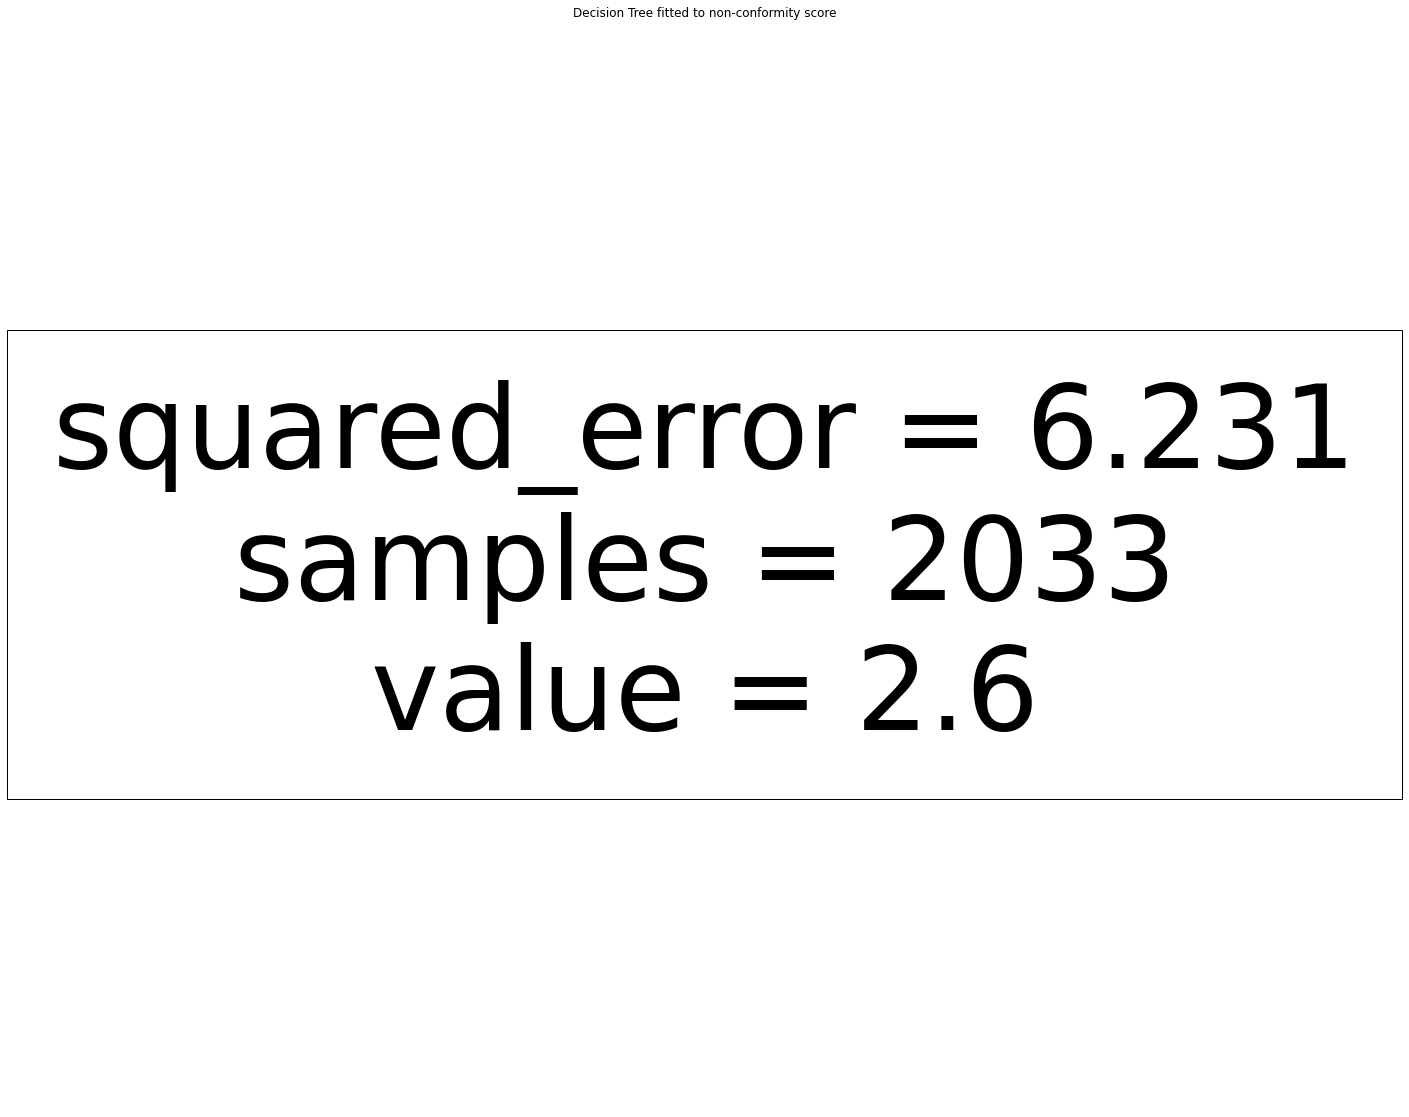

<Figure size 432x288 with 0 Axes>

In [ ]:
values_cycle = obtain_main_metrics(data_name = "cycle",
test_size = 0.15,
calib_size = 0.5,
split_calib = True,
random_seed = 1250,
sig  = 0.1,
nbins = 10,
min_samples_leaf= 100,
figname_tree = "locart_tree_cycle_split.pdf",
random_state = 750)

In [ ]:
values_cycle[0]

Methods  Pearson correlation  HSIC correlation  \
0                  LOCLUSTER             0.053855      2.994042e-05   
1                     LOCART             0.035883      1.681418e-08   
2            Regresion split                  NaN      4.206865e-19   
3  Weighted regression split             0.134752      2.416200e-04   
4  Mondrian regression split             0.103705      1.020662e-04   

   delta wsc  delta_ils  Average marginal coverage  Average interval length  \
0   0.004034   0.028056                   0.917827                11.452102   
1   0.013351   0.000000                   0.918524                11.376865   
2   0.007780  -0.000563                   0.912953                11.134800   
3   0.003866  -0.027275                   0.900418                11.054259   
4   0.085812  -0.012682                   0.903203                10.571722   

   Average interval length given coverage  
0                               11.494063  
1                               11.377024  
2                               11.134800  
3                               11.283827  
4                               10.678867

Cycle without splitting:

Fitting mondrian regression split
Time Elapsed to fit mondrian regression split:  2.096101760864258
Computing metrics
Time Elapsed to compute statistics for mondrian regression split:  10.446863174438477
Fitting locluster
Time Elapsed to fit locluster:  5.562352895736694
Computing metrics
Time Elapsed to compute metrics for Locluster:  31.12627124786377
Fitting locart
Time Elapsed to fit Locart:  1.9481160640716553
Computing metrics
Time Elapsed to compute metrics for Locart:  30.317699909210205
Fitting regression split
Time Elapsed to fit regression split:  1.917618989944458
Computing metrics


/home/kuben/anaconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/kuben/anaconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Time Elapsed to compute statistics for regression split:  11.04958438873291
Fitting weighted regression split
Time Elapsed to fit weighted regression split:  2.593313217163086
Computing metrics
Time Elapsed to compute statistics for weighted regression split:  2.593313217163086


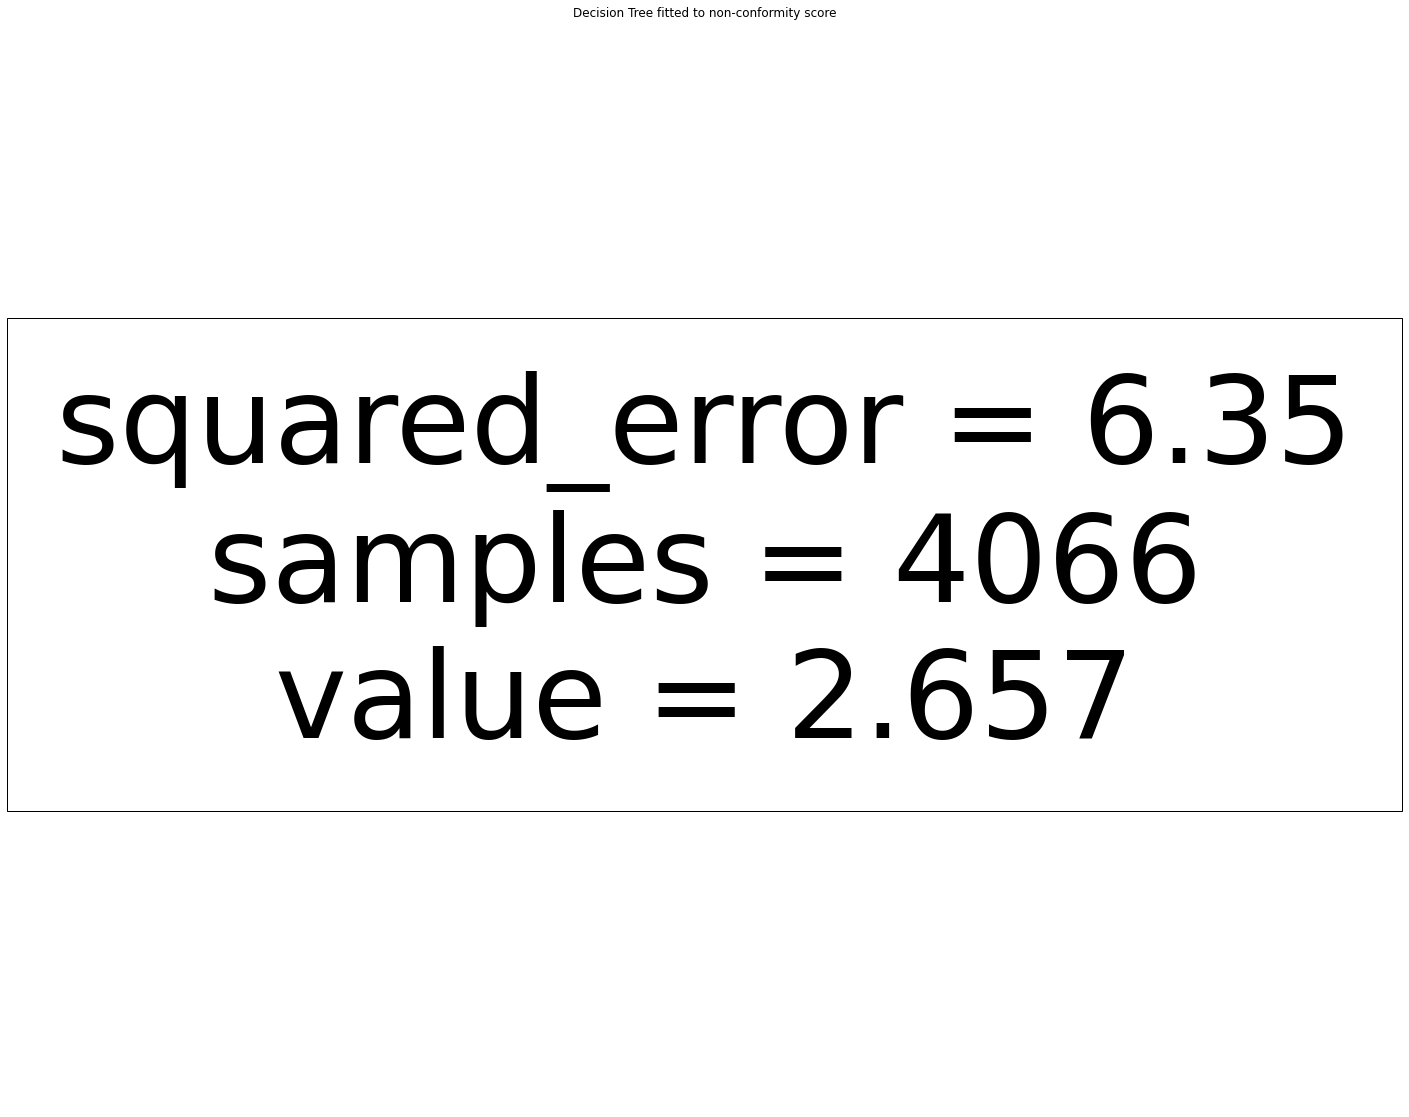

<Figure size 432x288 with 0 Axes>

In [ ]:
values_cycle_nocalib = obtain_main_metrics(data_name = "cycle",
test_size = 0.15,
calib_size = 0.5,
split_calib = False,
random_seed = 1250,
sig  = 0.1,
nbins = 10,
min_samples_leaf= 100,
figname_tree = "locart_tree_cycle_nosplit.pdf",
random_state = 750)

In [ ]:
values_cycle_nocalib[0]

Methods  Pearson correlation  HSIC correlation  \
0                  LOCLUSTER             0.053855      2.994042e-05   
1                     LOCART            -0.027488      1.859536e-08   
2            Regresion split                  NaN      4.206865e-19   
3  Weighted regression split             0.134752      2.416200e-04   
4  Mondrian regression split             0.103705      1.020662e-04   

   delta wsc  delta_ils  Average marginal coverage  Average interval length  \
0   0.004034   0.016767                   0.917827                11.452102   
1   0.006387   0.000000                   0.911560                11.074787   
2   0.007780  -0.001393                   0.912953                11.134800   
3   0.003866  -0.006422                   0.900418                11.054259   
4   0.085812  -0.018711                   0.903203                10.571722   

   Average interval length given coverage  
0                               11.494063  
1                               11.074619  
2                               11.134800  
3                               11.283827  
4                               10.678867

Electric with splitting:

Fitting mondrian regression split
Time Elapsed to fit mondrian regression split:  5.488864898681641
Computing metrics
Time Elapsed to compute statistics for mondrian regression split:  6.728713512420654
Fitting locluster
Time Elapsed to fit locluster:  10.950052738189697
Computing metrics
Time Elapsed to compute metrics for Locluster:  20.75749683380127
Fitting locart
Time Elapsed to fit Locart:  4.786436080932617
Computing metrics
Time Elapsed to compute metrics for Locart:  17.88965368270874
Fitting regression split
Time Elapsed to fit regression split:  4.24214768409729
Computing metrics
Time Elapsed to compute statistics for regression split:  6.692840576171875
Fitting weighted regression split
Time Elapsed to fit weighted regression split:  8.540040254592896
Computing metrics
Time Elapsed to compute statistics for weighted regression split:  8.540040254592896


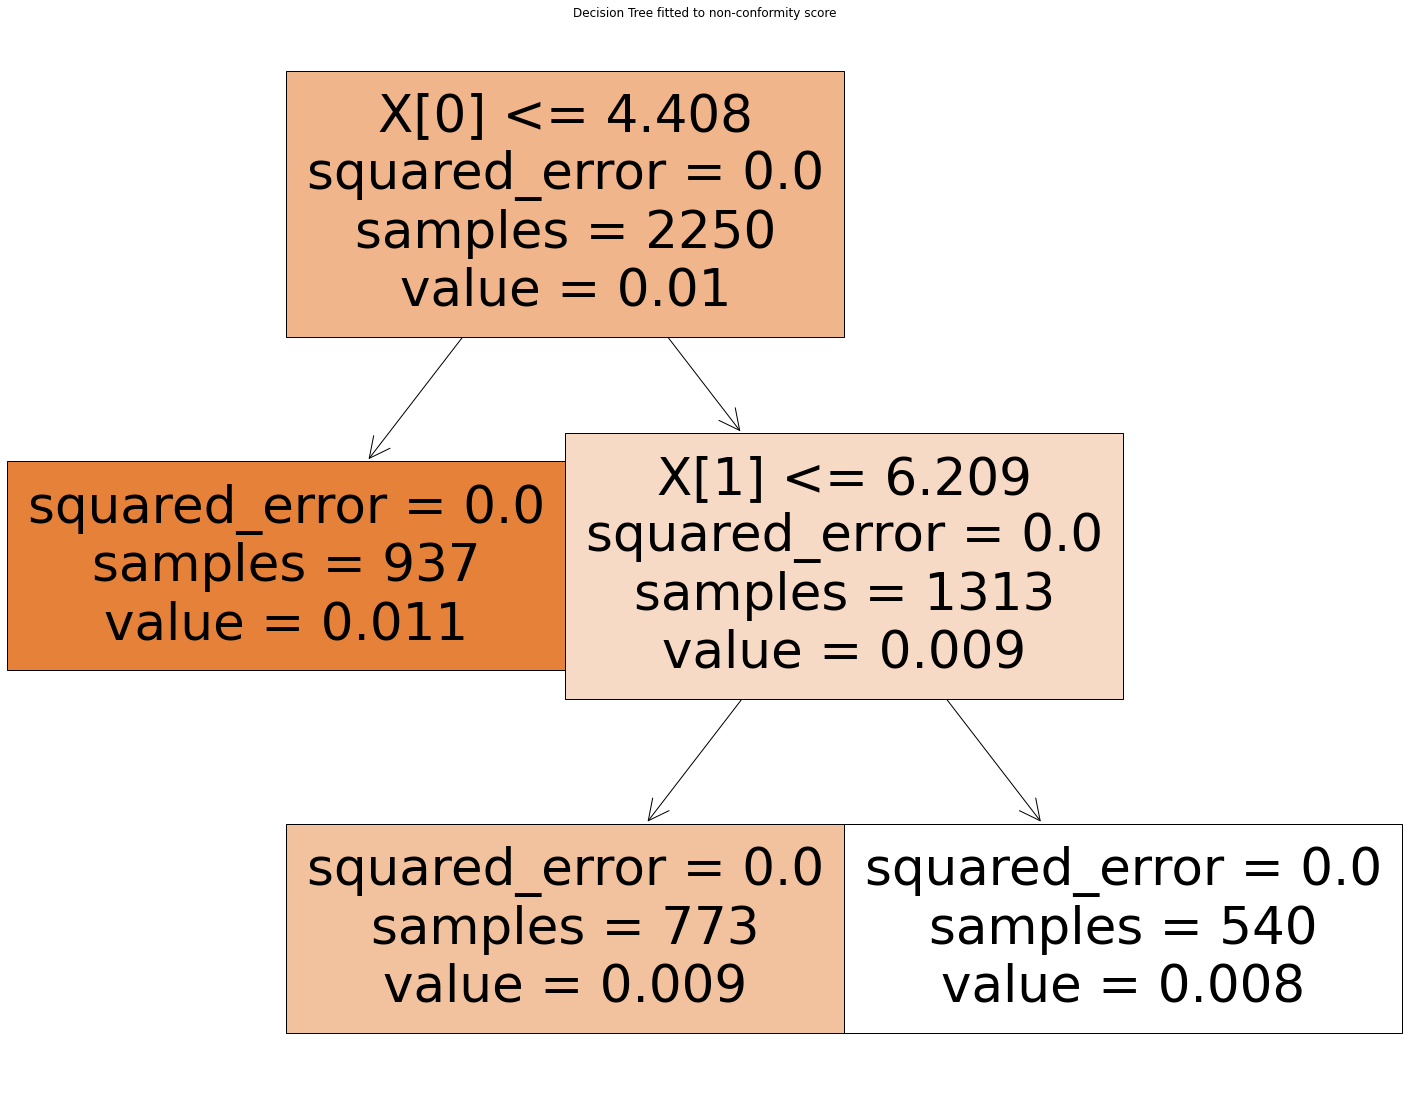

<Figure size 432x288 with 0 Axes>

In [ ]:
values_electric = obtain_main_metrics(data_name = "electric",
test_size = 0.1,
calib_size = 0.5,
split_calib = True,
random_seed = 1250,
sig  = 0.1,
nbins = 10,
min_samples_leaf= 500,
figname_tree = "locart_tree_electric_split.pdf",
random_state = 750)

In [ ]:
values_electric[0]

Methods  Pearson correlation  HSIC correlation  \
0                  LOCLUSTER             0.048715      1.748898e-08   
1                     LOCART             0.045247      5.581265e-09   
2            Regresion split            -0.011096      1.431849e-20   
3  Weighted regression split             0.025097      6.489365e-09   
4  Mondrian regression split             0.028151      4.419846e-09   

   delta wsc  delta_ils  Average marginal coverage  Average interval length  \
0   0.080667   0.055135                      0.864                 0.037742   
1   0.031730   0.000000                      0.873                 0.037810   
2   0.009789  -0.045121                      0.906                 0.041065   
3   0.078211  -0.017000                      0.894                 0.039752   
4   0.022667   0.058243                      0.894                 0.039874   

   Average interval length given coverage  
0                                0.037914  
1                                0.037906  
2                                0.041065  
3                                0.039853  
4                                0.039957

Electric without splitting:

Fitting mondrian regression split
Time Elapsed to fit mondrian regression split:  5.5559937953948975
Computing metrics
Time Elapsed to compute statistics for mondrian regression split:  6.467955112457275
Fitting locluster
Time Elapsed to fit locluster:  10.243509292602539
Computing metrics
Time Elapsed to compute metrics for Locluster:  20.452237606048584
Fitting locart
Time Elapsed to fit Locart:  5.0564305782318115
Computing metrics
Time Elapsed to compute metrics for Locart:  19.901050329208374
Fitting regression split
Time Elapsed to fit regression split:  5.388488292694092
Computing metrics
Time Elapsed to compute statistics for regression split:  6.638010263442993
Fitting weighted regression split
Time Elapsed to fit weighted regression split:  8.556644201278687
Computing metrics
Time Elapsed to compute statistics for weighted regression split:  8.556644201278687


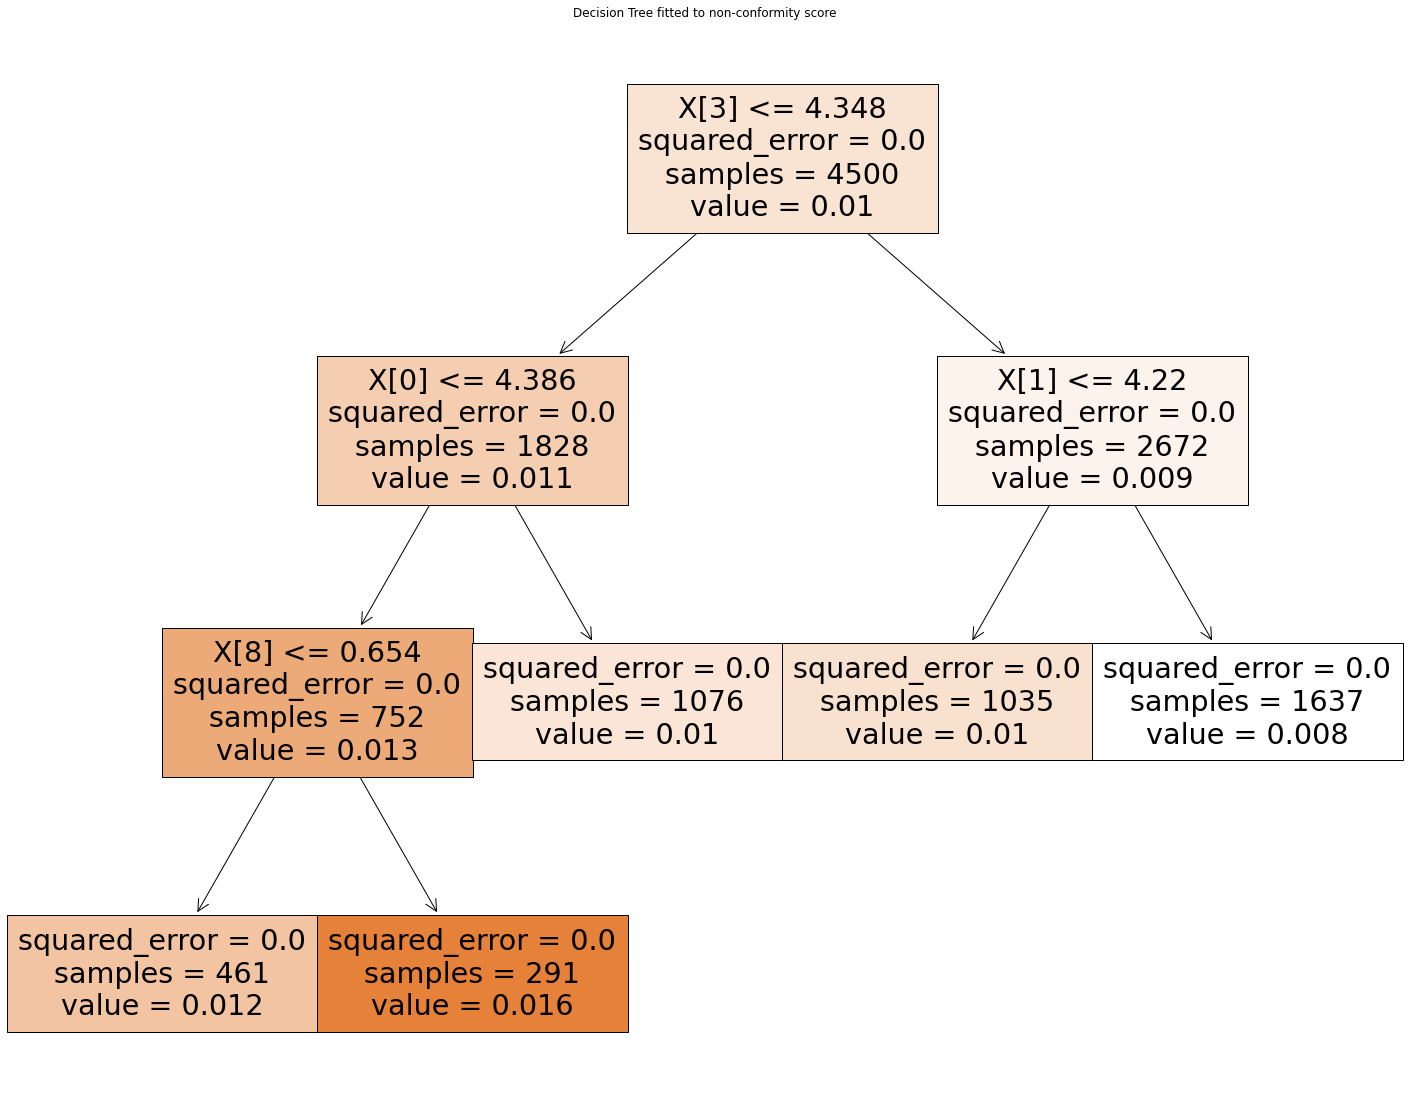

<Figure size 432x288 with 0 Axes>

In [ ]:
values_electric_nocalib = obtain_main_metrics(data_name = "electric",
test_size = 0.1,
calib_size = 0.5,
split_calib = False,
random_seed = 1250,
sig  = 0.1,
nbins = 10,
min_samples_leaf= 100,
figname_tree = "locart_tree_electric_nosplit.pdf",
random_state = 750)

In [ ]:
values_electric_nocalib[0]

Methods  Pearson correlation  HSIC correlation  \
0                  LOCLUSTER             0.048715      1.748898e-08   
1                     LOCART             0.076837      4.350375e-08   
2            Regresion split            -0.011096      1.431849e-20   
3  Weighted regression split             0.025097      6.489365e-09   
4  Mondrian regression split             0.028151      4.419846e-09   

   delta wsc  delta_ils  Average marginal coverage  Average interval length  \
0   0.080667  -0.031500                      0.864                 0.037742   
1   0.033082   0.000000                      0.855                 0.036355   
2   0.009789  -0.097449                      0.906                 0.041065   
3   0.078211   0.129000                      0.894                 0.039752   
4   0.022667   0.035314                      0.894                 0.039874   

   Average interval length given coverage  
0                                0.037914  
1                                0.036630  
2                                0.041065  
3                                0.039853  
4                                0.039957

News with split:

Fitting mondrian regression split
Time Elapsed to fit mondrian regression split:  104.17921137809753
Computing metrics
Time Elapsed to compute statistics for mondrian regression split:  115.62489175796509
Fitting locluster
Time Elapsed to fit locluster:  158.46730828285217
Computing metrics
Time Elapsed to compute metrics for Locluster:  173.92027235031128
Fitting locart
Time Elapsed to fit Locart:  113.2252447605133
Computing metrics
Time Elapsed to compute metrics for Locart:  153.26363062858582
Fitting regression split
Time Elapsed to fit regression split:  98.24996852874756
Computing metrics
Time Elapsed to compute statistics for regression split:  117.16654348373413
Fitting weighted regression split
Time Elapsed to fit weighted regression split:  155.33265280723572
Computing metrics
Time Elapsed to compute statistics for weighted regression split:  155.33265280723572


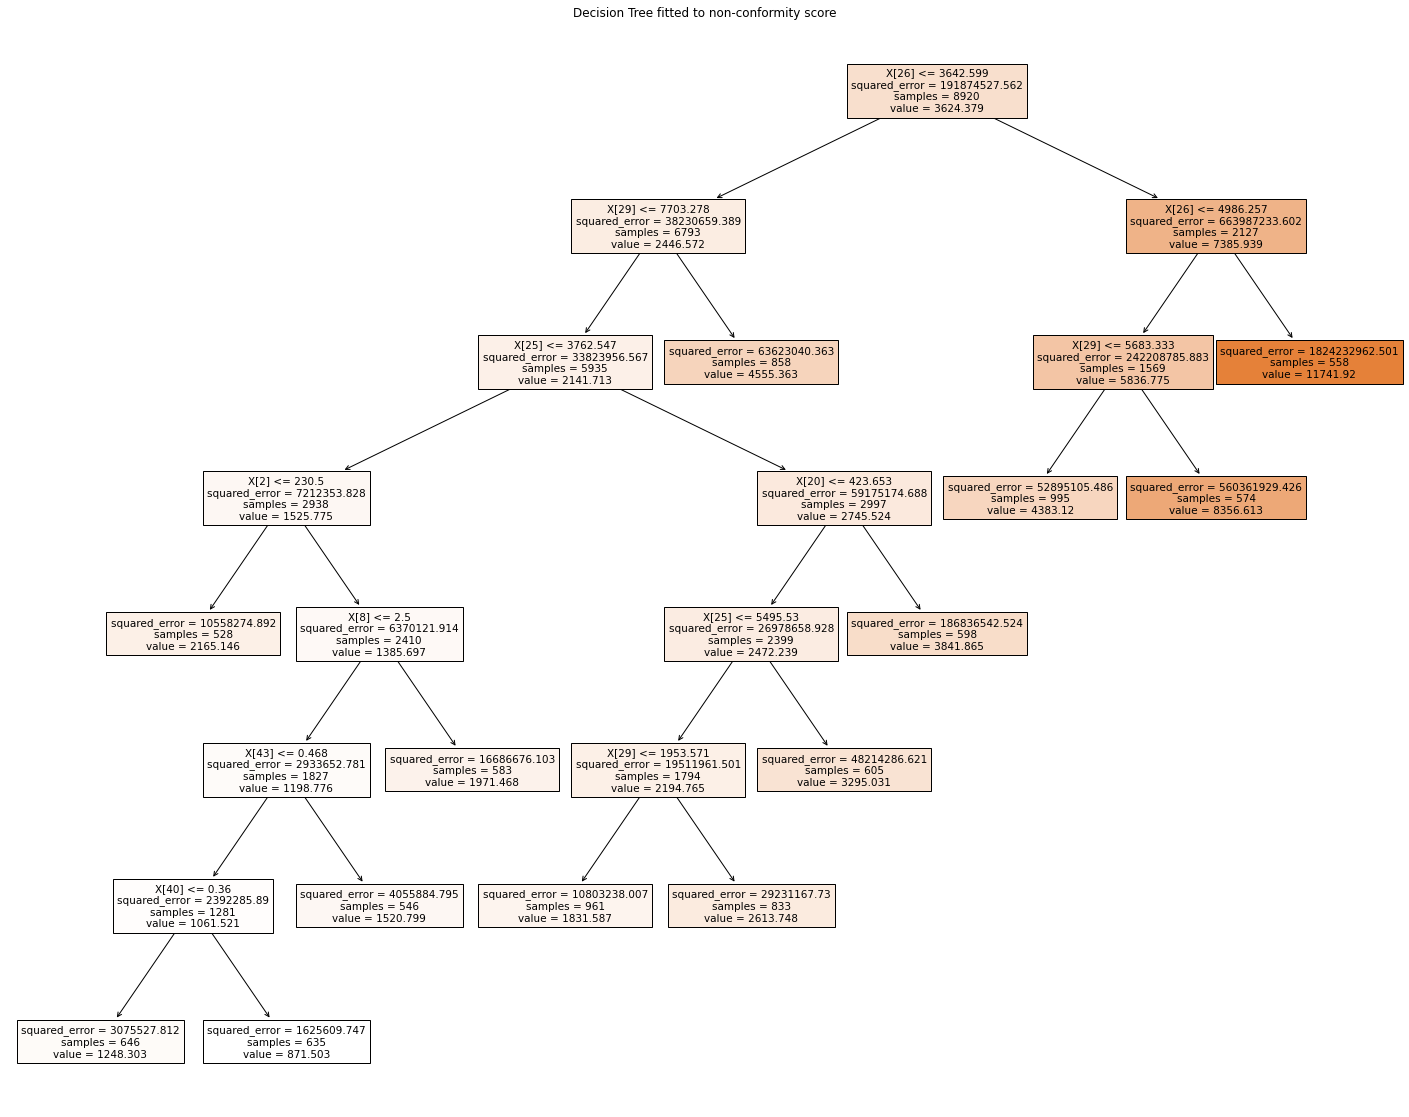

<Figure size 432x288 with 0 Axes>

In [ ]:
values_news = obtain_main_metrics(data_name = "news",
test_size = 0.1,
calib_size = 0.5,
split_calib = True,
random_seed = 1250,
sig  = 0.1,
nbins = 10,
min_samples_leaf= 500,
figname_tree = "locart_tree_news_split.pdf",
random_state = 750)

In [ ]:
values_news[0]

Methods  Pearson correlation  HSIC correlation  \
0                  LOCLUSTER            -0.072533      6.580597e-04   
1                     LOCART            -0.038495      1.263897e-04   
2            Regresion split             0.002477      3.241725e-13   
3  Weighted regression split             0.027666      1.754393e-05   
4  Mondrian regression split             0.023850      1.347548e-05   

   delta wsc  delta_ils  Average marginal coverage  Average interval length  \
0   0.043445  -0.136647                   0.894578              9134.241774   
1   0.032715   0.000000                   0.888020              9082.852288   
2   0.118954  -0.249143                   0.907945             13519.320000   
3   0.008668   0.032253                   0.903405             12451.383606   
4   0.030816   0.013512                   0.901387              9293.345170   

   Average interval length given coverage  
0                             9005.509357  
1                             9008.627301  
2                            13519.320000  
3                            12587.795765  
4                             9356.116816

News without split:

Fitting mondrian regression split
Time Elapsed to fit mondrian regression split:  111.54827857017517
Computing metrics
Time Elapsed to compute statistics for mondrian regression split:  116.4321060180664
Fitting locluster
Time Elapsed to fit locluster:  167.70701122283936
Computing metrics
Time Elapsed to compute metrics for Locluster:  170.2208228111267
Fitting locart
Time Elapsed to fit Locart:  116.13612151145935
Computing metrics
Time Elapsed to compute metrics for Locart:  159.204083442688
Fitting regression split
Time Elapsed to fit regression split:  104.19162583351135
Computing metrics
Time Elapsed to compute statistics for regression split:  114.1113486289978
Fitting weighted regression split
Time Elapsed to fit weighted regression split:  150.66061329841614
Computing metrics
Time Elapsed to compute statistics for weighted regression split:  150.66061329841614


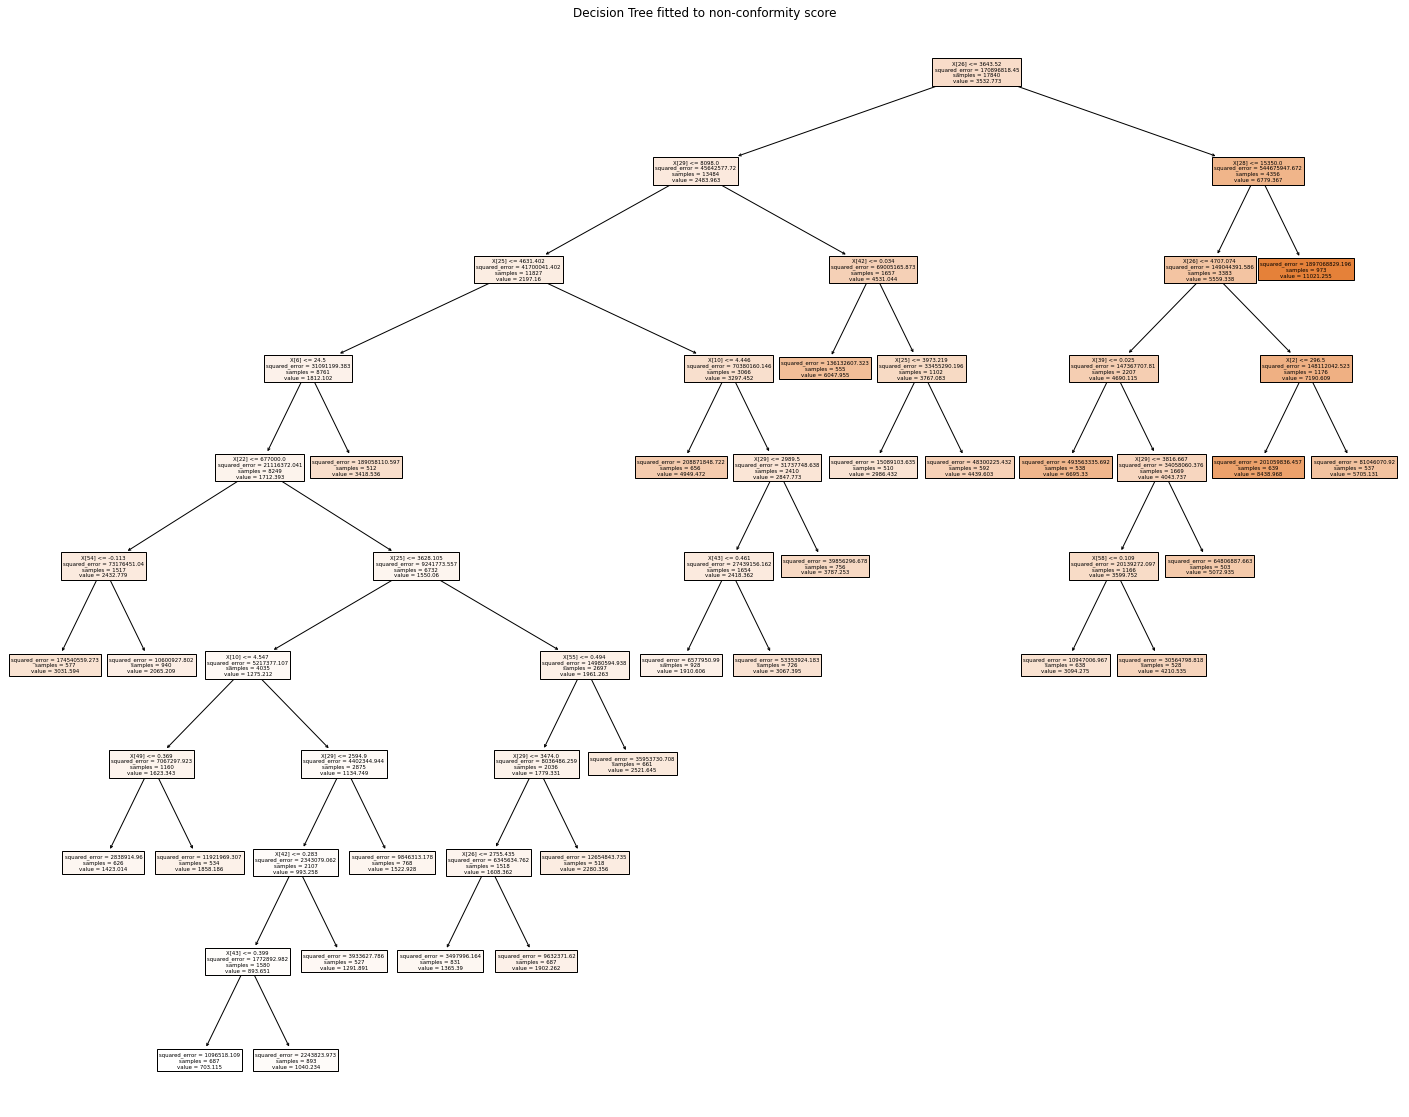

<Figure size 432x288 with 0 Axes>

In [ ]:
values_news_nocalib = obtain_main_metrics(data_name = "news",
test_size = 0.1,
calib_size = 0.5,
split_calib = False,
random_seed = 1250,
sig  = 0.1,
nbins = 10,
min_samples_leaf= 500,
figname_tree = "locart_tree_news_nosplit.pdf",
random_state = 750)

In [ ]:
values_news_nocalib[0]

Methods  Pearson correlation  HSIC correlation  \
0                  LOCLUSTER            -0.072533      6.580597e-04   
1                     LOCART            -0.006136      7.669284e-05   
2            Regresion split             0.002477      3.241725e-13   
3  Weighted regression split             0.027666      1.754393e-05   
4  Mondrian regression split             0.023850      1.347548e-05   

   delta wsc  delta_ils  Average marginal coverage  Average interval length  \
0   0.043445  -0.178583                   0.894578              9134.241774   
1   0.015770   0.000000                   0.889533              9367.037211   
2   0.118954  -0.292874                   0.907945             13519.320000   
3   0.008668   0.013107                   0.903405             12451.383606   
4   0.030816  -0.012026                   0.901387              9293.345170   

   Average interval length given coverage  
0                             9005.509357  
1                             9353.924142  
2                            13519.320000  
3                            12587.795765  
4                             9356.116816

Superconductivity with split:

Fitting mondrian regression split
Time Elapsed to fit mondrian regression split:  58.1069815158844
Computing metrics
Time Elapsed to compute statistics for mondrian regression split:  56.26831126213074
Fitting locluster
Time Elapsed to fit locluster:  103.18789339065552
Computing metrics
Time Elapsed to compute metrics for Locluster:  83.46502542495728
Fitting locart
Time Elapsed to fit Locart:  60.1476628780365
Computing metrics
Time Elapsed to compute metrics for Locart:  78.57944059371948
Fitting regression split
Time Elapsed to fit regression split:  59.09822869300842
Computing metrics
Time Elapsed to compute statistics for regression split:  55.16823863983154
Fitting weighted regression split
Time Elapsed to fit weighted regression split:  88.66446661949158
Computing metrics
Time Elapsed to compute statistics for weighted regression split:  88.66446661949158


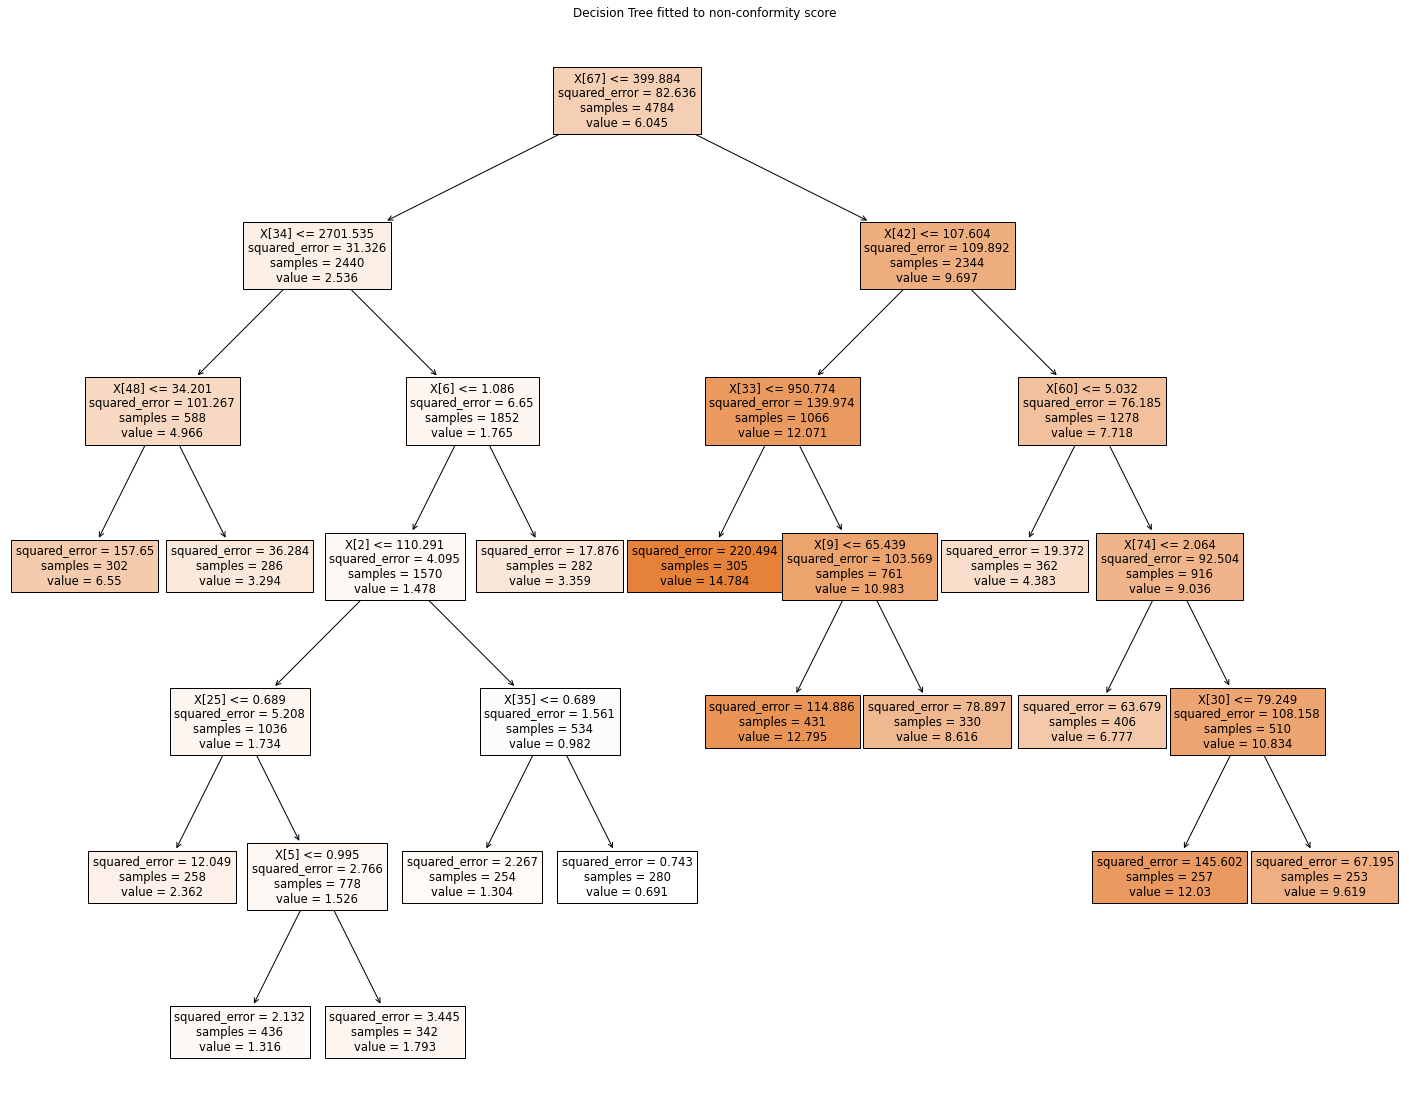

<Figure size 432x288 with 0 Axes>

In [ ]:
values_superconduct = obtain_main_metrics(data_name = "superconductivity",
test_size = 0.1,
calib_size = 0.5,
split_calib = True,
random_seed = 1250,
sig  = 0.1,
nbins = 10,
min_samples_leaf= 250,
figname_tree = "locart_tree_superconduct_split.pdf",
random_state = 750)

In [ ]:
values_superconduct[0]

Methods  Pearson correlation  HSIC correlation  \
0                  LOCLUSTER            -0.011386      4.585264e-05   
1                     LOCART            -0.023930      3.177363e-05   
2            Regresion split            -0.016135     -7.778969e-19   
3  Weighted regression split             0.075973      2.698991e-05   
4  Mondrian regression split            -0.008471      2.727868e-05   

   delta wsc  delta_ils  Average marginal coverage  Average interval length  \
0   0.145157  -0.160158                   0.895157                26.207785   
1   0.041450   0.000000                   0.902210                26.203497   
2   0.108503  -0.188086                   0.894217                31.236183   
3   0.009782  -0.091261                   0.893277                25.115006   
4   0.161100  -0.167802                   0.904090                24.261363   

   Average interval length given coverage  
0                               26.142178  
1                               26.066875  
2                               31.236183  
3                               25.732970  
4                               24.210067

Superconductivity without split:

Fitting mondrian regression split
Time Elapsed to fit mondrian regression split:  51.64083433151245
Computing metrics
Time Elapsed to compute statistics for mondrian regression split:  57.699079513549805
Fitting locluster
Time Elapsed to fit locluster:  89.7760877609253
Computing metrics
Time Elapsed to compute metrics for Locluster:  85.38680624961853
Fitting locart
Time Elapsed to fit Locart:  52.830374002456665
Computing metrics
Time Elapsed to compute metrics for Locart:  75.722984790802
Fitting regression split
Time Elapsed to fit regression split:  51.89587378501892
Computing metrics
Time Elapsed to compute statistics for regression split:  55.668291091918945
Fitting weighted regression split
Time Elapsed to fit weighted regression split:  83.23607587814331
Computing metrics
Time Elapsed to compute statistics for weighted regression split:  83.23607587814331


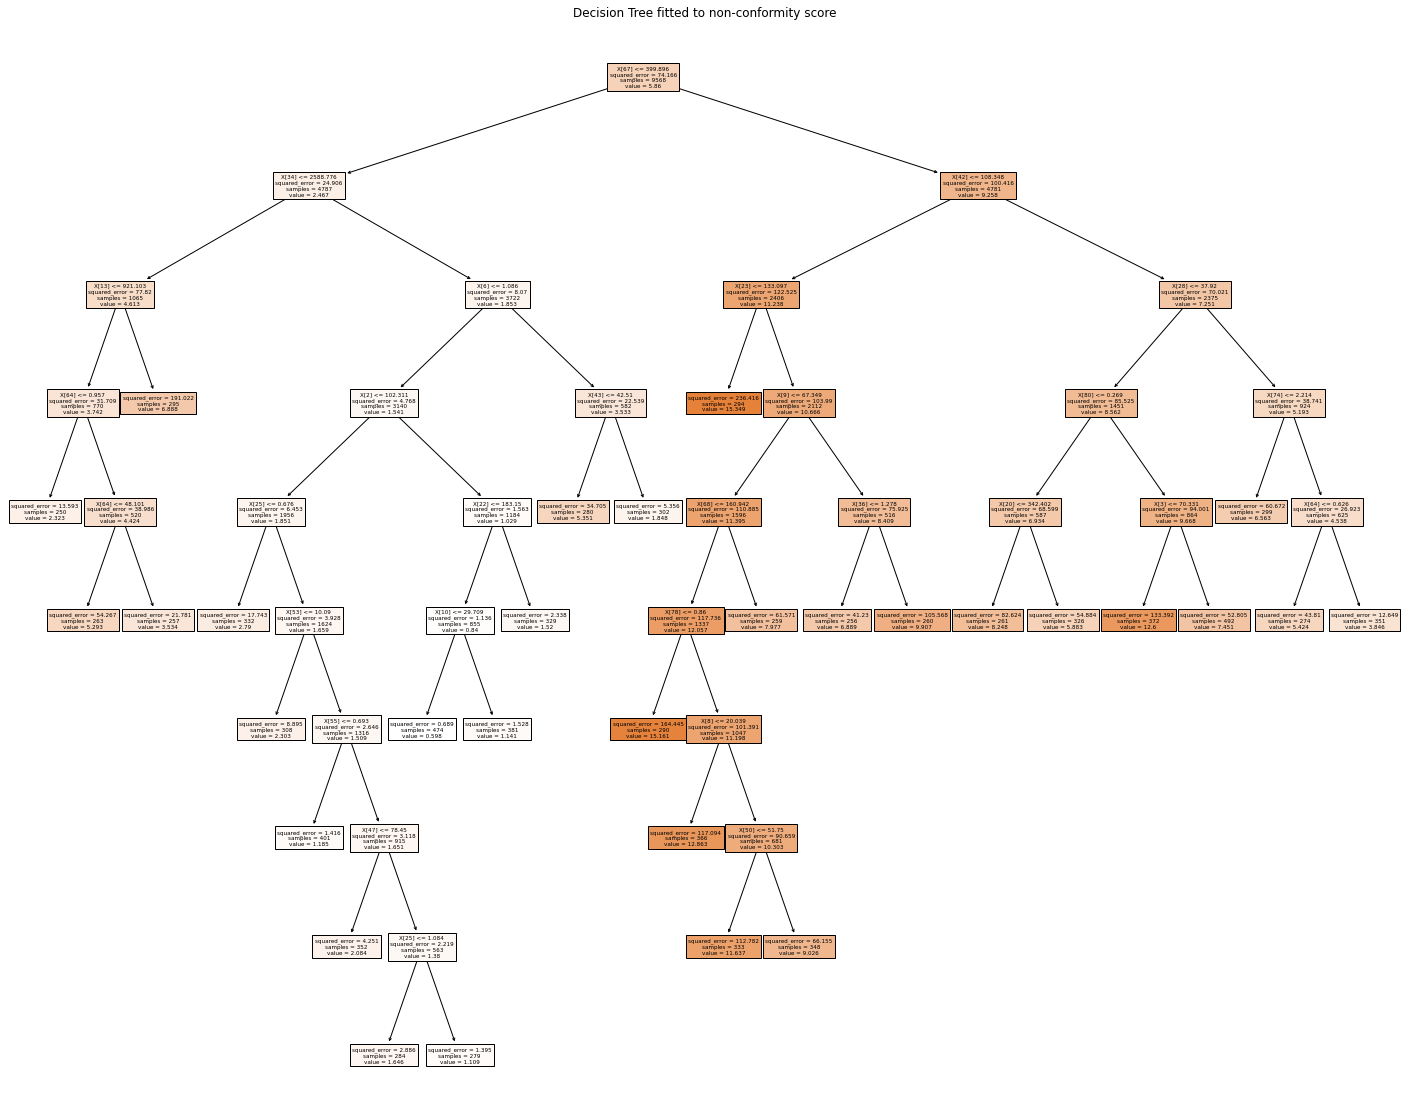

<Figure size 432x288 with 0 Axes>

In [ ]:
values_superconduct_nocalib = obtain_main_metrics(data_name = "superconductivity",
test_size = 0.1,
calib_size = 0.5,
split_calib = False,
random_seed = 1250,
sig  = 0.1,
nbins = 10,
min_samples_leaf= 250,
figname_tree = "locart_tree_superconduct_nosplit.pdf",
random_state = 750)

In [ ]:
values_superconduct_nocalib[0]

Methods  Pearson correlation  HSIC correlation  \
0                  LOCLUSTER            -0.011386      4.585264e-05   
1                     LOCART             0.014730      5.933382e-05   
2            Regresion split            -0.016135     -7.778969e-19   
3  Weighted regression split             0.075973      2.698991e-05   
4  Mondrian regression split            -0.008471      2.727868e-05   

   delta wsc  delta_ils  Average marginal coverage  Average interval length  \
0   0.145157  -0.051853                   0.895157                26.207785   
1   0.030270   0.000000                   0.892807                26.312090   
2   0.108503  -0.156183                   0.894217                31.236183   
3   0.009782   0.002649                   0.893277                25.115006   
4   0.161100  -0.130230                   0.904090                24.261363   

   Average interval length given coverage  
0                               26.142178  
1                               26.411732  
2                               31.236183  
3                               25.732970  
4                               24.210067

Kernel with split:

In [ ]:
values_kernel = obtain_main_metrics(data_name = "kernel",
test_size = 0.05,
calib_size = 0.5,
split_calib = True,
random_seed = 1250,
sig  = 0.1,
nbins = 10,
min_samples_leaf= 1000,
figname_tree = "locart_tree_kernel_split.pdf",
random_state = 750)

Fitting mondrian regression split
Time Elapsed to fit mondrian regression split:  67.77476620674133
Computing metrics
Time Elapsed to compute statistics for mondrian regression split:  719.6044721603394
Fitting locluster
Time Elapsed to fit locluster:  688.9839856624603
Computing metrics
Time Elapsed to compute metrics for Locluster:  590.2281563282013
Fitting locart
Time Elapsed to fit Locart:  110.24262833595276
Computing metrics
Time Elapsed to compute metrics for Locart:  703.0806488990784
Fitting regression split
Time Elapsed to fit regression split:  202.55798172950745
Computing metrics


: 

: 

In [ ]:
values_kernel[0]

Kernel without split:

In [ ]:
values_kernel_nocalib = obtain_main_metrics(data_name = "kernel",
test_size = 0.05,
calib_size = 0.5,
split_calib = False,
random_seed = 1250,
sig  = 0.1,
nbins = 10,
min_samples_leaf= 1000,
figname_tree = "locart_tree_kernel_split.pdf",
random_state = 750)

In [ ]:
values_kernel_nocalib[0]